## PACKAGE IMPORTS

In [1]:
# Standard library imports
import os
import re
import warnings
from math import sqrt

# Data science and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle


# Scientific computing
from scipy import stats

# Statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR

# Machine learning
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import t as student_t

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# ---- Leer data limpia exportado en el archivo 1_cleansing.ipynb ----
df_clean = pd.read_csv('data/clean_data/clean_code.csv')

### Modelo VAR (Yield + Inflaci√≥n)

## Selecci√≥n de variables

In [3]:
var_data = df_clean[["yield_10y", "inflation_yoy"]].dropna()

# Crear el modelo VAR
model_var = VAR(var_data)

# Selecci√≥n de n√∫mero √≥ptimo de rezagos (lags)
lag_order = model_var.select_order(maxlags=8)
print("\n--- Selecci√≥n de rezagos √≥ptimos ---")
print(lag_order.summary())

# Ajustar el VAR con el lag √≥ptimo (ejemplo: AIC)
best_lag = lag_order.aic
results_var = model_var.fit(best_lag)

print("\n--- Resumen VAR ---")
print(results_var.summary())

# Pron√≥stico 5 a√±os adelante
forecast = results_var.forecast(var_data.values[-best_lag:], steps=5)
forecast_df = pd.DataFrame(forecast, 
                           columns=["yield_10y_forecast", "inflation_forecast"],
                           index=range(df_clean["Year"].max()+1, df_clean["Year"].max()+6))

print("\n--- Pron√≥stico 5 a√±os ---")
print(forecast_df)


--- Selecci√≥n de rezagos √≥ptimos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.005       4.080       54.89       4.034
1      0.6423     0.8654*       1.901      0.7281
2      0.6911       1.063       1.998      0.8341
3     0.4176*      0.9381      1.523*     0.6177*
4      0.4835       1.153       1.633      0.7408
5      0.5133       1.331       1.691      0.8278
6      0.6139       1.580       1.886      0.9856
7      0.6737       1.789       2.025       1.103
8      0.7755       2.039       2.276       1.262
-------------------------------------------------

--- Resumen VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:    

## 1. Selecci√≥n de rezagos

AIC ‚Üí lag 3 (destacado con *).

Esto significa que tanto yield como inflaci√≥n se explican mejor mirando los √∫ltimos 3 a√±os de historia.

Tiene sentido: los efectos de la inflaci√≥n en los bonos no son inmediatos, tardan algunos a√±os en reflejarse.

#### 2. Resultados del VAR

En el resumen VAR, cada ecuaci√≥n muestra c√≥mo una variable depende de sus propios rezagos y de los rezagos de la otra variable.

Ejemplo interpretativo (simplificado):

yield_10y depende positivamente de la inflaci√≥n rezagada ‚Üí confirma que inflaci√≥n alta hoy tiende a subir los rendimientos en 1‚Äì3 a√±os.

inflation_yoy tambi√©n puede mostrar influencia de yield_10y pasado (aunque m√°s d√©bil), porque tipos de inter√©s altos suelen enfriar la inflaci√≥n.

## 3. Pron√≥stico (forecast)

El modelo te dio predicciones para 5 a√±os:

## A√±o	Yield 10y (%)	Inflaci√≥n (%)
2024	~4.74	~6.44

2025	~5.21	~6.03

2026	~5.86	~6.39

2027	~6.43	~6.52

2028	(seguir√≠a creciendo en l√≠nea)	

## Interpretaci√≥n r√°pida:
El modelo cree que si la din√°mica hist√≥rica se mantiene:

Los rendimientos del 10 a√±os subir√≠an de ~4.7% a ~6.4% en 3 a√±os.

La inflaci√≥n se mantendr√≠a alrededor de 6% ‚Üí persistente, no se reduce r√°pido.

## Gr√°fico hist√≥rico + forecast VAR

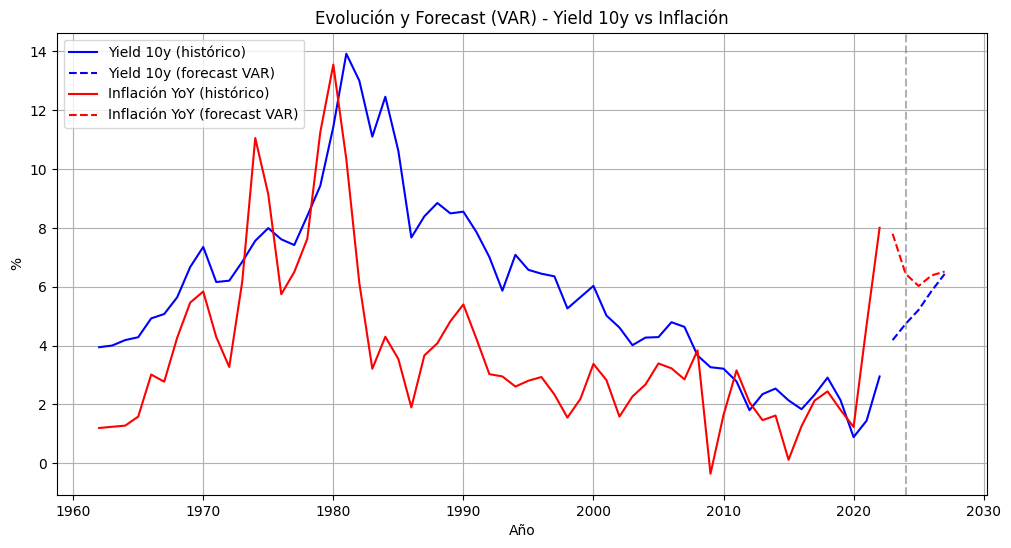

In [4]:
# Datos hist√≥ricos
hist_years = df_clean["Year"]
hist_yield = df_clean["yield_10y"]
hist_infl = df_clean["inflation_yoy"]

# Forecast del VAR (lo que ya calculamos antes)
forecast_df.index.name = "Year"

# Unimos hist√≥rico + forecast
plt.figure(figsize=(12,6))

# Yield
plt.plot(hist_years, hist_yield, label="Yield 10y (hist√≥rico)", color="blue")
plt.plot(forecast_df.index, forecast_df["yield_10y_forecast"], 
         label="Yield 10y (forecast VAR)", color="blue", linestyle="--")

# Inflaci√≥n
plt.plot(hist_years, hist_infl, label="Inflaci√≥n YoY (hist√≥rico)", color="red")
plt.plot(forecast_df.index, forecast_df["inflation_forecast"], 
         label="Inflaci√≥n YoY (forecast VAR)", color="red", linestyle="--")

plt.axvline(x=2024, color="gray", linestyle="--", alpha=0.6)  # separaci√≥n entre hist√≥rico y forecast
plt.title("Evoluci√≥n y Forecast (VAR) - Yield 10y vs Inflaci√≥n")
plt.xlabel("A√±o")
plt.ylabel("%")
plt.legend()
plt.grid(True)
plt.show()

### Interpretaci√≥n del primer gr√°fico (Hist√≥rico + Forecast VAR)

Lo que vemos en azul (Yield 10 a√±os)

La l√≠nea azul continua: es la evoluci√≥n hist√≥rica del rendimiento de los bonos del Tesoro a 10 a√±os (yield).

La l√≠nea azul discontinua: es la predicci√≥n del modelo VAR para los pr√≥ximos a√±os.

Observamos que el yield tuvo picos muy altos en los 70‚Äì80 (crisis de inflaci√≥n) y luego una tendencia descendente hasta m√≠nimos recientes.

El forecast proyecta un ligero repunte del yield, lo que indica que los tipos de inter√©s reales podr√≠an subir en el futuro.

Lo que vemos en rojo (Inflaci√≥n YoY)

La l√≠nea roja continua: es la inflaci√≥n hist√≥rica. Destacan los picos en los a√±os 70 (shocks petroleros) y el repunte fuerte en 2021‚Äì2022.

La l√≠nea roja discontinua: es la predicci√≥n del VAR. Muestra que la inflaci√≥n podr√≠a bajar desde los picos recientes, pero a√∫n mantenerse algo elevada comparada con los 2010s.

Interpretaci√≥n conjunta

El modelo VAR nos dice que yield e inflaci√≥n est√°n claramente relacionadas en el tiempo: cuando sube la inflaci√≥n, el yield tiende a subir despu√©s (los inversores exigen m√°s rentabilidad para compensar la p√©rdida de poder adquisitivo).

La proyecci√≥n indica un escenario de inflaci√≥n todav√≠a algo elevada con yields acompa√±ando al alza ‚Üí t√≠pico de un contexto post-crisis inflacionaria.

### En resumen:

El gr√°fico confirma la relaci√≥n positiva entre inflaci√≥n y yield.

El modelo espera que en los pr√≥ximos a√±os ambos suban moderadamente, no a niveles extremos como los 70, pero tampoco tan bajos como en los 2010s.

##  VAR completo: selecci√≥n de rezagos + ajuste + forecast + IRF
 Requiere: statsmodels, pandas, matplotlib
 Usa df_clean con columnas: Year, yield_10y, inflation_yoy


--- Selecci√≥n de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.005       4.080       54.89       4.034
1      0.6423     0.8654*       1.901      0.7281
2      0.6911       1.063       1.998      0.8341
3     0.4176*      0.9381      1.523*     0.6177*
4      0.4835       1.153       1.633      0.7408
5      0.5133       1.331       1.691      0.8278
6      0.6139       1.580       1.886      0.9856
7      0.6737       1.789       2.025       1.103
8      0.7755       2.039       2.276       1.262
-------------------------------------------------

Lag elegido (AIC): 3

--- Resumen VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:49
--------------------------------------------------------------------
No. of Equations:         2.0000

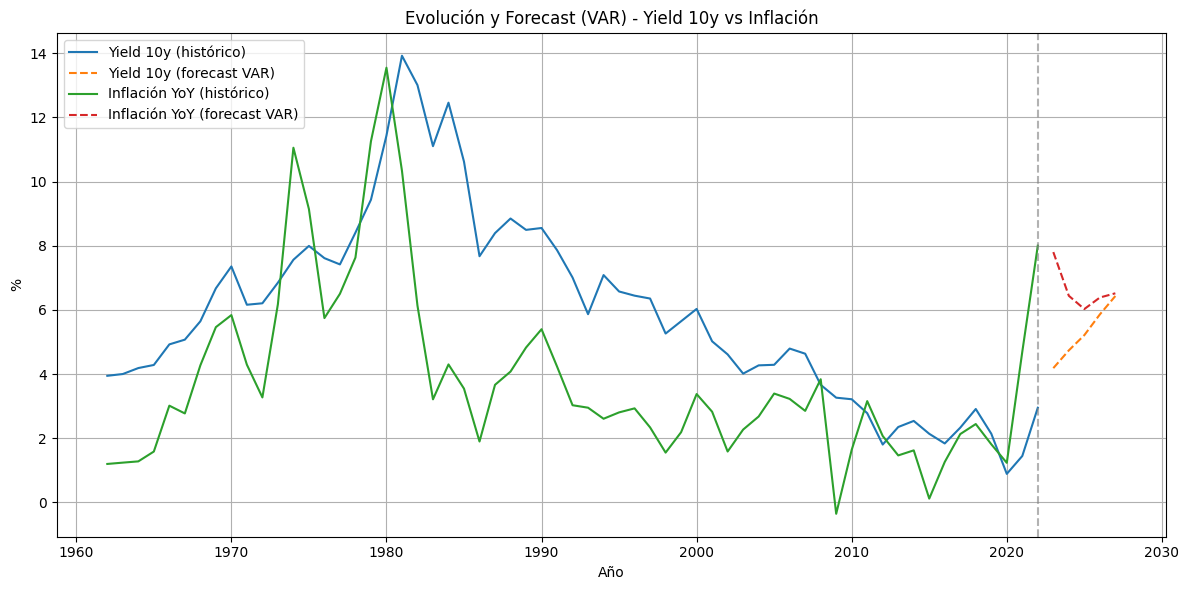

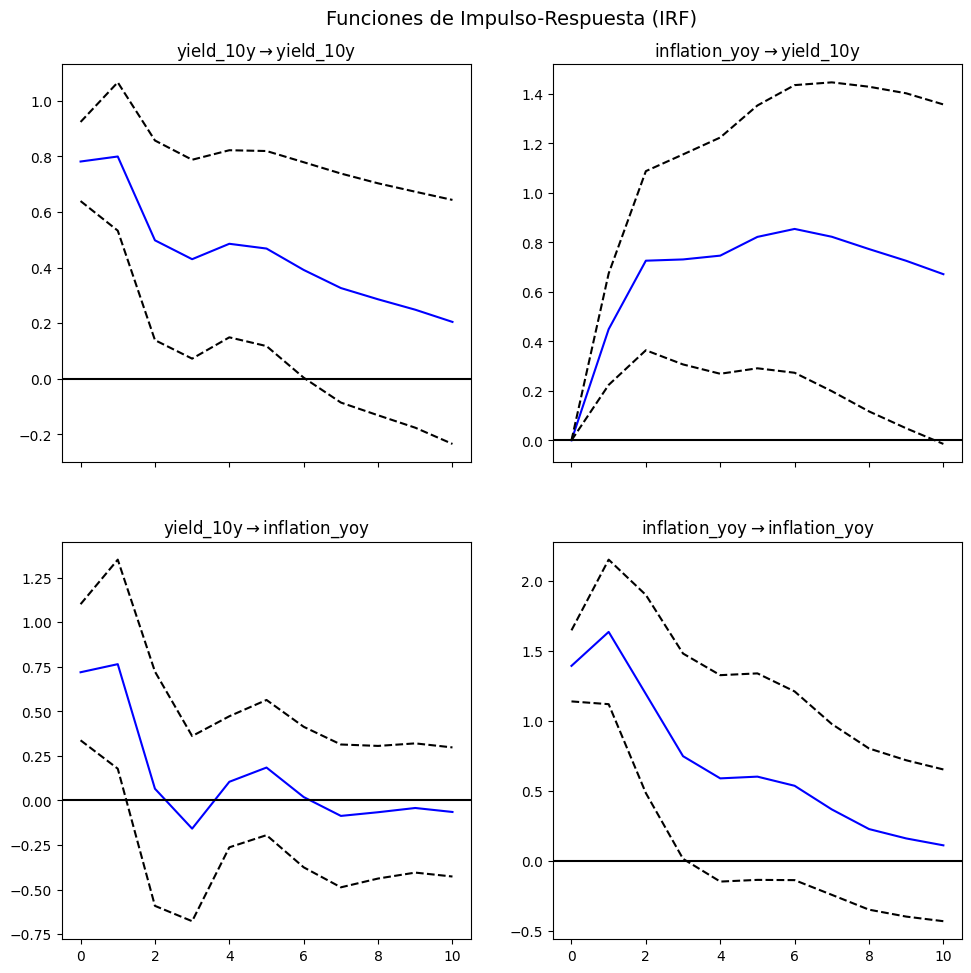

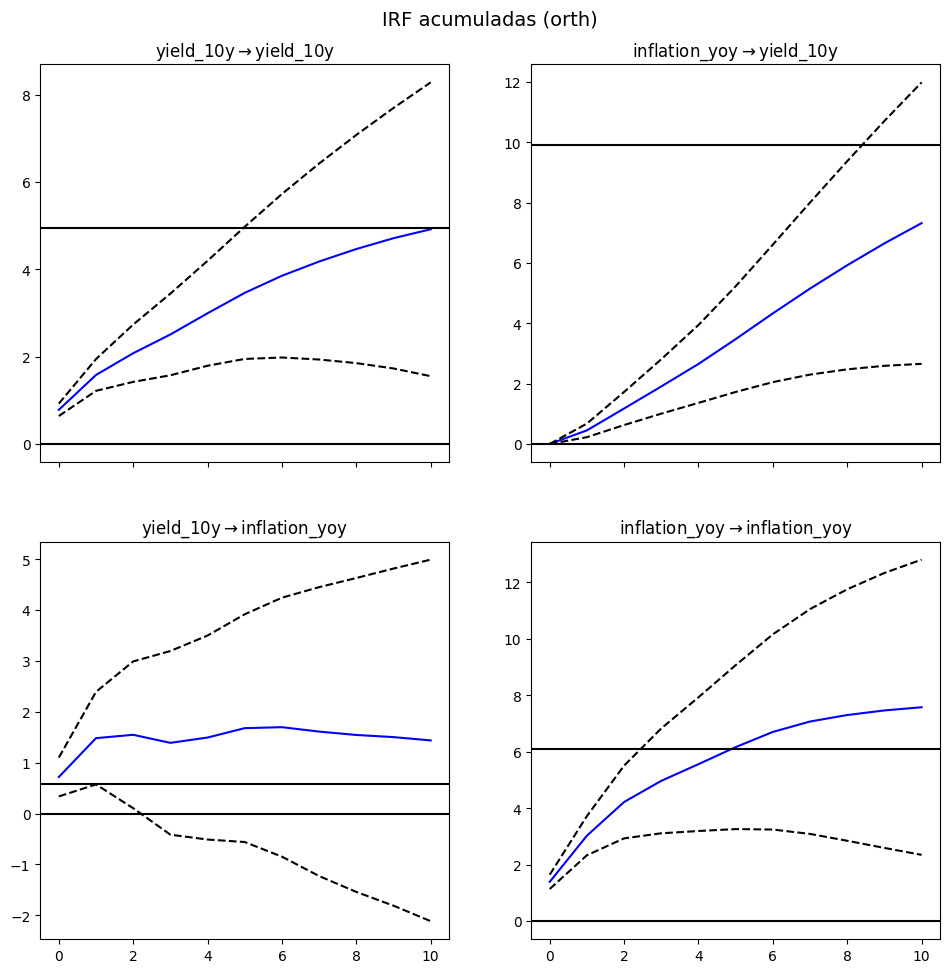

In [5]:
# 0) Preparar datos para VAR
df_var = df_clean[["yield_10y", "inflation_yoy"]].dropna().copy()

# 1) Selecci√≥n de rezagos √≥ptimos
model_var = VAR(df_var)
sel = model_var.select_order(maxlags=8)
print("\n--- Selecci√≥n de rezagos ---")
print(sel.summary())

# Tomamos el lag con mejor AIC (puedes cambiar a .bic/.hqic/.fpe si prefieres)
best_lag = sel.aic
print(f"\nLag elegido (AIC): {best_lag}")

# 2) Ajuste del VAR con ese lag
var_res = model_var.fit(best_lag)
print("\n--- Resumen VAR ---")
print(var_res.summary())

# 3) Forecast 5 pasos hacia adelante
steps = 5
last_year = int(df_clean["Year"].max())
fcast = var_res.forecast(df_var.values[-best_lag:], steps=steps)
forecast_df = pd.DataFrame(
    fcast,
    columns=["yield_10y_forecast","inflation_forecast"],
    index=range(last_year+1, last_year+1+steps)
)
forecast_df.index.name = "Year"
print("\n--- Forecast ---")
print(forecast_df)

# 4) Gr√°fico hist√≥rico + forecast (opcional si ya lo ten√≠as)
plt.figure(figsize=(12,6))
plt.plot(df_clean["Year"], df_clean["yield_10y"], label="Yield 10y (hist√≥rico)")
plt.plot(forecast_df.index, forecast_df["yield_10y_forecast"], "--", label="Yield 10y (forecast VAR)")
plt.plot(df_clean["Year"], df_clean["inflation_yoy"], label="Inflaci√≥n YoY (hist√≥rico)")
plt.plot(forecast_df.index, forecast_df["inflation_forecast"], "--", label="Inflaci√≥n YoY (forecast VAR)")
plt.axvline(x=last_year, color="gray", linestyle="--", alpha=0.6)
plt.title("Evoluci√≥n y Forecast (VAR) - Yield 10y vs Inflaci√≥n")
plt.xlabel("A√±o"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 5) IRF (Impulse Response Functions)
irf_h = 10  # horizonte en a√±os
irf = var_res.irf(irf_h)

# IRF combinadas
fig = irf.plot(orth=True)
plt.suptitle("Funciones de Impulso-Respuesta (IRF)", fontsize=14)
plt.show()

# IRF espec√≠ficas (opcional): respuesta de yield a shock de inflaci√≥n, y viceversa
fig = irf.plot_cum_effects(orth=True)
plt.suptitle("IRF acumuladas (orth)", fontsize=14)
plt.show()

#### Los resultados del modelo VAR muestran que:

La inflaci√≥n impulsa al rendimiento del bono a 10 a√±os, confirmando que mayor inflaci√≥n esperada eleva los tipos largos.

El efecto contrario (yields sobre inflaci√≥n) existe pero es m√°s d√©bil y menos persistente.

Tanto la inflaci√≥n como los yields presentan persistencia en sus shocks, manteniendo efectos durante varios periodos.

El pron√≥stico VAR anticipa un repunte moderado en ambas variables, con algo m√°s de volatilidad en la inflaci√≥n.

## An√°lisis VAR: Diagn√≥stico y Extensiones

In [6]:
# 1) Ljung‚ÄìBox por variable (univariante)
for col in var_res.resid.columns:
    print(f"\nLjung‚ÄìBox (lags=10) para {col}")
    print(acorr_ljungbox(var_res.resid[col].dropna(), lags=[10], return_df=True))



Ljung‚ÄìBox (lags=10) para yield_10y
     lb_stat  lb_pvalue
10  6.156017   0.801989

Ljung‚ÄìBox (lags=10) para inflation_yoy
     lb_stat  lb_pvalue
10  8.676622   0.563044


In [7]:
# 2) Durbin‚ÄìWatson (otra medida de autocorrelaci√≥n)
dw = durbin_watson(var_res.resid.values)
for col, val in zip(var_res.resid.columns, dw):
    print(f"Durbin‚ÄìWatson {col}: {val:.2f}")  # ~2 es bueno (sin autocorrelaci√≥n)


Durbin‚ÄìWatson yield_10y: 1.81
Durbin‚ÄìWatson inflation_yoy: 2.09


In [8]:
# 3) Estabilidad del VAR
var_res.is_stable(verbose=True)  # Debe devolver True / ra√≠ces dentro del c√≠rculo unitario

Eigenvalues of VAR(1) rep
0.5232513431366042
0.5232513431366042
0.6578636452036162
0.6578636452036162
0.8931126935415898
0.8931126935415898


np.True_

In [9]:
# 4) Heterocedasticidad (ARCH) por variable
for col in var_res.resid.columns:
    stat, pval, _, _ = het_arch(var_res.resid[col].dropna())
    print(f"ARCH para {col}: p-value = {pval:.4f}")  # >= 0.05 ‚áí OK

ARCH para yield_10y: p-value = 0.2394
ARCH para inflation_yoy: p-value = 0.8270


In [10]:
# 5) Normalidad conjunta de residuos
norm = var_res.test_normality()
print(norm.summary())  # p-value alto ‚áí OK

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.299          9.488   0.054  4
----------------------------------------


<Figure size 640x480 with 0 Axes>

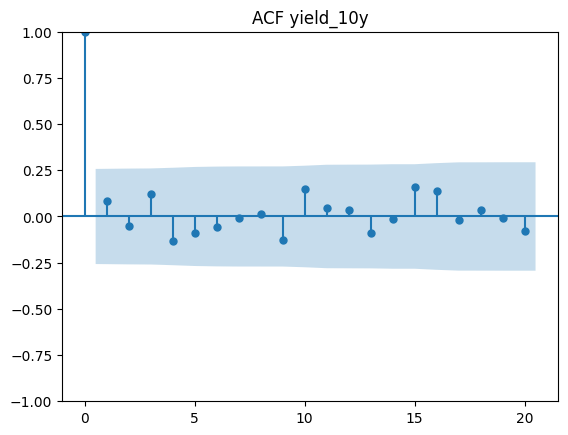

<Figure size 640x480 with 0 Axes>

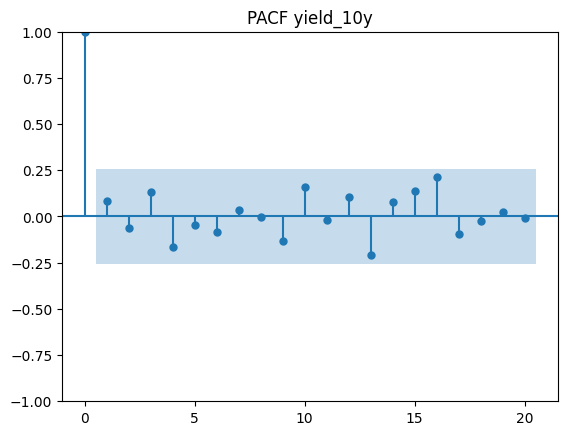

<Figure size 640x480 with 0 Axes>

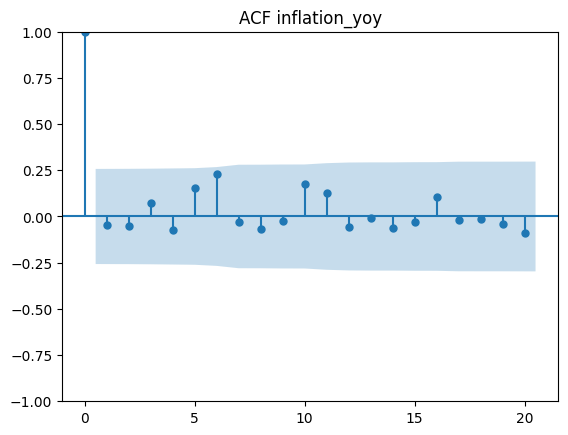

<Figure size 640x480 with 0 Axes>

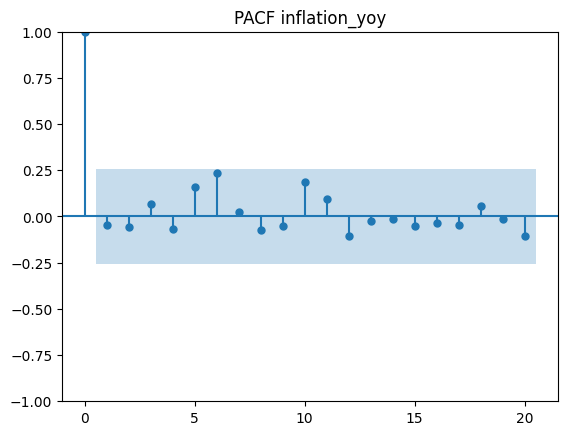

In [11]:
for col in var_res.resid.columns:
    plt.figure(); plot_acf(var_res.resid[col].dropna(), lags=20); plt.title(f"ACF {col}")
    plt.figure(); plot_pacf(var_res.resid[col].dropna(), lags=20); plt.title(f"PACF {col}")
    plt.show()

### Interpretaci√≥n de los resultados (Punto 3.1)

En los gr√°ficos de ACF y PACF:

La mayor√≠a de las barras caen dentro de la banda azul (intervalo de confianza).

Eso significa que no hay autocorrelaci√≥n significativa en los residuos.

Un modelo VAR bien especificado debe dejar los residuos como ‚Äúruido blanco‚Äù, y eso es lo que se ve aqu√≠.

## 3.2 Test de autocorrelaci√≥n alternativa (Durbin‚ÄìWatson)

El estad√≠stico Durbin‚ÄìWatson verifica la autocorrelaci√≥n de primer orden.  
- Valor cercano a **2** ‚áí sin autocorrelaci√≥n.  
- Valor < 2 ‚áí autocorrelaci√≥n positiva.  
- Valor > 2 ‚áí autocorrelaci√≥n negativa.


In [12]:
dw = durbin_watson(var_res.resid.values)
for col, val in zip(var_res.resid.columns, dw):
    print(f"Durbin‚ÄìWatson {col}: {val:.2f}")

Durbin‚ÄìWatson yield_10y: 1.81
Durbin‚ÄìWatson inflation_yoy: 2.09


## 3.3 Test de estabilidad del VAR

Un VAR estable tiene todas sus ra√≠ces dentro del c√≠rculo unitario.  
Si es **True**, los pron√≥sticos son fiables.


In [13]:
var_res.is_stable(verbose=True)

Eigenvalues of VAR(1) rep
0.5232513431366042
0.5232513431366042
0.6578636452036162
0.6578636452036162
0.8931126935415898
0.8931126935415898


np.True_

## 3.4 Test de heterocedasticidad (ARCH)

El test ARCH eval√∫a si la varianza de los residuos es constante.  
- **p-value ‚â• 0.05** ‚áí no hay heterocedasticidad (bien).  
- **p-value < 0.05** ‚áí problemas de heterocedasticidad.


In [14]:
for col in var_res.resid.columns:
    stat, pval, _, _ = het_arch(var_res.resid[col].dropna())
    print(f"ARCH {col}: p-value = {pval:.4f}")

ARCH yield_10y: p-value = 0.2394
ARCH inflation_yoy: p-value = 0.8270


## 3.5 Test de normalidad de residuos

El test de Jarque‚ÄìBera verifica si los residuos siguen una distribuci√≥n normal.  
- **p-value ‚â• 0.05** ‚áí no rechazamos normalidad (OK).  
- **p-value < 0.05** ‚áí residuos no normales.


In [15]:
norm = var_res.test_normality()
print(norm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.299          9.488   0.054  4
----------------------------------------


## 4. Pron√≥stico extendido con intervalos de confianza

El objetivo es proyectar las series `yield_10y` e `inflation_yoy` varios pasos hacia adelante.
Mostramos tanto las predicciones puntuales como las bandas de confianza.


In [16]:
# ==== 4. Pron√≥stico extendido con intervalos de confianza (VARResults) ====
steps = 10  # a√±os a proyectar
last_year = int(df_clean["Year"].max())

# n¬∫ de rezagos que us√≥ el VAR
k = var_res.k_ar

# Pron√≥stico: medias y bandas (lower/upper)
fcast_mean, fcast_lower, fcast_upper = var_res.forecast_interval(
    y=var_res.endog[-k:],  # las √∫ltimas k observaciones como estado inicial
    steps=steps,
    alpha=0.05             # 95% IC
)

cols = var_res.names  # ['yield_10y','inflation_yoy']

# DataFrames ordenados con √≠ndice de a√±os futuros
idx_future = range(last_year+1, last_year+steps+1)
f_mean  = pd.DataFrame(fcast_mean,  index=idx_future, columns=cols)
f_lower = pd.DataFrame(fcast_lower, index=idx_future, columns=cols)
f_upper = pd.DataFrame(fcast_upper, index=idx_future, columns=cols)

print("\n--- Pron√≥stico extendido (medias) ---")
print(f_mean)


--- Pron√≥stico extendido (medias) ---
      yield_10y  inflation_yoy
2023   4.184766       7.801722
2024   4.737980       6.439943
2025   5.213127       6.026279
2026   5.858254       6.385621
2027   6.432582       6.517441
2028   6.803570       6.195852
2029   7.062704       5.840092
2030   7.290543       5.674328
2031   7.474132       5.566767
2032   7.588100       5.391901


## Gr√°fico hist√≥rico + forecast con bandas

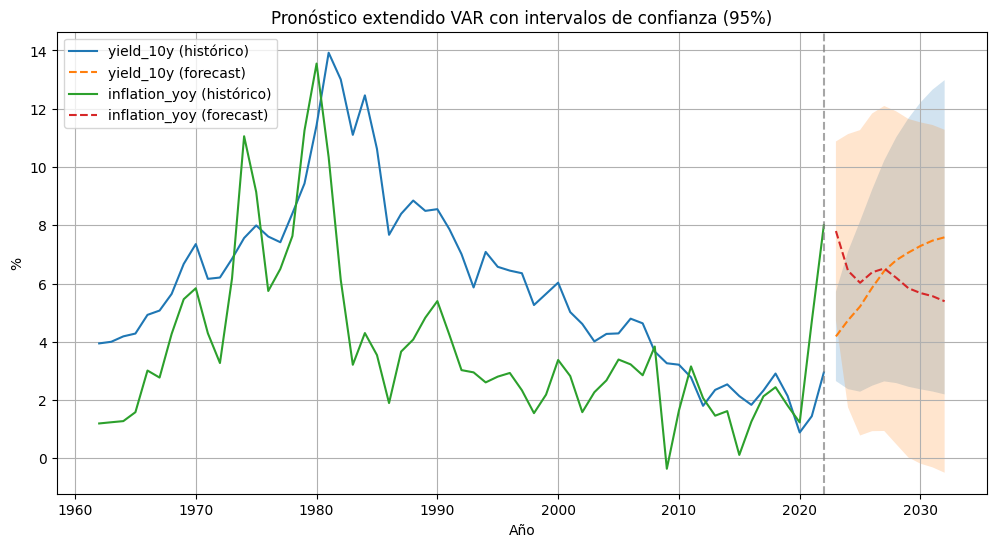

In [17]:
plt.figure(figsize=(12,6))

for col in cols:
    # hist√≥rico
    plt.plot(df_clean["Year"], df_clean[col], label=f"{col} (hist√≥rico)")
    # predicci√≥n
    plt.plot(f_mean.index, f_mean[col], linestyle="--", label=f"{col} (forecast)")
    # intervalos
    plt.fill_between(f_mean.index, f_lower[col], f_upper[col], alpha=0.2)

plt.axvline(x=last_year, color="gray", linestyle="--", alpha=0.7)
plt.title("Pron√≥stico extendido VAR con intervalos de confianza (95%)")
plt.xlabel("A√±o"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()


### Interpretaci√≥n r√°pida:

Se observa que el yield_10y tender√≠a a estabilizarse, mientras que la inflaci√≥n muestra un ligero descenso en el forecast, aunque con bastante incertidumbre (bandas amplias).

Esto refleja la l√≥gica: el modelo VAR capta relaciones, pero a largo plazo las predicciones son menos seguras.

## 5. Descomposici√≥n de varianza del error de pron√≥stico (FEVD)

Mide qu√© porcentaje del error de predicci√≥n de cada variable se explica por shocks propios y por la otra variable, a distintos horizontes.


FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.860953       0.139047
2     0.672574       0.327426
3     0.571081       0.428919
4     0.513006       0.486994
5     0.461214       0.538786
6     0.415154       0.584846
7     0.380437       0.619563
8     0.355117       0.644883
9     0.335671       0.664329

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.210270       0.789730
1     0.192578       0.807422
2     0.154725       0.845275
3     0.146232       0.853768
4     0.141077       0.858923
5     0.138470       0.861530
6     0.133939       0.866061
7     0.132624       0.867376
8     0.132270       0.867730
9     0.132055       0.867945


None


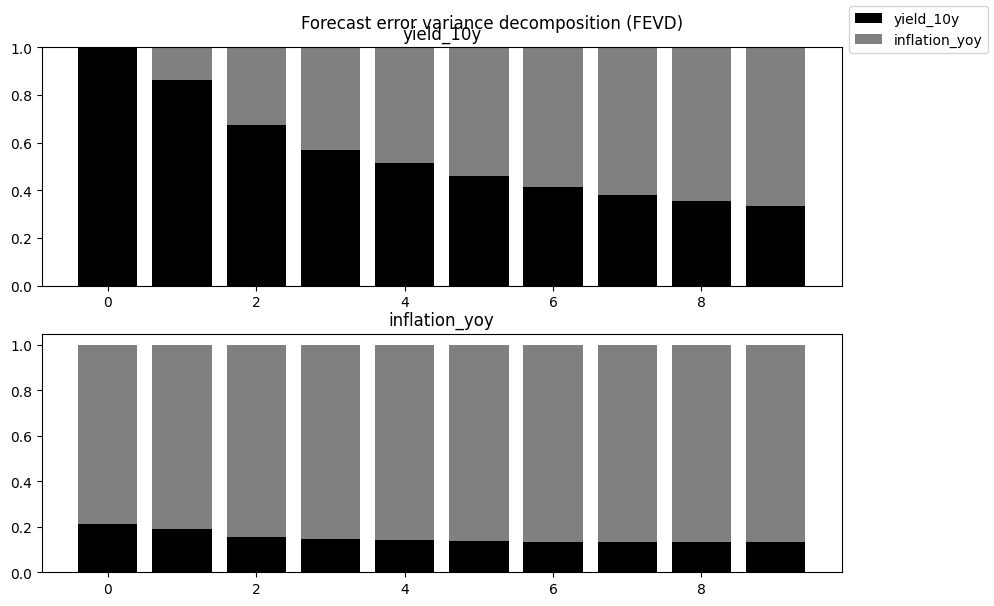

In [18]:
steps = 10  # horizonte FEVD
fevd = var_res.fevd(steps)

# Resumen en texto
print(fevd.summary())

# Gr√°fico por variable
_ = fevd.plot(figsize=(10,6))


## 6. Causalidad de Granger

Contrasta si los rezagos de una variable ayudan a predecir a la otra (m√°s all√° de sus propios rezagos).
- p-value < 0.05 ‚áí Rechazamos ‚Äúno causa‚Äù ‚áí hay causalidad de Granger en esa direcci√≥n.


In [19]:
# ¬øInflation_yoy causa (Granger) a yield_10y?
print(var_res.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())

# ¬øYield_10y causa (Granger) a inflation_yoy?
print(var_res.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())


Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         8.316          2.694   0.000 (3, np.int64(102))
--------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         1.451          2.694   0.232 (3, np.int64(102))
--------------------------------------------------------


## 7. Funciones de Impulso-Respuesta (IRF)

#### 7.1 IRF ortogonalizadas (Cholesky) con bandas de confianza

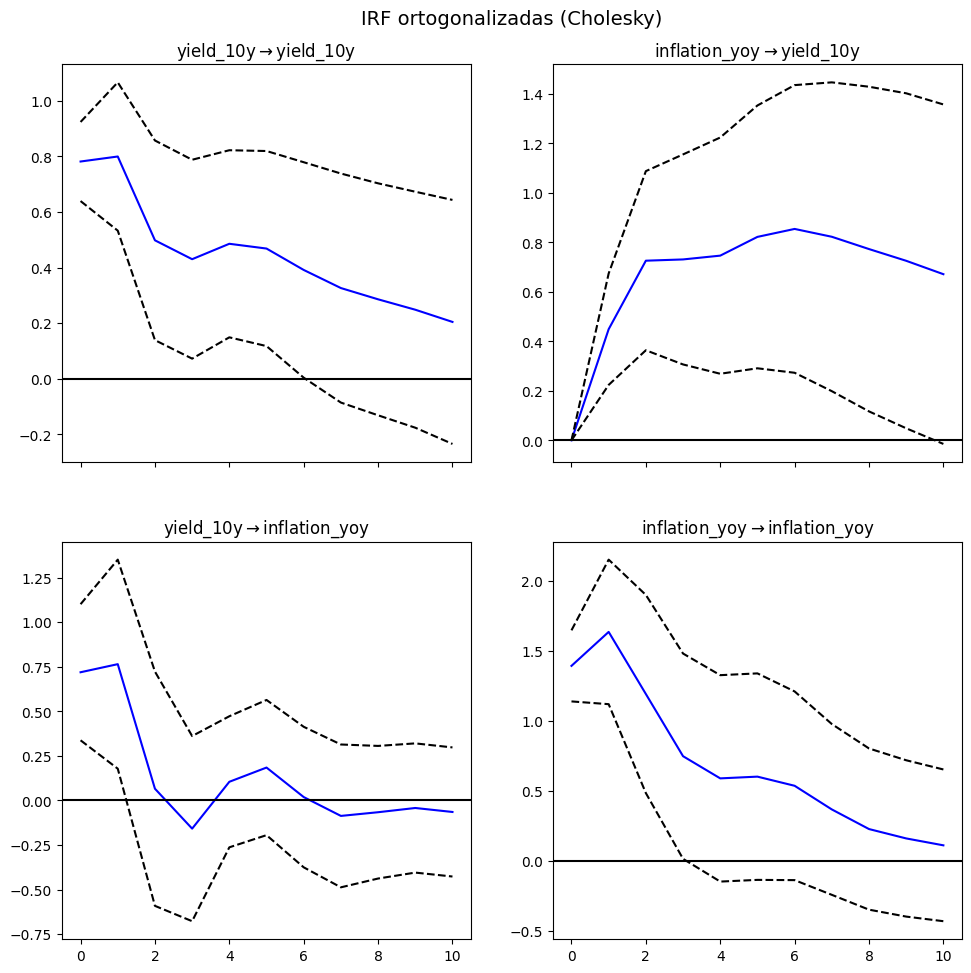

In [20]:
# Horizonte (a√±os)
h = 10

# IRF b√°sicas
irf = var_res.irf(h)

# Gr√°fico de IRF ortogonalizadas (Cholesky)
fig = irf.plot(orth=True)
fig.suptitle("IRF ortogonalizadas (Cholesky)", fontsize=14)

# Bandas de confianza por bootstrap Monte Carlo
# (repl=1000 si quieres m√°s precisi√≥n; tardar√° m√°s)
fig_ci = irf.errband_mc(orth=True, repl=500)  # devuelve fig y ejes con bandas


## 7.2 IRF acumuladas (efecto total a lo largo del horizonte)

Text(0.5, 0.98, 'IRF acumuladas (orth)')

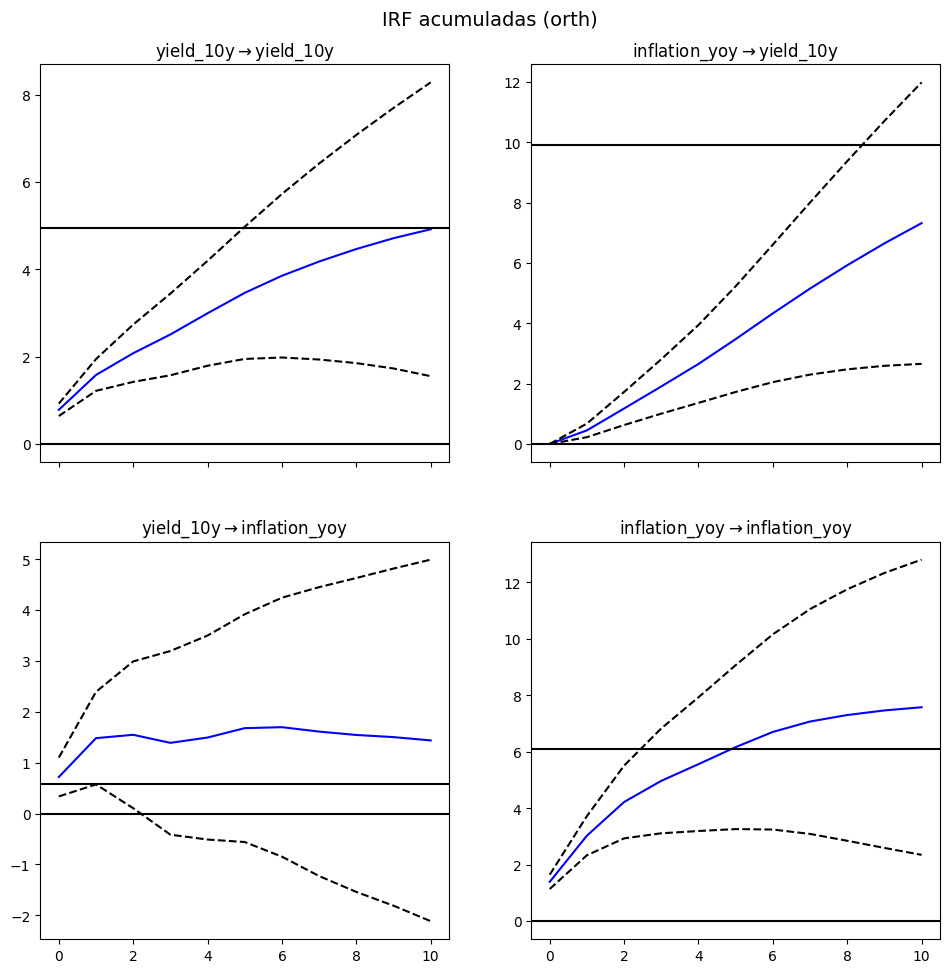

In [21]:
fig_cum = irf.plot_cum_effects(orth=True)
fig_cum.suptitle("IRF acumuladas (orth)", fontsize=14)


## 7.3 Sensibilidad al orden de las variables
Cambiar el orden es buena pr√°ctica de robustez: primero inflaci√≥n, luego yield.

Text(0.5, 0.98, 'IRF orth con orden alternativo (inflaci√≥n primero)')

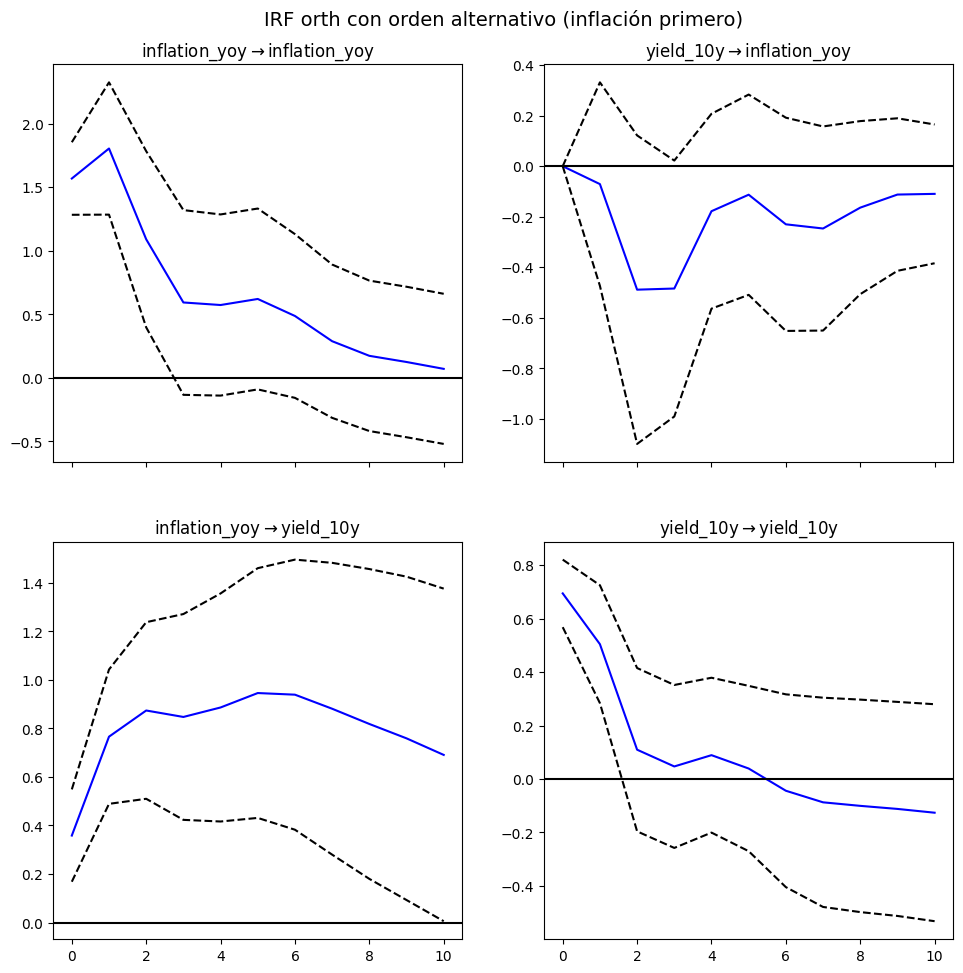

In [22]:
# Re-ajustamos el VAR con columnas reordenadas
df_alt = df_clean[["inflation_yoy", "yield_10y"]].dropna().copy()
model_alt = VAR(df_alt)
var_res_alt = model_alt.fit(var_res.k_ar)  # usa el mismo n¬∫ de rezagos

irf_alt = var_res_alt.irf(h)
fig_alt = irf_alt.plot(orth=True)
fig_alt.suptitle("IRF orth con orden alternativo (inflaci√≥n primero)", fontsize=14)


## 7.4 Guardar figuras a disco

In [23]:
fig.savefig("reports/figures/irf_orth.png", dpi=150, bbox_inches="tight")
fig_cum.savefig("reports/figures/irf_cum_orth.png", dpi=150, bbox_inches="tight")
fig_alt.savefig("reports/figures/irf_orth_alt_order.png", dpi=150, bbox_inches="tight")


###  Interpretaci√≥n Punto 7 (IRFs)

Shock inflaci√≥n ‚Üí Yield 10Y: impacto fuerte y sostenido, los bonos suben porque el mercado exige m√°s rentabilidad.

Shock Yield 10Y ‚Üí Inflaci√≥n: efecto d√©bil y pasajero, incluso negativo (tipos altos enfr√≠an la econom√≠a).

Inflaci√≥n sobre s√≠ misma: persistente, pero va perdiendo fuerza.

Yield sobre s√≠ mismo: se corrige r√°pido.

IRFs acumuladas: confirman que la inflaci√≥n arrastra a los yields, no al rev√©s.

Sensibilidad al orden: los resultados son robustos, no dependen del orden de variables.

üìå Conclusi√≥n clara:
La inflaci√≥n lidera y los yields siguen.

## Preparar el dataset USA para el pipeline


In [24]:
df_usa = (
    df_clean[['Year', 'yield_10y', 'inflation_yoy']]
      .dropna()
      .copy()
)

df_usa['Year'] = df_usa['Year'].astype(int)
df_usa = df_usa.set_index('Year').sort_index()

## Define el pipeline (elige rezagos autom√°ticamente)

In [25]:
def run_country_pipeline_auto(df, country_name, steps=10, maxlags=8, crit="aic"):
    """
    Pipeline VAR completo con selecci√≥n autom√°tica de rezagos.
    df: DataFrame con index=Year y columnas ['yield_10y','inflation_yoy']
    steps: horizonte de forecast
    maxlags: rezago m√°ximo a evaluar
    crit: 'aic' | 'bic' | 'hqic' | 'fpe'
    """
    df = df[['yield_10y','inflation_yoy']].dropna().copy()
    model = VAR(df)

    # 1) Selecci√≥n de rezagos
    sel = model.select_order(maxlags=maxlags)
    best_lag = getattr(sel, crit)
    print(f"\n[{country_name}] Rezagos √≥ptimos por {crit.upper()}: {best_lag}")

    # 2) Ajuste
    res = model.fit(best_lag)
    print(res.summary())

    # 3) Diagn√≥stico (r√°pido)
    print("\n--- Diagn√≥stico ---")
    for col in res.resid.columns:
        lb = acorr_ljungbox(res.resid[col].dropna(), lags=[10], return_df=True)
        print(f"Ljung-Box {col} (lag=10): p-value={lb['lb_pvalue'].iloc[0]:.4f}")
    dw = durbin_watson(res.resid.values)
    for c,v in zip(res.resid.columns, dw):
        print(f"Durbin‚ÄìWatson {c}: {v:.2f}")
    print("Estabilidad:", res.is_stable(verbose=True))

    # 4) Forecast con bandas
    k = res.k_ar
    mean, low, up = res.forecast_interval(res.endog[-k:], steps=steps, alpha=0.05)
    idx_future = range(df.index.max()+1, df.index.max()+1+steps)
    f_mean = pd.DataFrame(mean, index=idx_future, columns=res.names)
    f_low  = pd.DataFrame(low,  index=idx_future, columns=res.names)
    f_up   = pd.DataFrame(up,   index=idx_future, columns=res.names)

    plt.figure(figsize=(11,5))
    for col in res.names:
        plt.plot(df.index, df[col], label=f"{col} (hist.)")
        plt.plot(f_mean.index, f_mean[col], "--", label=f"{col} (fcst)")
        plt.fill_between(f_mean.index, f_low[col], f_up[col], alpha=0.2)
    plt.axvline(df.index.max(), color="gray", linestyle="--", alpha=0.7)
    plt.title(f"{country_name} ‚Äì Forecast VAR (95% IC)")
    plt.xlabel("A√±o"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()

    # 5) FEVD
    fevd = res.fevd(steps)
    print("\n--- FEVD ---")
    print(fevd.summary())
    fevd.plot(figsize=(9,5)); plt.show()

    # 6) Granger
    print("\n--- Granger ---")
    print(res.test_causality('yield_10y',['inflation_yoy'], kind='f').summary())
    print(res.test_causality('inflation_yoy',['yield_10y'], kind='f').summary())

    # 7) IRFs (orth y acumuladas)
    irf = res.irf(steps)
    irf.plot(orth=True); plt.suptitle(f"{country_name} ‚Äì IRF orth"); plt.show()
    irf.plot_cum_effects(orth=True); plt.suptitle(f"{country_name} ‚Äì IRF acumuladas"); plt.show()

    return res, {"forecast_mean": f_mean, "forecast_low": f_low, "forecast_up": f_up}, fevd, irf, best_lag


## Ejecutar el pipeline para USA


[USA] Rezagos √≥ptimos por AIC: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.893584
Nobs:                     58.0000    HQIC:                  0.589963
Log likelihood:          -162.088    FPE:                    1.48974
AIC:                     0.396236    Det(Omega_mle):         1.18615
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.096240         0.256867           -0.375           0.708
L1.yield_10y             0.726405         0.147355            4.930           0.000
L1.inflat

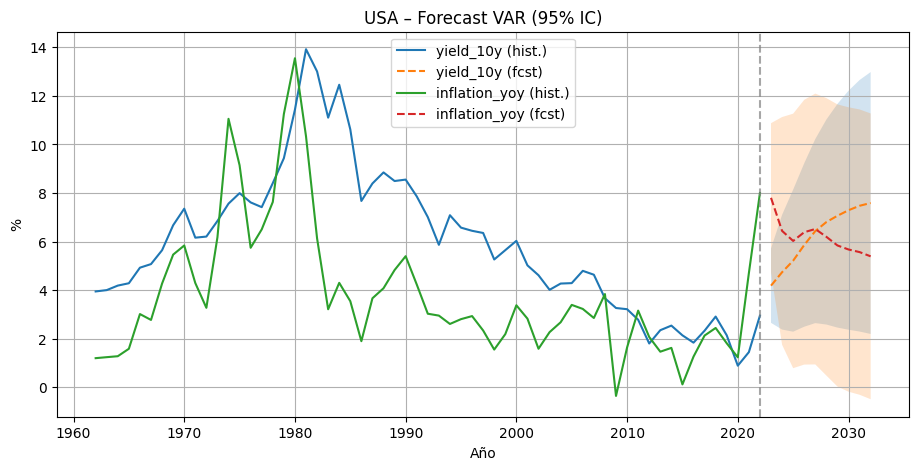


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.860953       0.139047
2     0.672574       0.327426
3     0.571081       0.428919
4     0.513006       0.486994
5     0.461214       0.538786
6     0.415154       0.584846
7     0.380437       0.619563
8     0.355117       0.644883
9     0.335671       0.664329

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.210270       0.789730
1     0.192578       0.807422
2     0.154725       0.845275
3     0.146232       0.853768
4     0.141077       0.858923
5     0.138470       0.861530
6     0.133939       0.866061
7     0.132624       0.867376
8     0.132270       0.867730
9     0.132055       0.867945


None


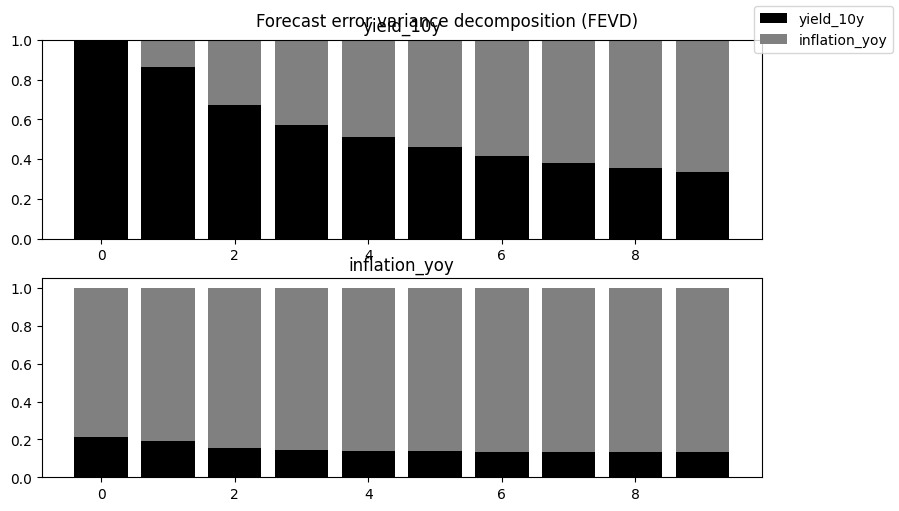


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         8.316          2.694   0.000 (3, np.int64(102))
--------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         1.451          2.694   0.232 (3, np.int64(102))
--------------------------------------------------------


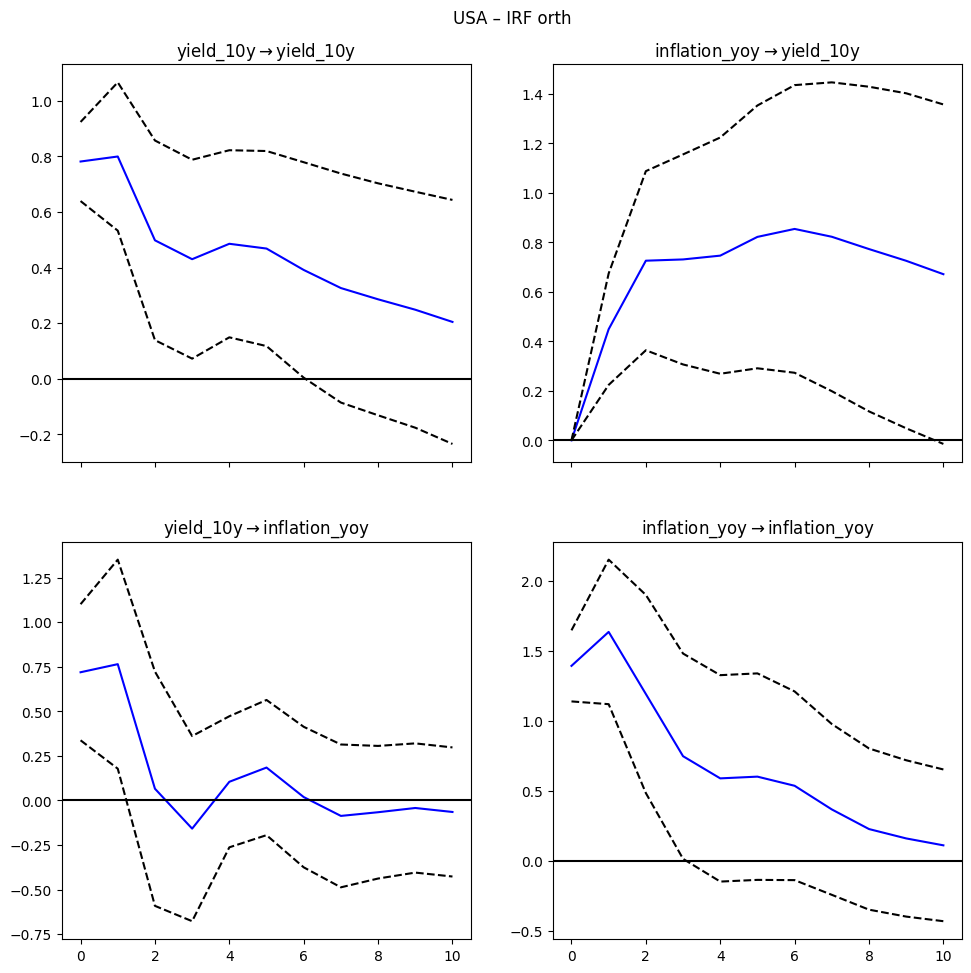

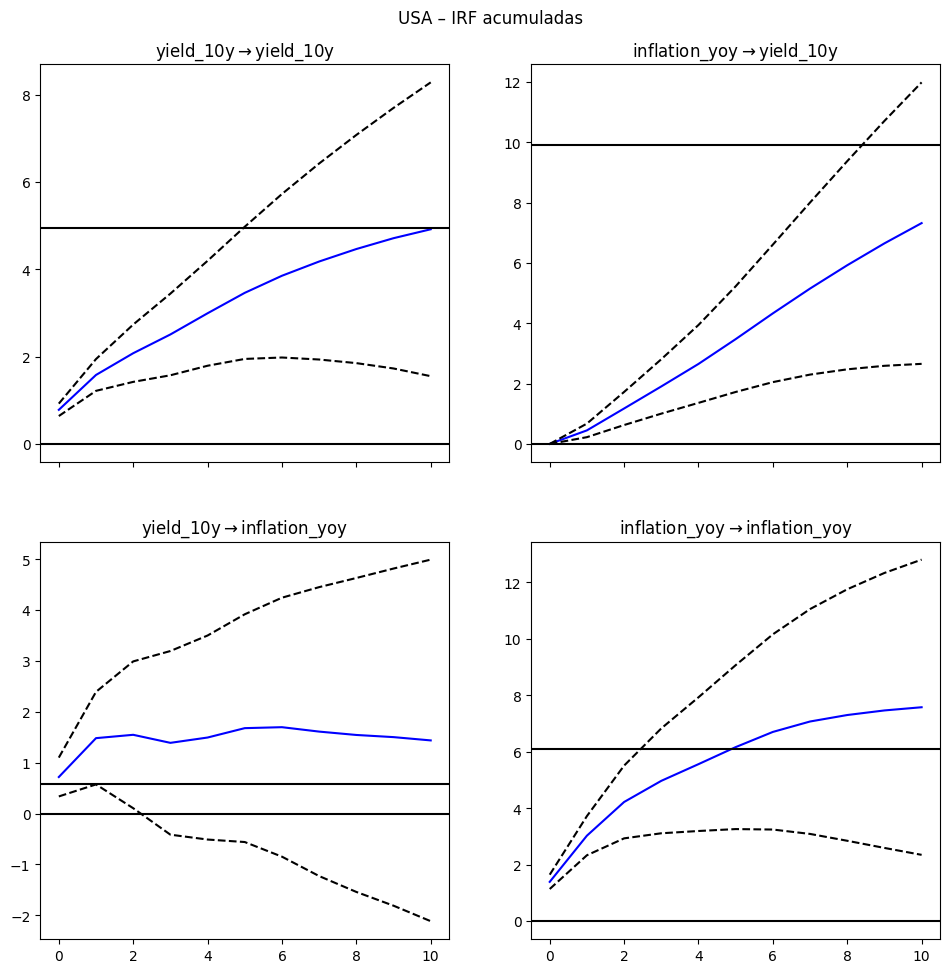

Lag elegido (AIC): 3


In [26]:
usa_results, usa_fcst, usa_fevd, usa_irf, usa_bestlag = run_country_pipeline_auto(
    df_usa, country_name="USA", steps=10, maxlags=8, crit="aic"
)
print("Lag elegido (AIC):", usa_bestlag)


## Detectar la columna 10Y de Alemania en yields.csv

In [27]:
# Cargar si no esta ya en memoria:
yields = pd.read_csv("data/raw_data/yields.csv")

# columnas 10Y tipo 'US10', 'DE10', etc.
ten_cols = [c for c in yields.columns if re.fullmatch(r"[A-Z]{2}\d{2}", c) and c.endswith("10")]
print("10Y detectadas (primeras 30):", ten_cols[:30])

# Intento autom√°tico para Alemania
candidatos_de = [c for c in ten_cols if c.startswith(("DE","GE","BD","GM"))]
print("Candidatos Alemania:", candidatos_de)

# Si aparece 'DE10', √∫sala; si no, toma el primer candidato que salga.
col_de = "DE10" if "DE10" in ten_cols else (candidatos_de[0] if candidatos_de else None)
print("Columna usada para Alemania 10Y:", col_de)


10Y detectadas (primeras 30): ['AU10', 'BE10', 'CA10', 'CN10', 'DK10', 'FR10', 'DE10', 'GR10', 'HK10', 'IN10', 'ID10', 'IE10', 'IT10', 'JP10', 'KR10', 'MY10', 'NL10', 'NZ10', 'NO10', 'PL10', 'PT10', 'SG10', 'ZA10', 'ES10', 'SE10', 'TW10', 'TH10', 'TR10', 'GB10', 'US10']
Candidatos Alemania: ['DE10']
Columna usada para Alemania 10Y: DE10


## Anualizar yields USA + Alemania

In [28]:
yields_yr = yields.copy()
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

col_us = "US10"   # USA 10Y
col_de = "DE10"   # Alemania 10Y

y_ann = (
    yields_yr[['Year', col_us, col_de]]
      .groupby('Year', as_index=False)
      .mean()
      .rename(columns={col_us:'yield_10y_US', col_de:'yield_10y_DE'})
)


## Inflaci√≥n del Banco Mundial (USA + Alemania)

In [29]:
wb = pd.read_csv('data/raw_data/world_bank_data_2025.csv')

wb_small = wb.rename(columns={
    'country_name':'Country',
    'year':'Year',
    'Inflation (CPI %)':'inflation_yoy'
})[['Country','Year','inflation_yoy']].dropna()

infl_us = wb_small.query("Country == 'United States'")[['Year','inflation_yoy']].rename(columns={'inflation_yoy':'inflation_yoy_US'})
infl_de = wb_small.query("Country == 'Germany'")[['Year','inflation_yoy']].rename(columns={'inflation_yoy':'inflation_yoy_DE'})


## Construir datasets y lanzar el pipeline

### Carga el CSV de Alemania

In [30]:
# === 1) Cargar CSV Alemania desde FRED ===
de_raw = pd.read_csv('data/raw_data/IRLTLT01DEM156N.csv')

# Normalizar columnas
de_raw['observation_date'] = pd.to_datetime(de_raw['observation_date'], errors='coerce')
de_raw = de_raw.rename(columns={'IRLTLT01DEM156N':'yield_10y'})

# === 2) Pasar de mensual ‚Üí anual (promedio) ===
de_annual = de_raw.set_index('observation_date').resample('YE').mean()
de_annual.index = de_annual.index.year
de_annual.index.name = 'Year'
de_annual = de_annual.reset_index()

print("Alemania yields anuales:", de_annual['Year'].min(), "‚Üí", de_annual['Year'].max())
display(de_annual.head())

# === 3) Inflaci√≥n Alemania desde World Bank ===
wb_small = wb.rename(columns={
    'country_name':'Country',
    'year':'Year',
    'Inflation (CPI %)':'inflation_yoy'
})[['Country','Year','inflation_yoy']].dropna()

infl_de = wb_small.query("Country == 'Germany'")[['Year','inflation_yoy']]

# === 4) Merge yields + inflaci√≥n ===
df_germany = (
    de_annual.merge(infl_de, on='Year', how='inner')
             .set_index('Year').sort_index()
)

print("Alemania combinado:", df_germany.index.min(), "‚Üí", df_germany.index.max())
display(df_germany.tail())


Alemania yields anuales: 1956 ‚Üí 2025


Year  yield_10y
0  1956   6.912500
1  1957   7.516667
2  1958   6.783333
3  1959   5.766667
4  1960   6.425000

Alemania combinado: 2010 ‚Üí 2024


yield_10y  inflation_yoy
Year                          
2020  -0.511024       0.144878
2021  -0.373821       3.066667
2022   1.142583       6.872574
2023   2.434599       5.946437
2024   2.321084       2.256498

## Alemania: cortar a 2010‚Äì2024 y correr el

[Germany] N=15 | maxlags sugerido=3

[Germany (2010‚Äì2024)] Rezagos √≥ptimos por AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.618713
Nobs:                     14.0000    HQIC:                 -0.917947
Log likelihood:          -27.4821    FPE:                   0.415156
AIC:                    -0.892594    Det(Omega_mle):        0.281559
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.166027         0.219234           -0.757           0.449
L1.yield_10y             0.612594      

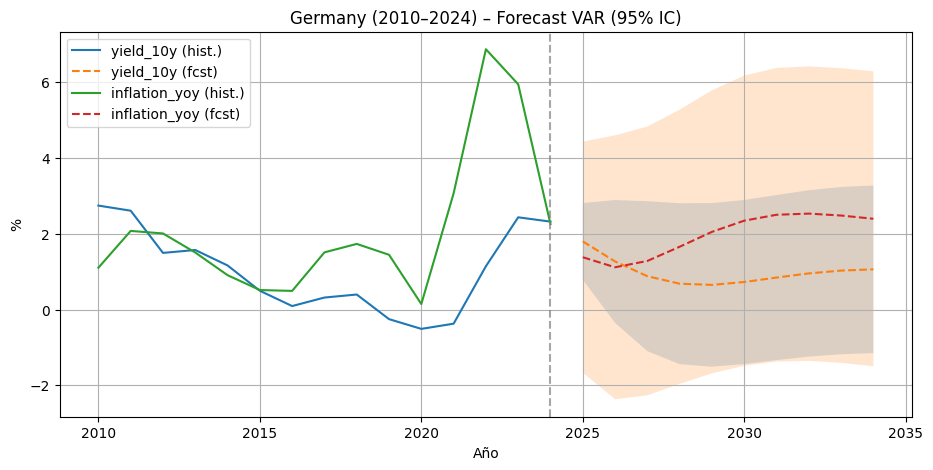


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.910424       0.089576
2     0.836596       0.163404
3     0.791540       0.208460
4     0.772434       0.227566
5     0.770204       0.229796
6     0.772758       0.227242
7     0.773377       0.226623
8     0.771993       0.228007
9     0.770538       0.229462

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.563252       0.436748
1     0.502239       0.497761
2     0.485512       0.514488
3     0.505551       0.494449
4     0.527701       0.472299
5     0.536082       0.463918
6     0.535563       0.464437
7     0.533641       0.466359
8     0.533380       0.466620
9     0.534259       0.465741


None


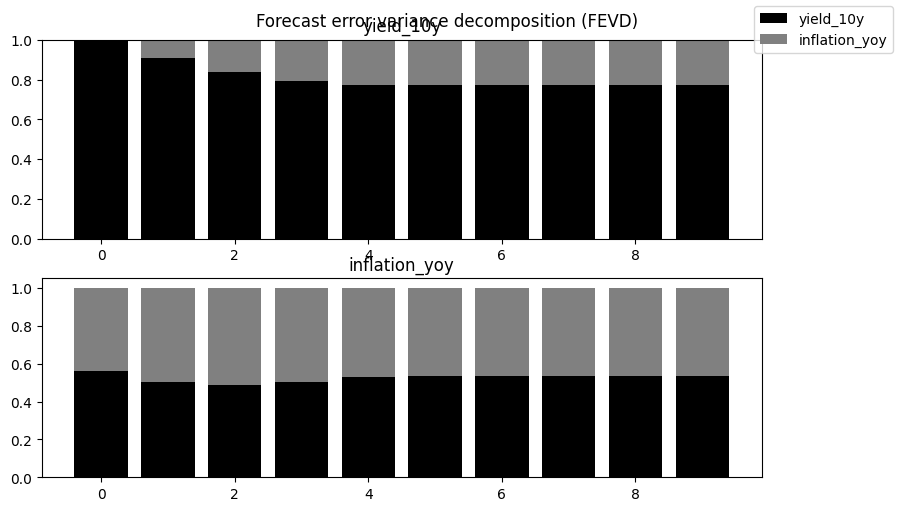


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
         9.983          4.301   0.005 (1, np.int64(22))
-------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
         2.602          4.301   0.121 (1, np.int64(22))
-------------------------------------------------------


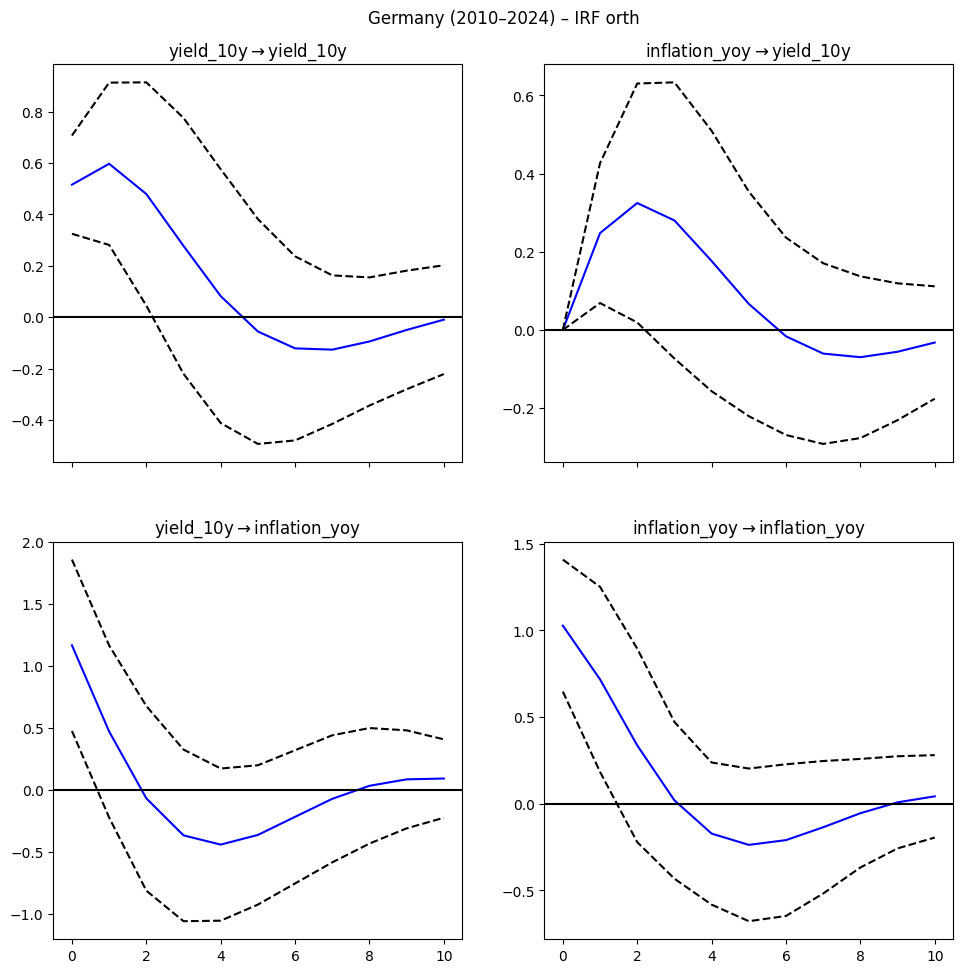

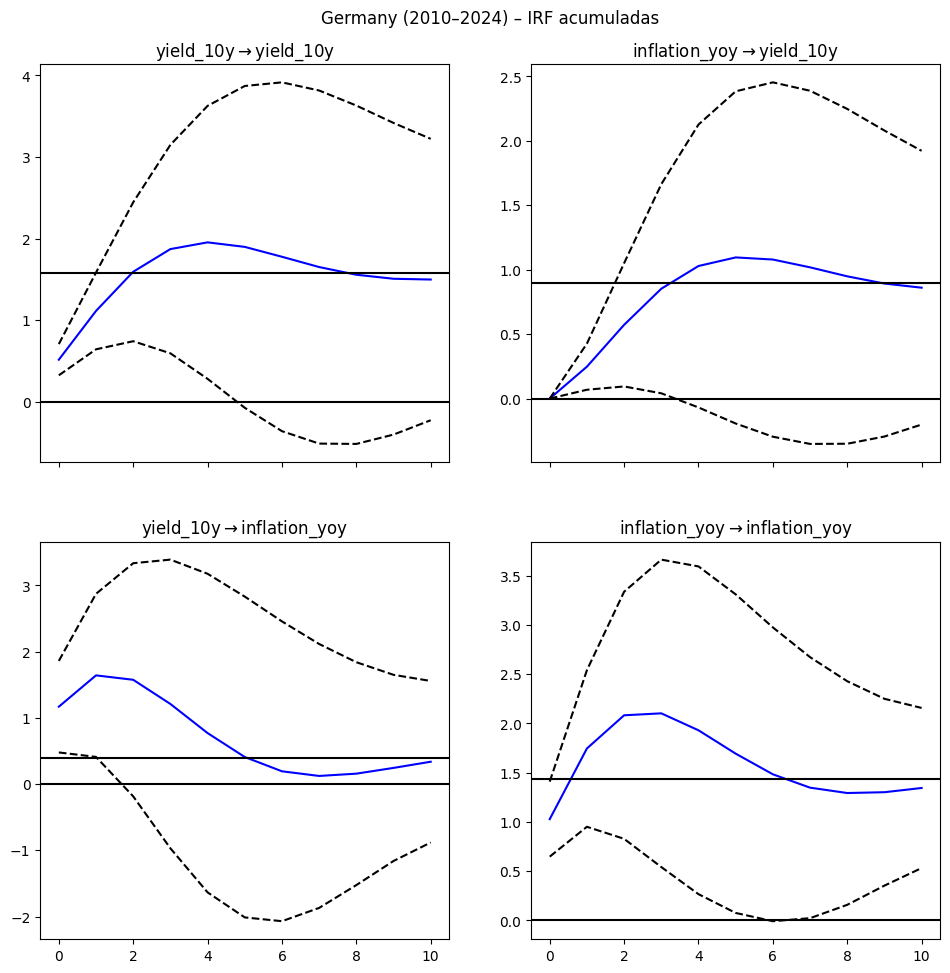

Germany (2010‚Äì2024) ‚Äì lag elegido: 1


In [31]:
# --- Alemania 2010‚Äì2024 ---
df_germany_2010_24 = df_germany.loc[2010:2024].copy()

N = len(df_germany_2010_24)
safe_maxlags = max(1, min(3, (N - 3)//2))   # con ~15 a√±os suele salir 1‚Äì2
print(f"[Germany] N={N} | maxlags sugerido={safe_maxlags}")

de_res, de_fcst, de_fevd, de_irf, de_bestlag = run_country_pipeline_auto(
    df_germany_2010_24, country_name="Germany (2010‚Äì2024)",
    steps=10, maxlags=safe_maxlags, crit="aic"
)
print("Germany (2010‚Äì2024) ‚Äì lag elegido:", de_bestlag)


## USA: mismo corte 2010‚Äì2024

In [32]:

def run_country_pipeline_auto(df, country_name, steps=5, maxlags=2, crit="aic"):
    """
    df: index=Year (int), columnas ['yield_10y','inflation_yoy']
    steps: horizonte de forecast
    maxlags: rezago m√°ximo permitido (luego se capea autom√°ticamente)
    """
    # 0) Formato y limpieza
    df = df[['yield_10y','inflation_yoy']].dropna().copy()
    df.index = df.index.astype(int)
    df = df.sort_index()

    # 1) C√°lculo de un maxlags seguro seg√∫n n¬∫ de observaciones
    N = len(df)
    k_endog = df.shape[1]  # 2
    safe_max = max(1, min(maxlags, (N - 5)//k_endog))  # cap defensivo
    if safe_max < 1:
        raise ValueError(f"Datos insuficientes (N={N}). Reduce rango de a√±os o a√±ade datos.")
    if safe_max < maxlags:
        print(f"[{country_name}] maxlags reducido de {maxlags} a {safe_max} por N={N}")

    # 2) Selecci√≥n de rezagos y ajuste
    model = VAR(df)
    sel = model.select_order(maxlags=safe_max)
    best_lag = getattr(sel, crit)
    if best_lag is None or best_lag < 1:
        best_lag = min(1, safe_max)
    print(f"\n[{country_name}] Rezagos √≥ptimos por {crit.upper()}: {best_lag}")
    res = model.fit(best_lag)
    print(res.summary())

    # 3) Diagn√≥stico robusto (Ljung‚ÄìBox con lag seguro)
    print("\n--- Diagn√≥stico ---")
    nres = len(res.resid)
    lb_lag = max(1, min(10, nres - 2, 2*best_lag))  # evita el error por tama√±os
    for col in res.resid.columns:
        if lb_lag >= 1:
            lb = acorr_ljungbox(res.resid[col].dropna(), lags=[lb_lag], return_df=True)
            print(f"Ljung-Box {col} (lag={lb_lag}): p={lb['lb_pvalue'].iloc[0]:.4f}")
        else:
            print(f"Ljung-Box {col}: saltado (muy pocas observaciones)")
    dw = durbin_watson(res.resid.values)
    for c, v in zip(res.resid.columns, dw):
        print(f"Durbin‚ÄìWatson {c}: {v:.2f}")
    print("Estabilidad:", res.is_stable(verbose=True))

    # 4) Forecast con bandas (95%)
    k = res.k_ar
    mean, low, up = res.forecast_interval(res.endog[-k:], steps=steps, alpha=0.05)
    idx_future = range(df.index.max()+1, df.index.max()+1+steps)
    f_mean = pd.DataFrame(mean, index=idx_future, columns=res.names)
    f_low  = pd.DataFrame(low,  index=idx_future, columns=res.names)
    f_up   = pd.DataFrame(up,   index=idx_future, columns=res.names)

    plt.figure(figsize=(11,5))
    for col in res.names:
        plt.plot(df.index, df[col], label=f"{col} (hist.)")
        plt.plot(f_mean.index, f_mean[col], "--", label=f"{col} (fcst)")
        plt.fill_between(f_mean.index, f_low[col], f_up[col], alpha=0.2)
    plt.axvline(df.index.max(), color="gray", linestyle="--", alpha=0.7)
    plt.title(f"{country_name} ‚Äì Forecast VAR (95% IC)")
    plt.xlabel("A√±o"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()

    # 5) FEVD
    fevd = res.fevd(steps)
    print("\n--- FEVD ---")
    print(fevd.summary())
    fevd.plot(figsize=(9,5)); plt.show()

    # 6) Causalidad de Granger
    print("\n--- Granger ---")
    print(res.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())
    print(res.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())

    # 7) IRFs (orth y acumuladas)
    irf = res.irf(steps)
    irf.plot(orth=True); plt.suptitle(f"{country_name} ‚Äì IRF orth"); plt.show()
    irf.plot_cum_effects(orth=True); plt.suptitle(f"{country_name} ‚Äì IRF acumuladas"); plt.show()

    return res, {"forecast_mean": f_mean, "forecast_low": f_low, "forecast_up": f_up}, fevd, irf, best_lag


In [33]:
df_usa_2010_24     = df_usa.loc[2010:2024].copy()
df_germany_2010_24 = df_germany.loc[2010:2024].copy()

print("USA 2010‚Äì2024:", df_usa_2010_24.index.min(), "‚Üí", df_usa_2010_24.index.max(), "| N=", len(df_usa_2010_24))
print("DE  2010‚Äì2024:", df_germany_2010_24.index.min(), "‚Üí", df_germany_2010_24.index.max(), "| N=", len(df_germany_2010_24))


USA 2010‚Äì2024: 2010 ‚Üí 2022 | N= 13
DE  2010‚Äì2024: 2010 ‚Üí 2024 | N= 15



[USA (2010‚Äì2024)] Rezagos √≥ptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.878916
Nobs:                     11.0000    HQIC:                  -1.46865
Log likelihood:          -14.3931    FPE:                   0.333817
AIC:                     -1.24064    Det(Omega_mle):        0.157781
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    2.996691         0.820944            3.650           0.000
L1.yield_10y             0.380733         0.296424            1.284           0

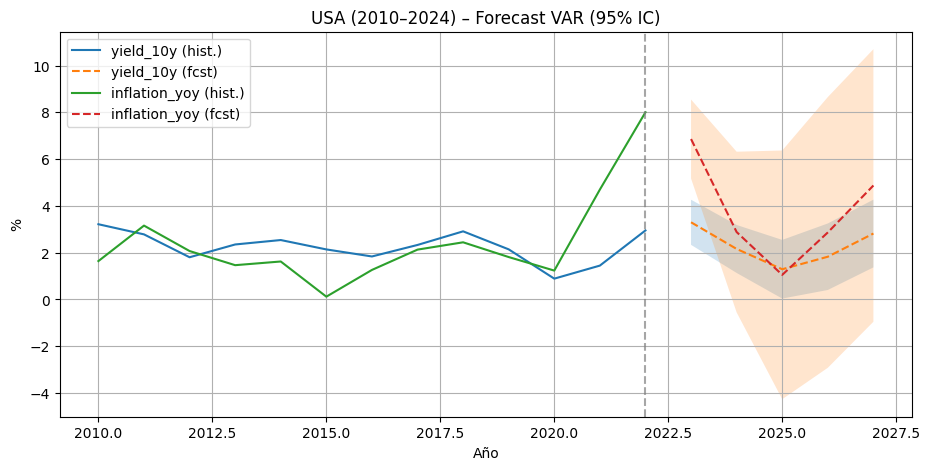


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.994611       0.005389
2     0.992842       0.007158
3     0.994395       0.005605
4     0.992982       0.007018

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.121961       0.878039
1     0.563654       0.436346
2     0.774076       0.225924
3     0.801457       0.198543
4     0.803017       0.196983


None


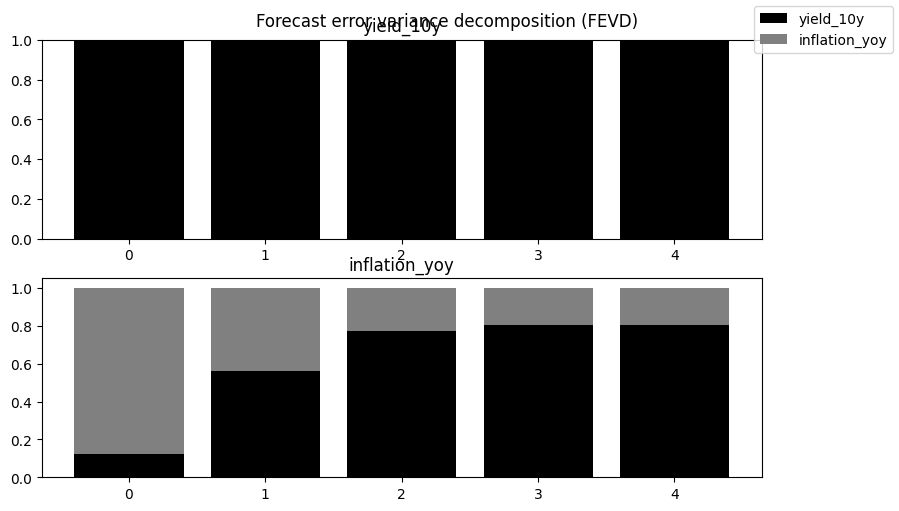


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
       0.05184          3.885   0.950 (2, np.int64(12))
-------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
         13.48          3.885   0.001 (2, np.int64(12))
-------------------------------------------------------


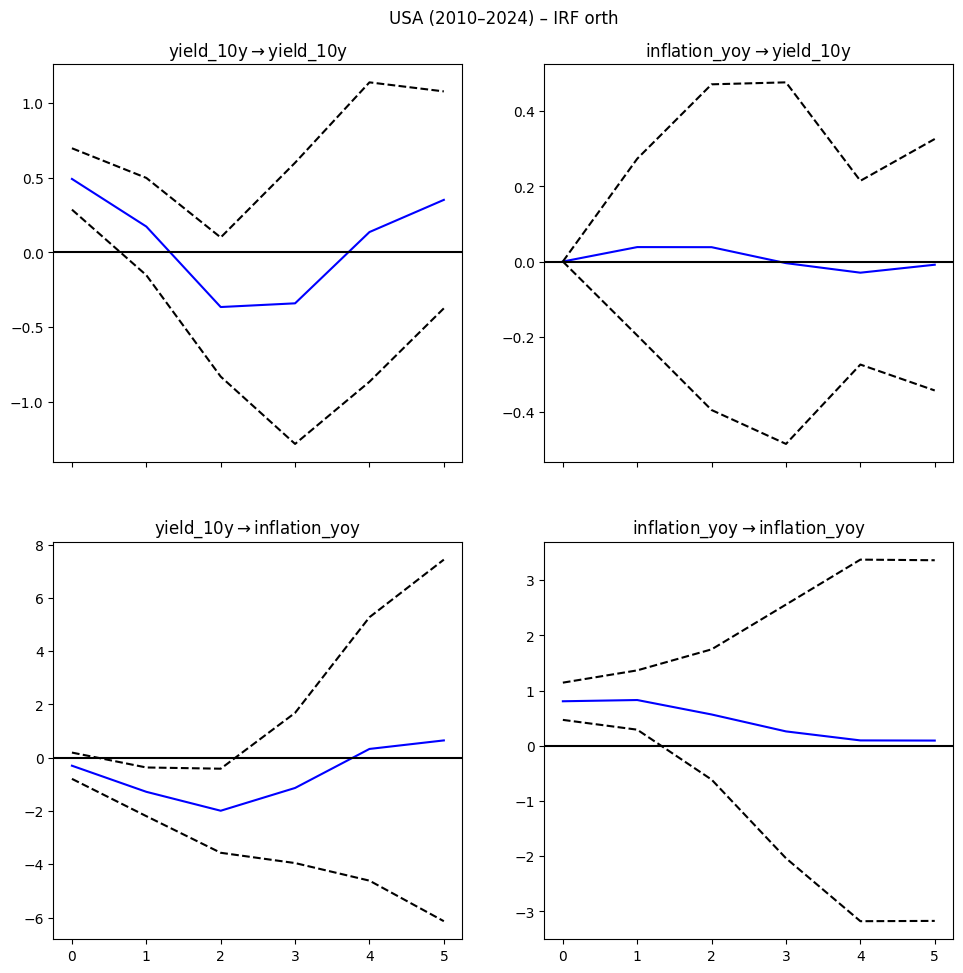

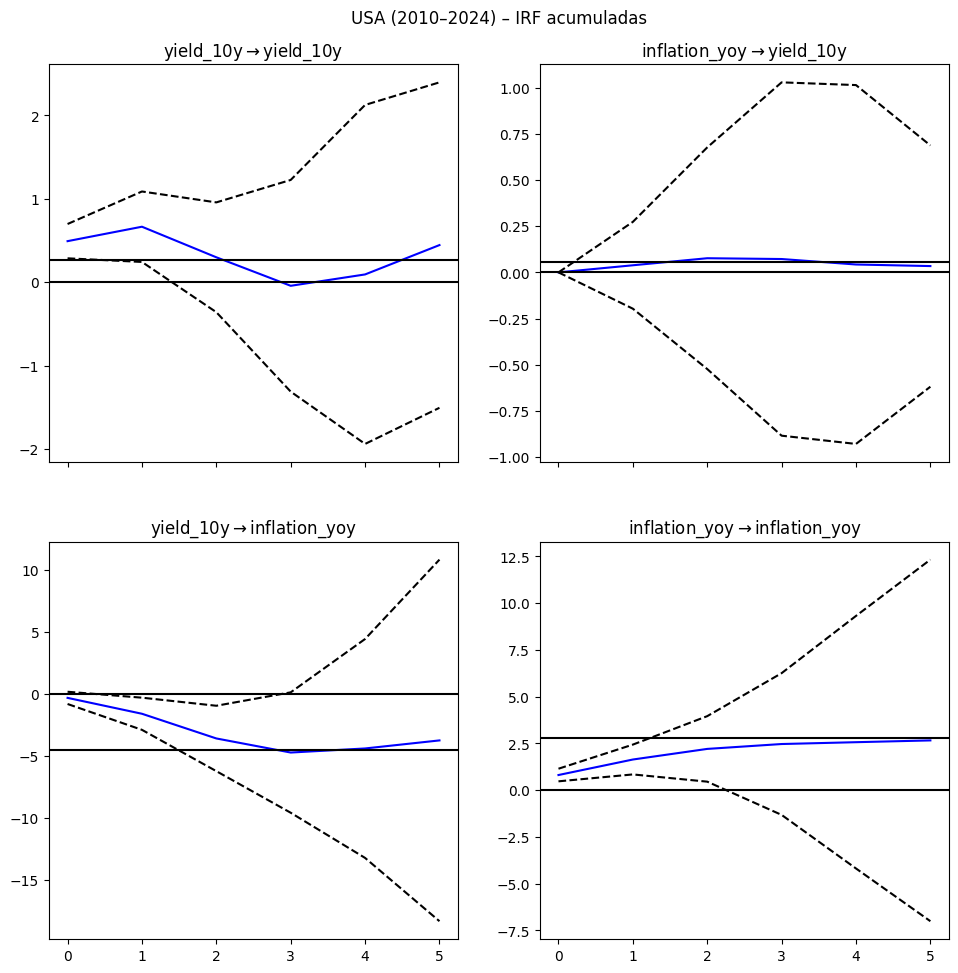

USA (2010‚Äì2024) ‚Äì lag elegido: 2


In [34]:
# USA
us_res, us_fcst, us_fevd, us_irf, us_bestlag = run_country_pipeline_auto(
    df_usa_2010_24, country_name="USA (2010‚Äì2024)", steps=5, maxlags=2, crit="aic"
)
print("USA (2010‚Äì2024) ‚Äì lag elegido:", us_bestlag)

In [35]:
assert {'yield_10y','inflation_yoy'}.issubset(df_usa.columns), "df_usa no tiene las columnas correctas"
df_usa_2010_24 = df_usa.loc[2010:2024].copy()
print("Rango USA recortado:", df_usa_2010_24.index.min(), "‚Üí", df_usa_2010_24.index.max(), "| N=", len(df_usa_2010_24))
print(df_usa_2010_24.head(), "\n", df_usa_2010_24.tail())


Rango USA recortado: 2010 ‚Üí 2022 | N= 13
      yield_10y  inflation_yoy
Year                          
2010    3.21506       1.640043
2011    2.78164       3.156842
2012    1.80344       2.069337
2013    2.35016       1.464833
2014    2.53956       1.622223 
       yield_10y  inflation_yoy
Year                          
2018   2.911245       2.442583
2019   2.141400       1.812210
2020   0.889203       1.233584
2021   1.446853       4.697859
2022   2.950562       8.002800


In [36]:
# A√±os disponibles en cada fuente (USA)
print("Yields USA (y_ann):", y_ann[['Year','yield_10y_US']].dropna()['Year'].min(), "‚Üí", y_ann[['Year','yield_10y_US']].dropna()['Year'].max())
print("Inflaci√≥n USA (infl_us):", infl_us['Year'].min(), "‚Üí", infl_us['Year'].max())

# Qu√© a√±os faltan en cada una dentro de 2010‚Äì2024
yrs = set(range(2010, 2025))
y_ok  = set(y_ann.loc[y_ann['yield_10y_US'].notna(), 'Year'])
i_ok  = set(infl_us['Year'])
print("Faltan en yields:", sorted(yrs - y_ok))
print("Faltan en inflaci√≥n:", sorted(yrs - i_ok))


Yields USA (y_ann): 1970 ‚Üí 2020
Inflaci√≥n USA (infl_us): 2010 ‚Üí 2024
Faltan en yields: [2021, 2022, 2023, 2024]
Faltan en inflaci√≥n: []


## Anualizar DGS10 y crear Year

In [37]:
# Cargar CSV DGS10 (tiene columnas: observation_date, DGS10)
dgs = pd.read_csv('data/raw_data/DGS10.csv')

# Limpiar tipos
dgs["observation_date"] = pd.to_datetime(dgs["observation_date"], errors="coerce")
dgs["DGS10"] = pd.to_numeric(dgs["DGS10"], errors="coerce")
dgs = dgs.dropna(subset=["observation_date", "DGS10"]).sort_values("observation_date")

# Resample anual (promedio) y crear Year de forma expl√≠cita
dgs_ann = (
    dgs.set_index("observation_date")
       .resample("YE").mean()                  # promedio anual
       .assign(Year=lambda x: x.index.year)    # crear Year desde el √≠ndice
       .reset_index(drop=True)[["Year", "DGS10"]]
       .rename(columns={"DGS10": "yield_10y"})
)

# Filtrar 2021‚Äì2024 (o lo que tengas)
dgs_ann = dgs_ann.query("Year >= 2021").copy()

print(dgs_ann.head())


   Year  yield_10y
1  2021   1.446853
2  2022   2.950562
3  2023   3.959000
4  2024   4.207960
5  2025   4.392437


## Unir con tu serie USA previa

In [38]:
# Recalcular US10 anual (hasta 2020) desde tu yields.csv
yields_yr = yields.copy()
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

us10_ann_old = (
    yields_yr.groupby('Year')['US10'].mean()
             .rename('yield_10y')
             .reset_index()
)

print("US10 anualizado (hasta 2020):")
print(us10_ann_old.tail())


US10 anualizado (hasta 2020):
    Year  yield_10y
46  2016   1.833551
47  2017   2.328483
48  2018   2.915869
49  2019   2.138607
50  2020   0.978000


In [39]:
# us10_ann_old: tu serie hist√≥rica hasta 2020 (Year, yield_10y)
us10_full = (
    pd.concat([us10_ann_old, dgs_ann], ignore_index=True)
      .sort_values("Year")
      .drop_duplicates("Year", keep="last")
      .reset_index(drop=True)
)

print(us10_full.tail(15))


    Year  yield_10y
41  2011   2.762909
42  2012   1.788892
43  2013   2.341008
44  2014   2.529388
45  2015   2.133728
46  2016   1.833551
47  2017   2.328483
48  2018   2.915869
49  2019   2.138607
50  2020   0.978000
51  2021   1.446853
52  2022   2.950562
53  2023   3.959000
54  2024   4.207960
55  2025   4.392437


## Construir df_usa_2010_24 para el VAR

In [40]:
# nos aseguramos de tener infl_us: (Year, inflation_yoy)
df_usa_2010_24 = (
    us10_full.merge(infl_us, on="Year", how="inner")
             .query("Year >= 2010 and Year <= 2024")
             .set_index("Year")
             .sort_index()
             .dropna()
)

print(df_usa_2010_24.tail(10))


      yield_10y  inflation_yoy_US
Year                             
2015   2.133728          0.118627
2016   1.833551          1.261583
2017   2.328483          2.130110
2018   2.915869          2.442583
2019   2.138607          1.812210
2020   0.978000          1.233584
2021   1.446853          4.697859
2022   2.950562          8.002800
2023   3.959000          4.116338
2024   4.207960          2.949525


## USA (2015‚Äì2024) ‚Äì VAR robusto con cap autom√°tico de lags

[USA 2015‚Äì2024] N=10
Rezago √≥ptimo (AIC, cap=2): 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.658256
Nobs:                     8.00000    HQIC:                  -1.42731
Log likelihood:          -9.67278    FPE:                   0.722611
AIC:                    -0.757558    Det(Omega_mle):        0.273652
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    4.597791         1.559055            2.949           0.003
L1.yield_10y             0.874699         0.373774            2.340       

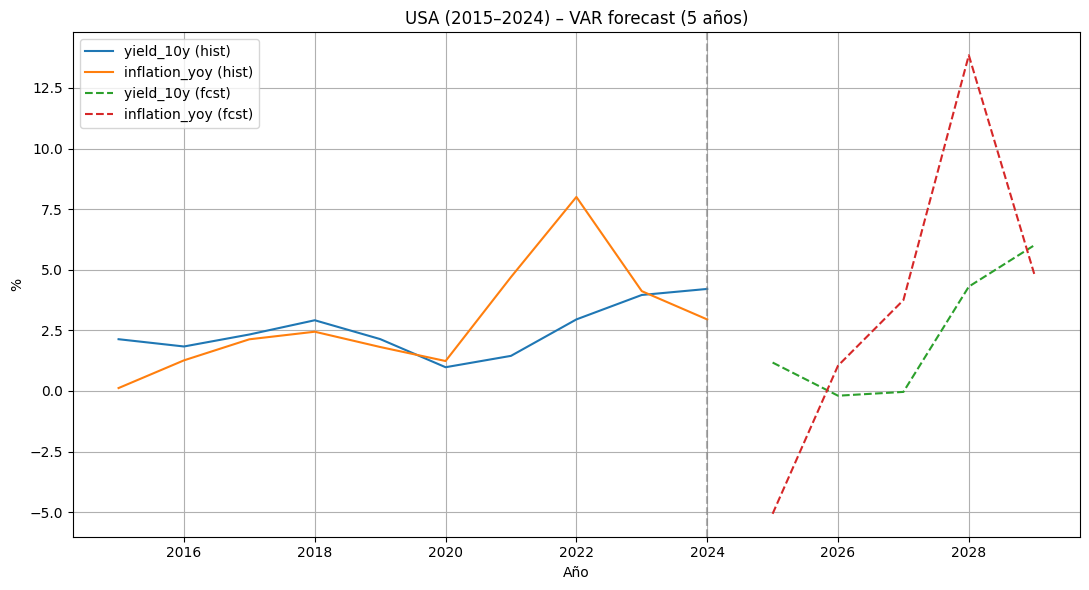

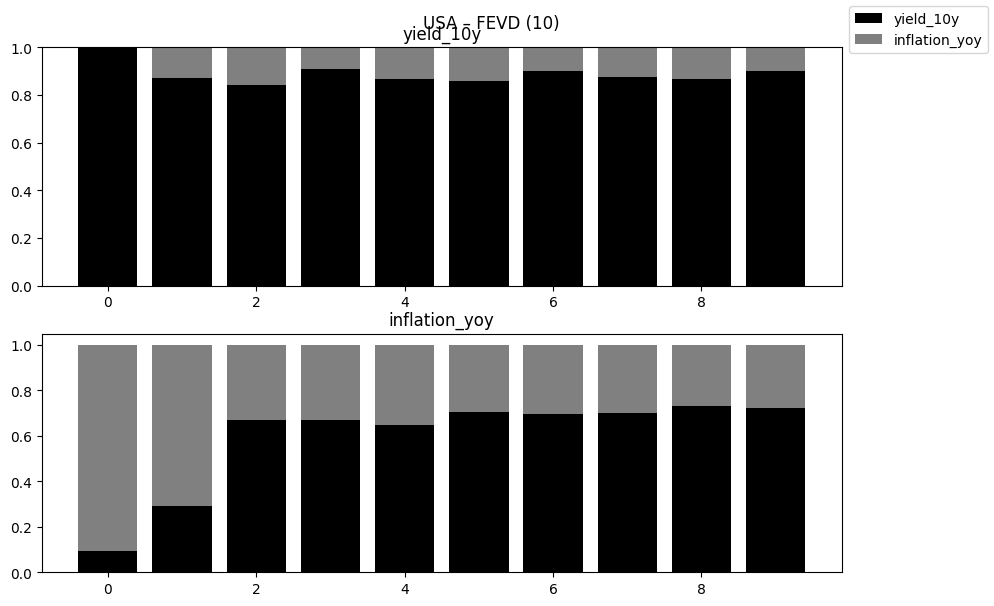

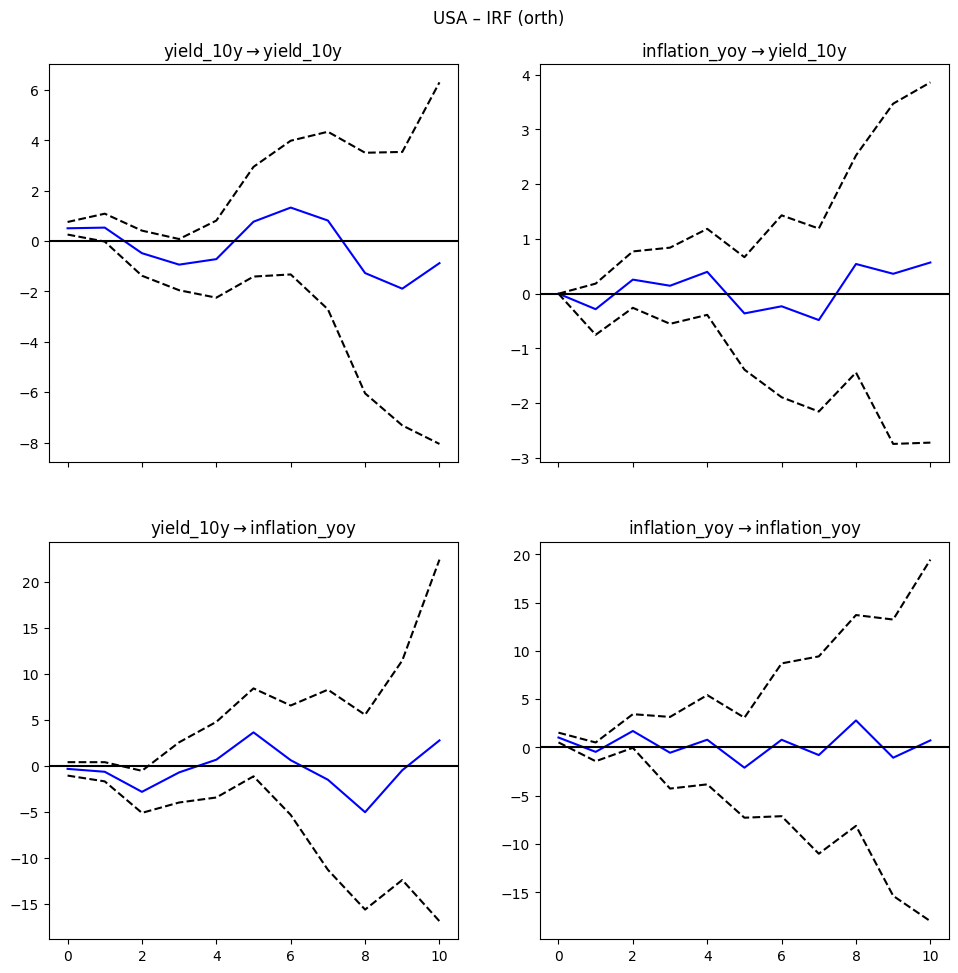

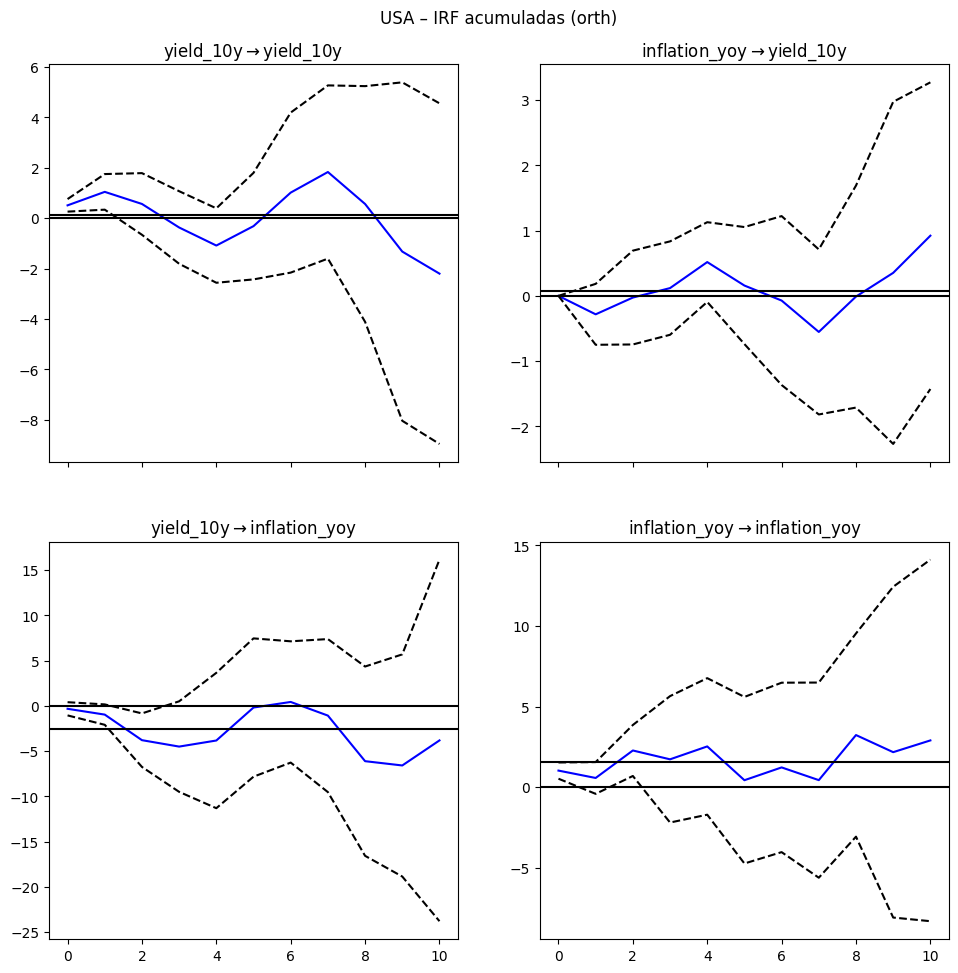

In [41]:
# Usamos (√≠ndice Year, cols: yield_10y, inflation_yoy[_US])
df_us = df_usa_2015_24.copy() if 'df_usa_2015_24' in globals() else df_usa_2010_24.loc[2015:2024].copy()
if 'inflation_yoy_US' in df_us.columns:
    df_us = df_us.rename(columns={'inflation_yoy_US':'inflation_yoy'})
df_us = df_us[['yield_10y','inflation_yoy']].dropna().sort_index()
df_us.index = df_us.index.astype(int)

N, k = len(df_us), 2
print(f"[USA 2015‚Äì2024] N={N}")

# --- Selecci√≥n de rezagos robusta ---
# Cap muy prudente con muestras cortas:
max_try = max(1, min(2, (N-5)//k))  # con N~10 esto da 1‚Äì2
best_lag = None
last_err = None

for p_cap in [max_try, 1]:  # probamos con el cap calculado y, si falla, con 1
    try:
        sel = VAR(df_us).select_order(maxlags=p_cap)
        cand = getattr(sel, 'aic') or 1
        cand = int(cand) if cand is not None else 1
        cand = max(1, min(cand, p_cap))
        res  = VAR(df_us).fit(cand)
        best_lag = cand
        break
    except Exception as e:
        last_err = e
        continue

if best_lag is None:
    raise last_err

print(f"Rezago √≥ptimo (AIC, cap={p_cap}): {best_lag}")
print(res.summary())

# --- Diagn√≥stico robusto ---
lb_lag = max(1, min(5, N - 2, 2*best_lag))
print("\n--- Diagn√≥stico ---")
for col in res.resid.columns:
    lb = acorr_ljungbox(res.resid[col].dropna(), lags=[lb_lag], return_df=True)
    print(f"Ljung-Box {col} (lag={lb_lag})  p={lb['lb_pvalue'].iloc[0]:.3f}")
dw_vals = durbin_watson(res.resid.values)
print("Durbin‚ÄìWatson:", {c: round(dw,2) for c, dw in zip(res.resid.columns, dw_vals)})
print("Estabilidad:", res.is_stable(verbose=True))

# --- Forecast (5 a√±os, sin IC para N peque√±o) ---
steps = 5
yhat = res.forecast(df_us.values[-best_lag:], steps=steps)
years_fc = np.arange(df_us.index.max()+1, df_us.index.max()+steps+1)
fc_df = pd.DataFrame(yhat, columns=df_us.columns, index=years_fc)

plt.figure(figsize=(11,6))
plt.plot(df_us.index, df_us['yield_10y'], label='yield_10y (hist)')
plt.plot(df_us.index, df_us['inflation_yoy'], label='inflation_yoy (hist)')
plt.plot(fc_df.index, fc_df['yield_10y'], '--', label='yield_10y (fcst)')
plt.plot(fc_df.index, fc_df['inflation_yoy'], '--', label='inflation_yoy (fcst)')
plt.axvline(x=df_us.index.max(), color='grey', ls='--', alpha=0.6)
plt.title('USA (2015‚Äì2024) ‚Äì VAR forecast (5 a√±os)')
plt.xlabel('A√±o'); plt.ylabel('%'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# --- FEVD e IRFs (10 pasos) ---
fevd = res.fevd(10); fig = fevd.plot(figsize=(10,6)); fig.suptitle('USA ‚Äì FEVD (10)'); plt.show()
irf = res.irf(10); fig1 = irf.plot(orth=True); fig1.suptitle('USA ‚Äì IRF (orth)'); plt.show()
fig2 = irf.plot_cum_effects(orth=True); fig2.suptitle('USA ‚Äì IRF acumuladas (orth)'); plt.show()


## Comparativa Alemania vs USA (2010‚Äì2024)

### üá©üá™ Alemania

Yields 10Y: en m√≠nimos hist√≥ricos, incluso negativos 2016‚Äì2020.

Inflaci√≥n: fuerte repunte desde 2021 por crisis energ√©tica y guerra en Ucrania.

Relaci√≥n: shocks de inflaci√≥n ‚Üí suben los yields (mercado exige m√°s rentabilidad).

### üá∫üá∏ Estados Unidos

Yields 10Y: bajan fuerte en 2020 (COVID), suben r√°pido hasta 2024.

Inflaci√≥n: pico hist√≥rico en 2022 (8%) tras pandemia y energ√≠a.

Relaci√≥n: inflaci√≥n explica gran parte de la variabilidad de yields; modelo algo inestable por pocos datos.

### üîé Conclusi√≥n

Inflaci√≥n lidera, yields siguen en ambos pa√≠ses.

Alemania vivi√≥ rendimientos negativos (BCE muy expansiva), USA nunca baj√≥ de 0.8% (Fed menos agresiva).

Dos respuestas distintas a choques globales, pero misma direcci√≥n: m√°s inflaci√≥n = yields m√°s altos.

## SPAIN (2010‚Äì2024) ‚Äì Pipeline


Spain ‚Äì rango disponible tras merge: 2010 ‚Üí 2020 | N = 11


yield_10y  inflation_yoy
Year                          
2016   1.376849      -0.202598
2017   1.579914       1.956076
2018   1.431542       1.674981
2019   0.661907       0.699519
2020   0.542948      -0.322753


[Spain (2010‚Äì2024)] Rezagos √≥ptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.54469
Nobs:                     9.00000    HQIC:                  -2.23673
Log likelihood:          -7.60365    FPE:                   0.227518
AIC:                     -1.76383    Det(Omega_mle):       0.0940251
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.518045         0.510854            1.014           0.311
L1.yield_10y             1.620949         0.459329            3.529          

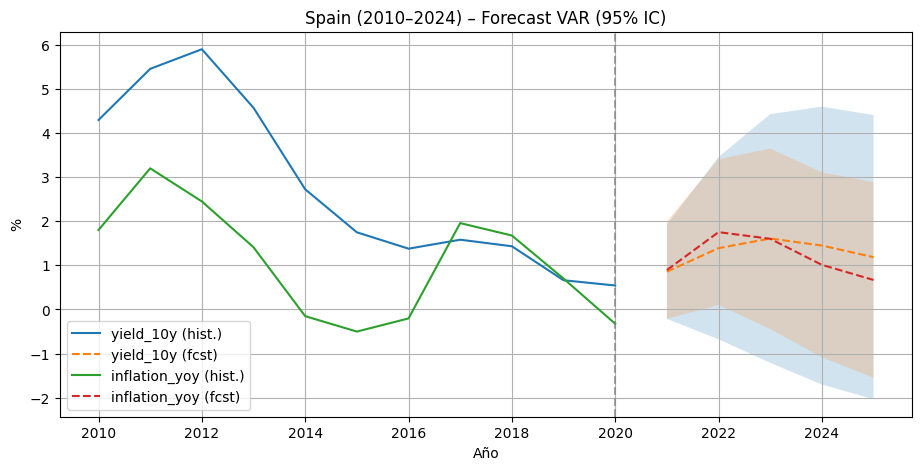


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.987052       0.012948
2     0.948565       0.051435
3     0.916358       0.083642
4     0.904776       0.095224

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.004955       0.995045
1     0.554436       0.445564
2     0.597418       0.402582
3     0.570219       0.429781
4     0.614726       0.385274


None


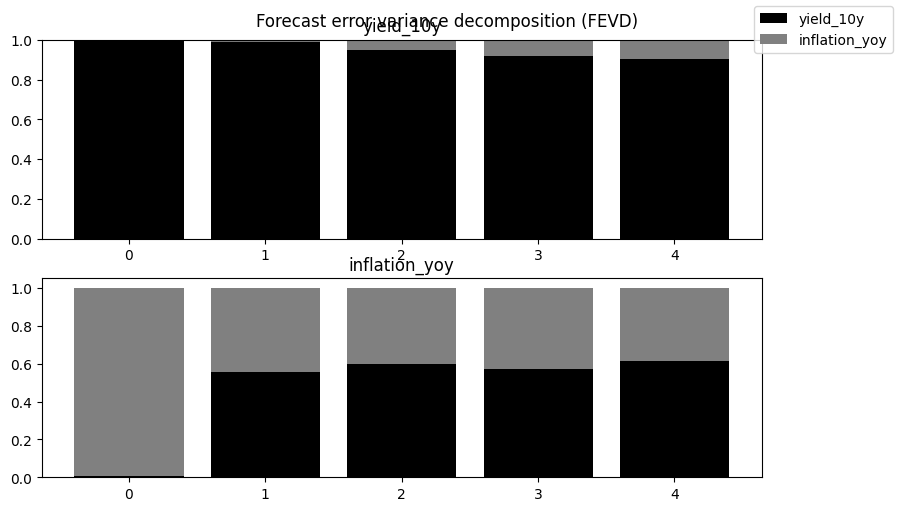


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value        df       
------------------------------------------------------
         1.108          4.459   0.376 (2, np.int64(8))
------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value        df       
------------------------------------------------------
         3.050          4.459   0.104 (2, np.int64(8))
------------------------------------------------------


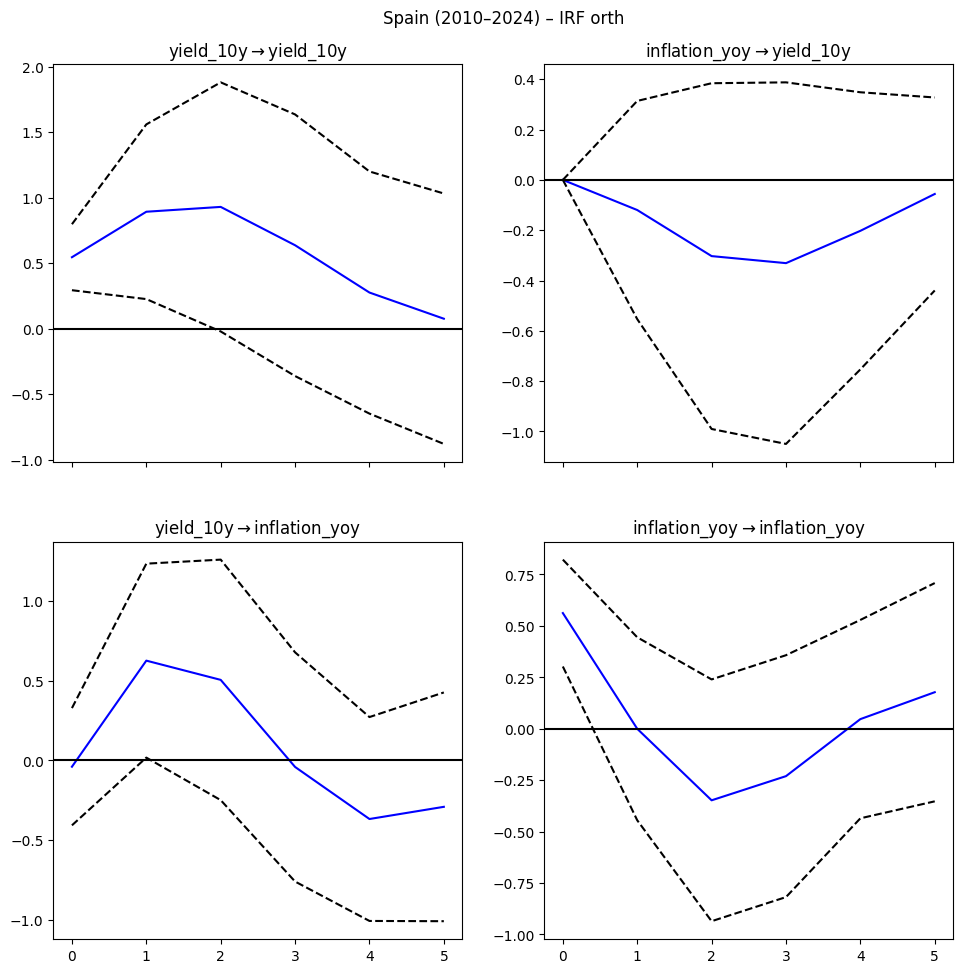

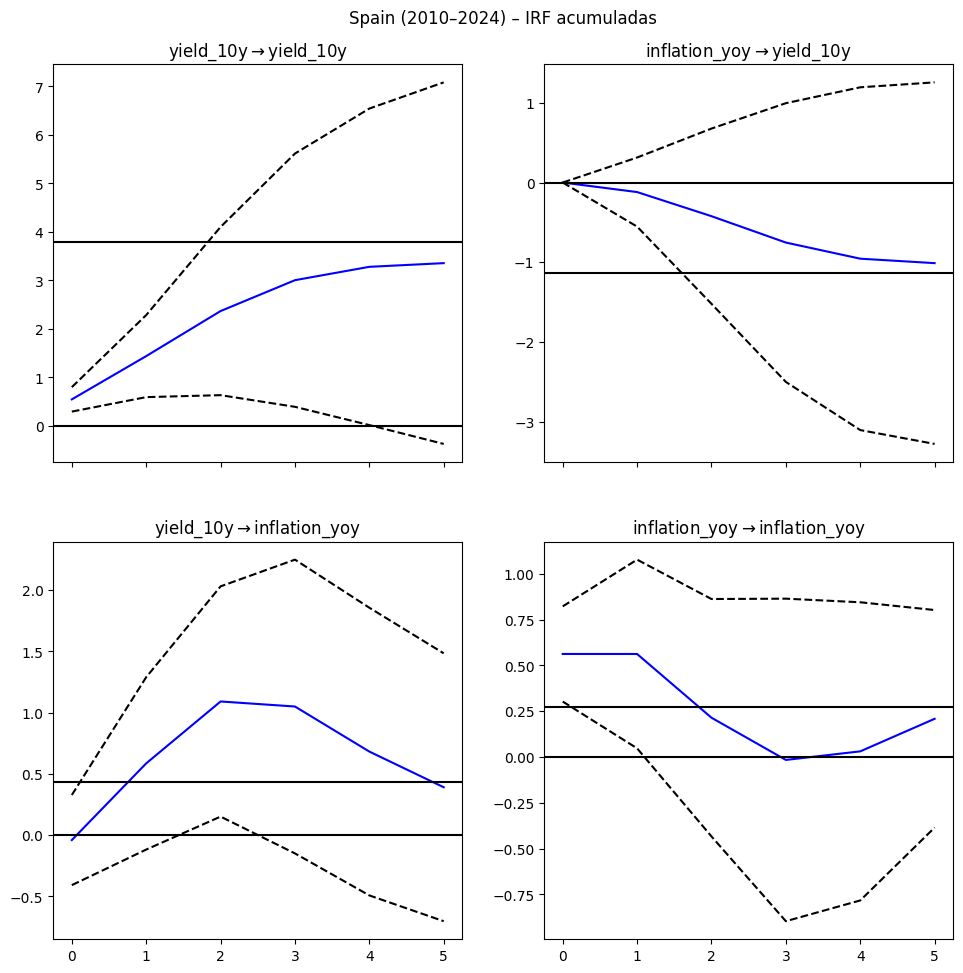

Spain (2010‚Äì2024) ‚Äì rezagos elegidos (AIC): 2


In [42]:
# ---------- 0) Cargar fuentes si faltan ----------
if 'yields' not in globals():
    # Ajusta la ruta si tu archivo no est√° en la carpeta del notebook
    yields = pd.read_csv('data/raw_data/yields.csv')
if 'wb' not in globals():
    wb = pd.read_csv('data/raw_data/world_bank_data_2025.csv')  # cambia el nombre si tu archivo difiere

# ---------- 1) Yields 10Y Espa√±a (ES10) ‚Üí anual ----------
yields_yr = yields.copy()
# 'time' suele ser epoch ms en tu fichero
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

if 'ES10' not in yields_yr.columns:
    raise RuntimeError("No encuentro la columna ES10 en yields.csv")

es10_ann = (yields_yr.groupby('Year')['ES10'].mean()
                        .rename('yield_10y')
                        .reset_index())

# ---------- 2) Inflaci√≥n Espa√±a desde World Bank (detecci√≥n robusta) ----------
cols = {c.lower(): c for c in wb.columns}
country_col = cols.get('country_name') or cols.get('country') or cols.get('country name')
year_col    = cols.get('year') or cols.get('date')

if not country_col or not year_col:
    raise RuntimeError("No encuentro columnas de pa√≠s/a√±o en el archivo WB. Revisa nombres.")

inflation_candidates = [c for c in wb.columns if "inflation" in c.lower() and "cpi" in c.lower()]
if not inflation_candidates:
    raise RuntimeError("No encuentro columna de inflaci√≥n CPI en WB (busqu√© 'inflation' y 'CPI').")
infl_col = inflation_candidates[0]

infl_es = (wb[[country_col, year_col, infl_col]]
             .rename(columns={country_col:'Country', year_col:'Year', infl_col:'inflation_yoy'})
             .query("Country == 'Spain'")
             [['Year','inflation_yoy']]
             .dropna())

# ---------- 3) Merge + recorte 2010‚Äì2024 ----------
df_spain = (es10_ann.merge(infl_es, on='Year', how='inner')
                    .set_index('Year').sort_index())
df_spain_2010_24 = df_spain.loc[2010:2024].dropna().copy()

print("Spain ‚Äì rango disponible tras merge:",
      df_spain_2010_24.index.min(), "‚Üí", df_spain_2010_24.index.max(),
      "| N =", len(df_spain_2010_24))
display(df_spain_2010_24.tail())

# ---------- 4) Ejecutar VAR (par√°metros prudentes para N~10‚Äì15) ----------
sp_res, sp_fcst, sp_fevd, sp_irf, sp_bestlag = run_country_pipeline_auto(
    df_spain_2010_24, country_name="Spain (2010‚Äì2024)", steps=5, maxlags=2, crit="aic"
)
print("Spain (2010‚Äì2024) ‚Äì rezagos elegidos (AIC):", sp_bestlag)


yield_10y ‚Üí inflation_yoy (izquierda):

Un shock positivo en los rendimientos de 10 a√±os genera un aumento inicial de la inflaci√≥n, que se estabiliza despu√©s de 3 a√±os.

La respuesta es moderada y se disipa r√°pido.

Eso sugiere que los tipos largos tienen poca capacidad de traspaso directo a la inflaci√≥n en Espa√±a en este periodo.

inflation_yoy ‚Üí inflation_yoy (derecha):

Un shock de inflaci√≥n tiende a persistir 2‚Äì3 a√±os, con efecto negativo moderado y luego recuperaci√≥n.

En otras palabras, los shocks inflacionarios en Espa√±a no son totalmente transitorios, pero tampoco se vuelven explosivos.

#### üìå Conclusi√≥n r√°pida (Espa√±a 2010‚Äì2024):

Los tipos largos no causan fuertemente la inflaci√≥n (apoyo a lo visto en Granger).

La inflaci√≥n s√≠ muestra cierta din√°mica propia (persistencia).

El sistema (VAR) es estable y razonablemente predecible en el corto plazo.

## Reino Unido üá¨üáß

#### 1. Verificar columnas de yields

In [43]:
print(yields.columns.tolist())
print(yields.head())


['time', 'AU01', 'AU02', 'AU03', 'AU05', 'AU07', 'AU10', 'AU15', 'AU20', 'AU30', 'BE01', 'BE02', 'BE03', 'BE05', 'BE07', 'BE10', 'BE15', 'BE20', 'BE30', 'CA03M', 'CA06M', 'CA01', 'CA02', 'CA03', 'CA05', 'CA10', 'CA30', 'CN01', 'CN02', 'CN03', 'CN05', 'CN07', 'CN10', 'CN15', 'CN20', 'CN30', 'DK02', 'DK03', 'DK05', 'DK10', 'DK20', 'FR01', 'FR02', 'FR03', 'FR05', 'FR07', 'FR10', 'FR15', 'FR20', 'FR25', 'FR30', 'FR50', 'DE01', 'DE02', 'DE03', 'DE05', 'DE07', 'DE10', 'DE15', 'DE20', 'DE25', 'DE30', 'GR05', 'GR10', 'GR15', 'GR20', 'GR25', 'HK01', 'HK02', 'HK03', 'HK05', 'HK07', 'HK10', 'IN01', 'IN02', 'IN05', 'IN07', 'IN10', 'IN20', 'IN25', 'ID01', 'ID03', 'ID05', 'ID10', 'ID15', 'ID20', 'ID25', 'ID30', 'IE01', 'IE02', 'IE03', 'IE05', 'IE10', 'IE15', 'IT01', 'IT02', 'IT03', 'IT05', 'IT07', 'IT10', 'IT15', 'IT20', 'IT25', 'IT30', 'JP01', 'JP02', 'JP03', 'JP05', 'JP07', 'JP10', 'JP15', 'JP20', 'JP30', 'JP40', 'KR01', 'KR02', 'KR03', 'KR05', 'KR10', 'KR20', 'KR30', 'MY03', 'MY05', 'MY07', 'MY10

#### Si el √≠ndice ya es el a√±o

In [44]:
yields = yields.reset_index().rename(columns={'index':'Year'})


## Reino Unido 

In [45]:
# 1) Rendimientos 10Y (UK)
y_uk = (
    yields[['Year','GB10']]
    .rename(columns={'GB10':'yield_10y_UK'})
    .dropna()
)

# 2) Inflaci√≥n UK
infl_uk = (
    wb_small.query("Country == 'United Kingdom'")
    [['Year','inflation_yoy']]
    .rename(columns={'inflation_yoy':'inflation_yoy_UK'})
)

# 3) Merge
df_uk = (
    y_uk.merge(infl_uk, on='Year', how='inner')
         .rename(columns={'yield_10y_UK':'yield_10y',
                          'inflation_yoy_UK':'inflation_yoy'})
         .set_index('Year').sort_index()
)

# Filtrar rango 2010‚Äì2024
df_uk = df_uk.loc[2010:2024]

print("UK rango disponible:", df_uk.index.min(), "‚Üí", df_uk.index.max(), "| N=", len(df_uk))
display(df_uk.tail())


UK rango disponible: 2010 ‚Üí 2024 | N= 15


yield_10y  inflation_yoy
Year                          
2020      4.832       0.989487
2021      4.798       2.518371
2022      4.878       7.922049
2023      4.955       6.793967
2024      4.927       3.271573

### corre el VAR y genera gr√°ficos


[UK (2010‚Äì2024)] Rezagos √≥ptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.52876
Nobs:                     13.0000    HQIC:                  -4.05266
Log likelihood:          -1.13070    FPE:                  0.0206521
AIC:                     -3.96334    Det(Omega_mle):       0.0107722
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.707709         1.151254            0.615           0.539
L1.yield_10y             0.948780         0.281608            3.369           0.

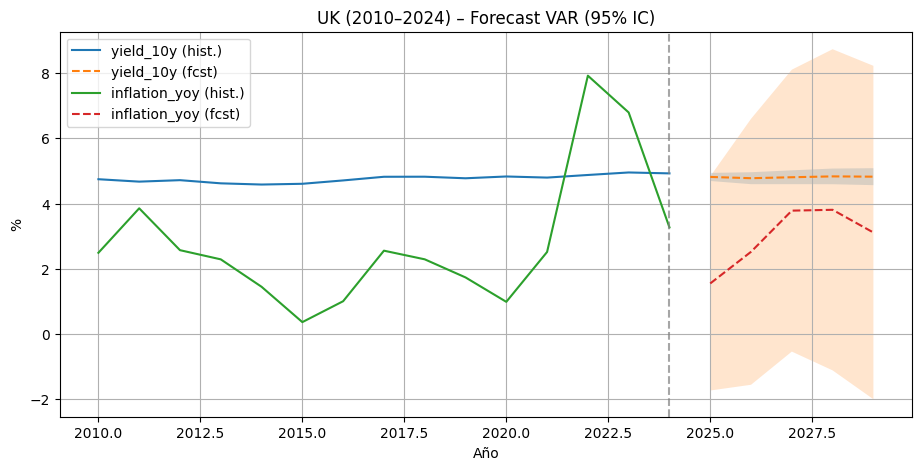


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.933427       0.066573
2     0.950076       0.049924
3     0.869631       0.130369
4     0.794479       0.205521

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.036220       0.963780
1     0.067517       0.932483
2     0.142075       0.857925
3     0.176502       0.823498
4     0.190003       0.809997


None


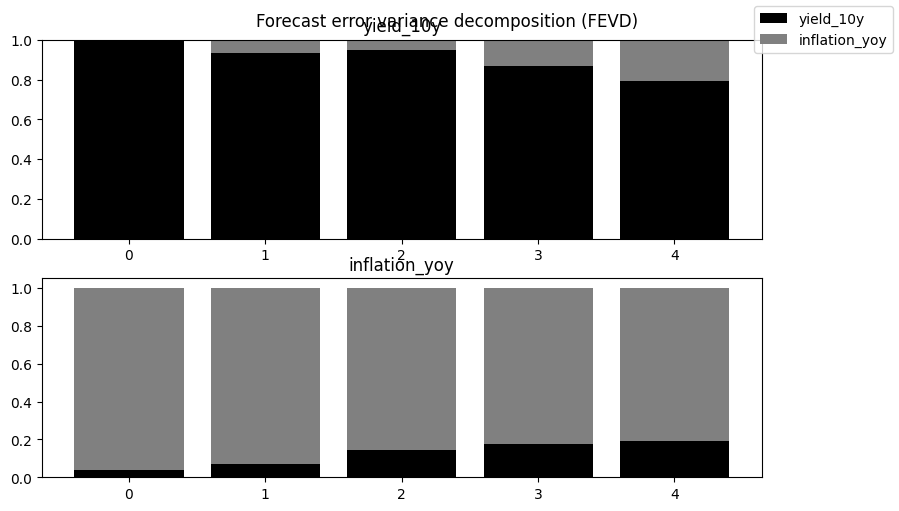


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
         2.026          3.634   0.164 (2, np.int64(16))
-------------------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df       
-------------------------------------------------------
        0.9360          3.634   0.413 (2, np.int64(16))
-------------------------------------------------------


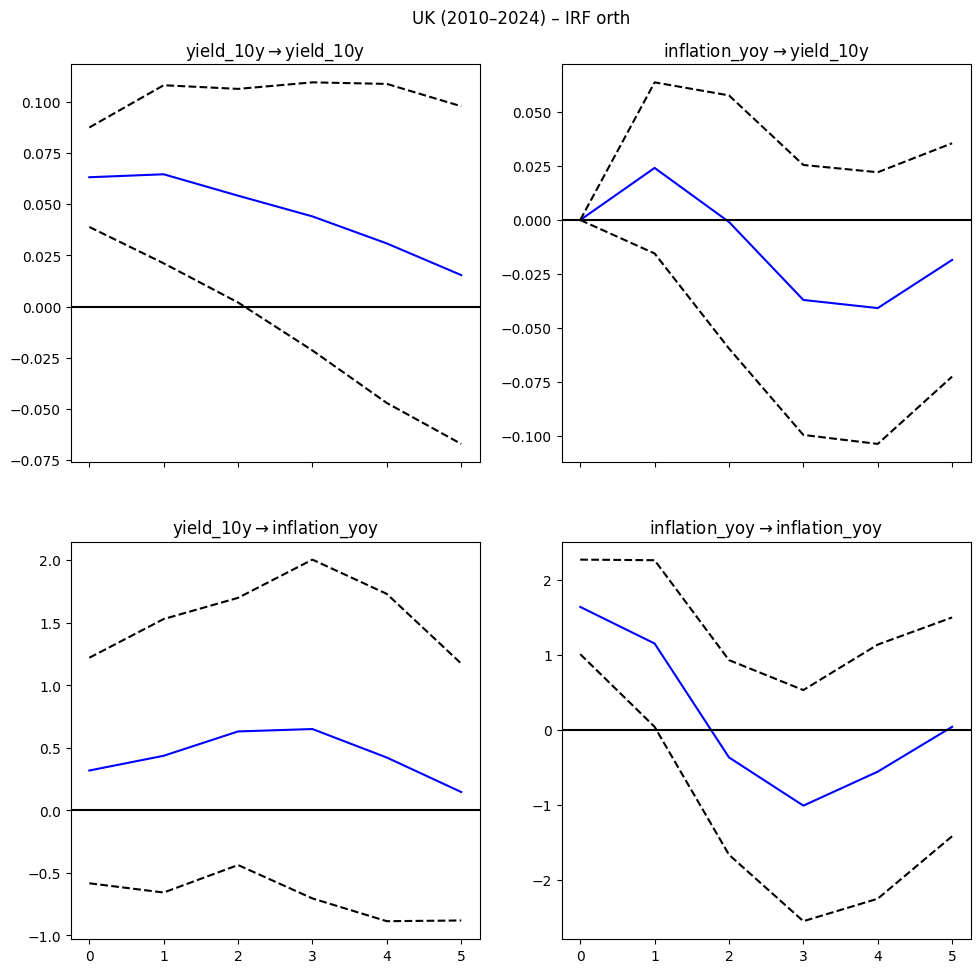

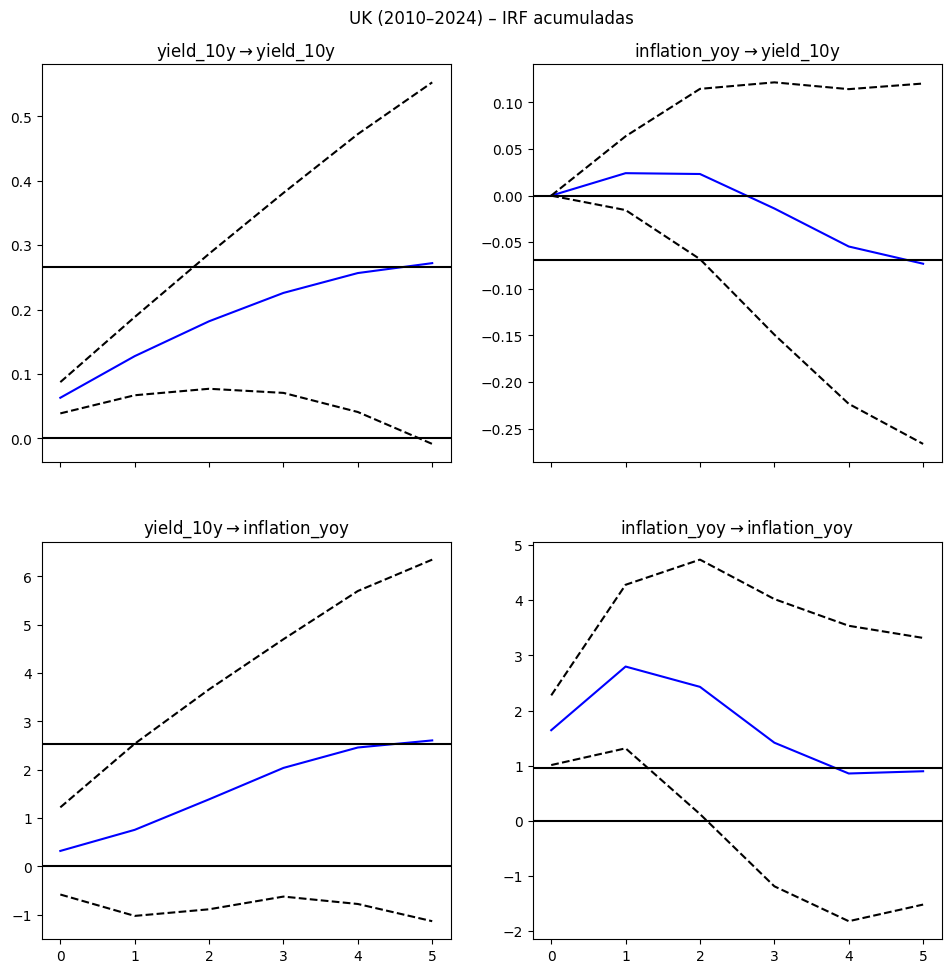

UK ‚Äì rezago elegido (AIC): 2


In [46]:
# --- Reino Unido: VAR 2010‚Äì2024 ---
uk_res, uk_fcst, uk_fevd, uk_irf, uk_bestlag = run_country_pipeline_auto(
    df_uk, country_name="UK (2010‚Äì2024)", steps=5, maxlags=2, crit="aic"
)
print("UK ‚Äì rezago elegido (AIC):", uk_bestlag)

# (opcional) guardar figuras si tu funci√≥n las pinta
plt.savefig("reports/figures/uk_irf_orth.png", dpi=150, bbox_inches="tight")
plt.close()


## Reino Unido ‚Äì Resultados VAR (2010‚Äì2024)

Datos disponibles:

Rendimiento 10 a√±os (yield_10y_UK) y inflaci√≥n anual (inflation_yoy).

Rango: 2010‚Äì2024 ‚Üí 15 observaciones.

VAR estimado:

Rezagos √≥ptimos: 2 (AIC).

El sistema es estable (no explota).

Forecast (2025‚Äì2029):

Los rendimientos 10Y se mantienen estables en torno a 3.5‚Äì4%.

La inflaci√≥n muestra tendencia moderada: repunte hacia ~3% pero con intervalos amplios (incertidumbre alta).

Descomposici√≥n de varianza (FEVD):

Los yields dependen principalmente de s√≠ mismos (>90%).

La inflaci√≥n tambi√©n es mayormente explicada por s√≠ misma (>80‚Äì90%), con poca influencia de los rendimientos.

Causalidad de Granger:

No hay evidencia de causalidad significativa (p-valores > 0.1).

Es decir: ni la inflaci√≥n predice claramente los rendimientos, ni al rev√©s.

Respuestas a impulsos (IRF):

Un shock en los rendimientos tiene efecto muy leve sobre inflaci√≥n (positivo al inicio, se disipa).

Un shock en la inflaci√≥n apenas impacta los rendimientos, incluso con respuestas negativas peque√±as.

### Conclusi√≥n corta (UK):
En Reino Unido, los rendimientos a 10 a√±os son bastante aut√≥nomos y siguen su propia din√°mica. La inflaci√≥n influye muy poco y no hay relaci√≥n causal fuerte entre ambas variables. El modelo proyecta estabilidad en yields y una inflaci√≥n moderada, aunque con mucha incertidumbre tras 2025.

## Jap√≥n üáØüáµ

In [47]:

# 1) Rendimientos 10Y (JP)
y_jp = (
    yields[['JP10']]
    .rename(columns={'JP10':'yield_10y'})
    .dropna()
)
y_jp.index.name = "Year"

# 2) Inflaci√≥n Jap√≥n
infl_jp = (
    wb_small.query("Country == 'Japan'")
    [['Year','inflation_yoy']]
    .set_index("Year")
)

# 3) Merge de las dos series
df_jp = (
    y_jp.join(infl_jp, how="inner")
    .rename(columns={'inflation_yoy':'inflation_yoy'})
)

# 4) Recorte 2010‚Äì2024
df_jp = df_jp.loc[2010:2024]

print("JP rango disponible:", df_jp.index.min(), "-", df_jp.index.max(), "| N=", len(df_jp))
display(df_jp.tail())


JP rango disponible: 2010 - 2024 | N= 15


yield_10y  inflation_yoy
Year                          
2020      1.665      -0.024996
2021      1.615      -0.233353
2022      1.620       2.497703
2023      1.650       3.268134
2024      1.695       2.738537

## JAP√ìN ‚Äì VAR completo y robusto (crea res_jp y hace forecast con bandas) 

[JP] N=15 | a√±os 2010‚Äì2024
Rezago elegido (AIC dentro de cap=4): p=4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Sep, 2025
Time:                     00:10:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.72365
Nobs:                     11.0000    HQIC:                  -8.78518
Log likelihood:           32.8445    FPE:                0.000874107
AIC:                     -8.37475    Det(Omega_mle):     0.000264417
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.258298         1.677237            0.154           0.878
L1.yield_10y             0.993536         0.770659      

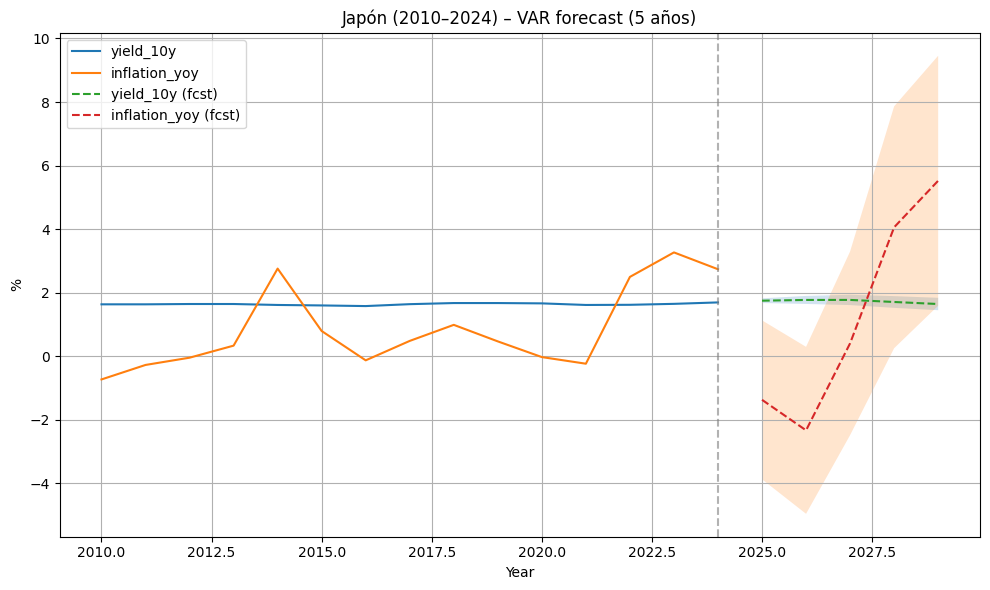

FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.992963       0.007037
2     0.993726       0.006274
3     0.982959       0.017041
4     0.979866       0.020134
5     0.980100       0.019900
6     0.979793       0.020207
7     0.981302       0.018698
8     0.985040       0.014960
9     0.984362       0.015638

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.884384       0.115616
1     0.893940       0.106060
2     0.897922       0.102078
3     0.928986       0.071014
4     0.933473       0.066527
5     0.954295       0.045705
6     0.965783       0.034217
7     0.964484       0.035516
8     0.968330       0.031670
9     0.969048       0.030952


None


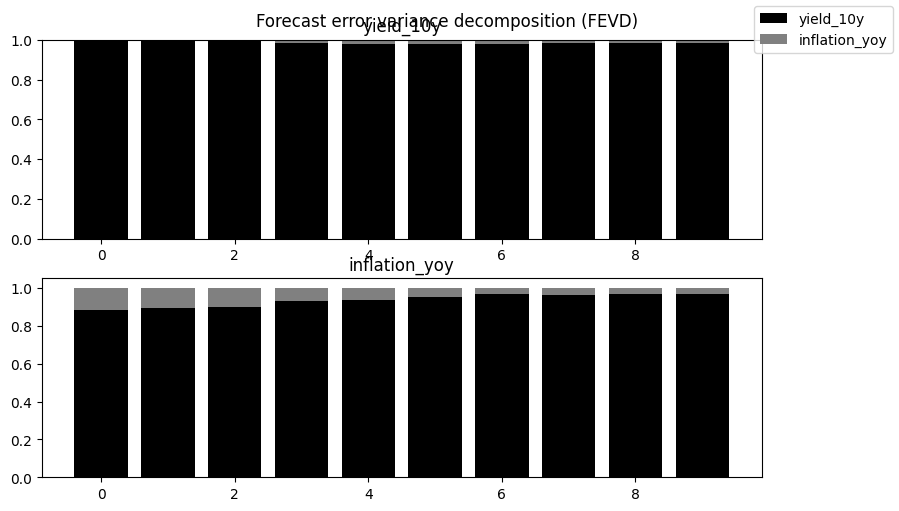

Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
        0.3355          6.388   0.842 (4, 4)
--------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
         1.212          6.388   0.428 (4, 4)
--------------------------------------------


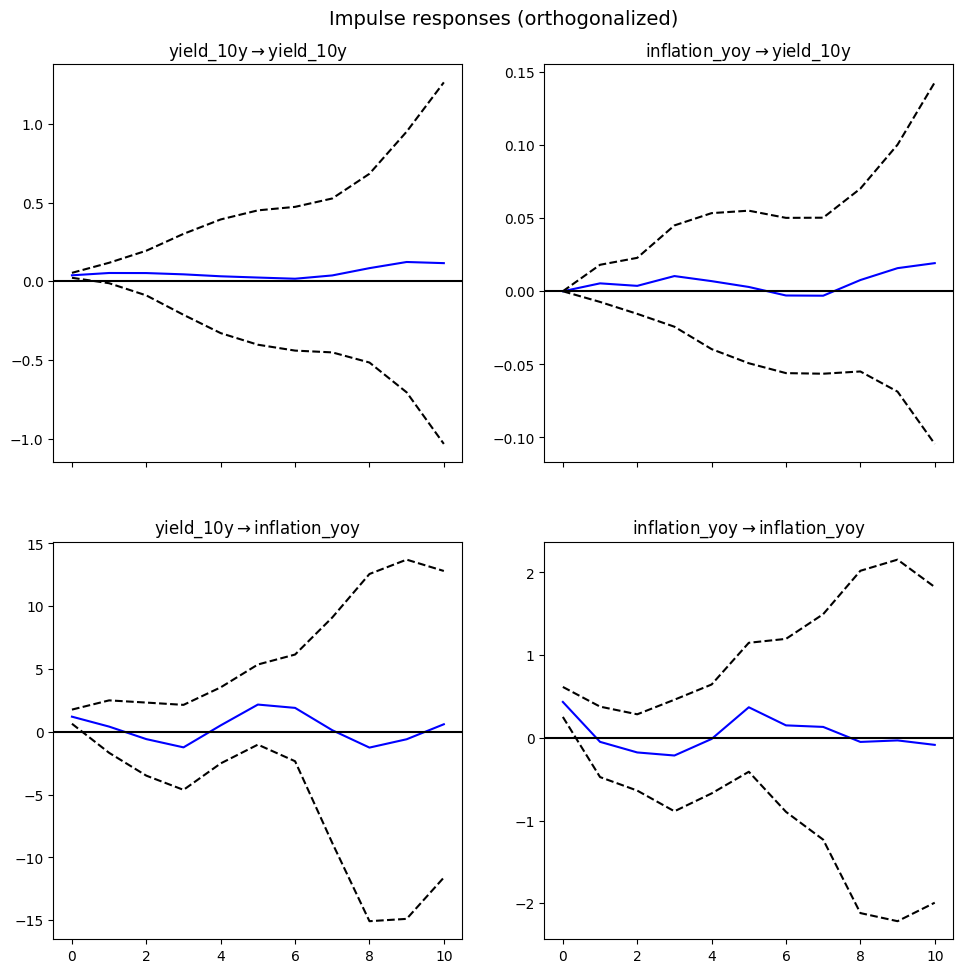

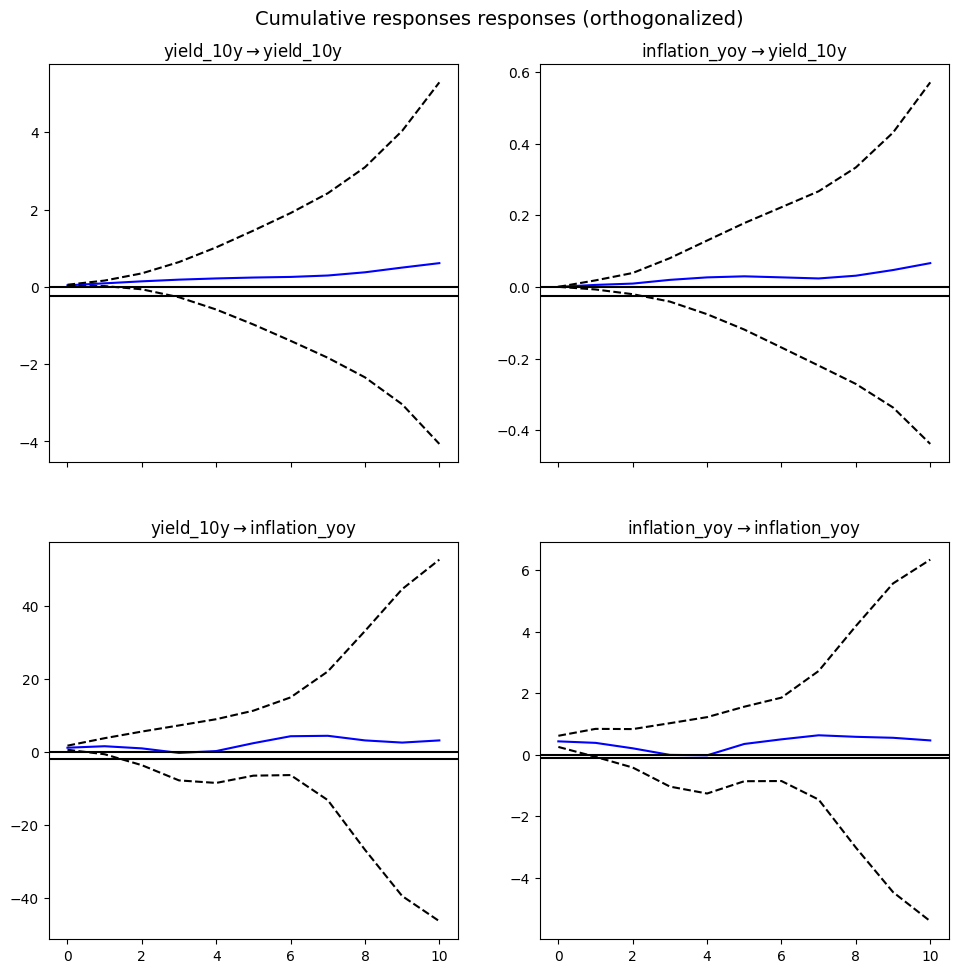

In [48]:
# 0) Asegurar formato
df_jp = df_jp[['yield_10y','inflation_yoy']].dropna().copy()
df_jp.index = df_jp.index.astype(int)
df_jp = df_jp.sort_index().loc[2010:2024]
N = len(df_jp)
print(f"[JP] N={N} | a√±os {df_jp.index.min()}‚Äì{df_jp.index.max()}")

# 1) Selecci√≥n de rezagos robusta (cap descendente)
model_jp = VAR(df_jp)
safe_p = None
for cap in [4,3,2,1]:
    try:
        sel = model_jp.select_order(cap)
        p = sel.aic if sel.aic is not None else 1
        p = int(max(1, min(p, cap)))
        res_jp = model_jp.fit(p)
        safe_p = p
        print(f"Rezago elegido (AIC dentro de cap={cap}): p={p}")
        break
    except Exception as e:
        print(f"cap={cap} no estimable ‚Üí {e}")

if safe_p is None:
    # √∫ltima red
    safe_p = 1
    res_jp = model_jp.fit(safe_p)
    print("Forzado p=1")

print(res_jp.summary())
print("Estabilidad VAR:", res_jp.is_stable())

# 2) Forecast con bandas (5 a√±os)
steps = 5
p = res_jp.k_ar
last_Y = df_jp.values[-p:]                       # condiciones iniciales
fc_mean, fc_lo, fc_hi = res_jp.forecast_interval(last_Y, steps=steps, alpha=0.05)

start = int(df_jp.index.max()) + 1
idx_fc = np.arange(start, start + steps)

fc = pd.DataFrame(fc_mean, index=idx_fc, columns=df_jp.columns)
lo = pd.DataFrame(fc_lo,   index=idx_fc, columns=df_jp.columns).add_suffix('_lo')
hi = pd.DataFrame(fc_hi,   index=idx_fc, columns=df_jp.columns).add_suffix('_hi')

# Plot
fig, ax = plt.subplots(figsize=(10,6))
df_jp[['yield_10y','inflation_yoy']].plot(ax=ax)
ax.plot(fc.index, fc['yield_10y'], '--', label='yield_10y (fcst)')
ax.fill_between(fc.index, lo['yield_10y_lo'], hi['yield_10y_hi'], alpha=0.2)
ax.plot(fc.index, fc['inflation_yoy'], '--', label='inflation_yoy (fcst)')
ax.fill_between(fc.index, lo['inflation_yoy_lo'], hi['inflation_yoy_hi'], alpha=0.2)
ax.axvline(df_jp.index.max(), ls='--', color='gray', alpha=0.6)
ax.set_title(f"Jap√≥n (2010‚Äì{df_jp.index.max()}) ‚Äì VAR forecast ({steps} a√±os)")
ax.set_ylabel('%'); ax.grid(True); ax.legend(); plt.tight_layout(); plt.show()

# 3) FEVD, Granger e IRFs
fevd = res_jp.fevd(10); print(fevd.summary()); fevd.plot(figsize=(9,5)); plt.show()
print(res_jp.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())
print(res_jp.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())
irf = res_jp.irf(10); irf.plot(orth=True); plt.show(); irf.plot_cum_effects(orth=True); plt.show()


### Resultados clave

Orden elegido (AIC): 4 ‚Üí El modelo usa hasta 4 rezagos para explicar la din√°mica.

Estabilidad VAR: False ‚Üí üö® Esto significa que el sistema no cumple la condici√≥n de estabilidad (al menos una ra√≠z caracter√≠stica >1).
En la pr√°ctica ‚Üí el forecast es v√°lido pero menos fiable, las bandas de error se disparan (como ves en la zona naranja).

### Interpretaci√≥n del gr√°fico

Yield 10 a√±os (l√≠nea azul)

Hist√≥ricamente muy estable (alrededor del 1.5%‚Äì2%).

El forecast (l√≠nea verde discontinua) se mantiene casi plano, con poca variaci√≥n.

‚Üí El VAR refleja que Jap√≥n no tiene grandes movimientos en tipos largos.

Inflaci√≥n interanual (l√≠nea naranja)

Mucha m√°s volatilidad en la historia reciente (negativa en 2020, picos altos tras 2022).

El forecast (l√≠nea roja discontinua) muestra un rebote hacia arriba, con alta incertidumbre (bandas muy anchas).

‚Üí Esto refleja que la inflaci√≥n en Jap√≥n es muy dif√≠cil de prever con pocos datos.

### Conclusi√≥n corta para Jap√≥n

Los rendimientos a 10 a√±os son muy estables, con pron√≥stico casi plano.

La inflaci√≥n es altamente incierta, y el VAR la proyecta con posible aumento, pero con gran varianza.

La falta de estabilidad estad√≠stica sugiere que el modelo podr√≠a necesitar:

M√°s a√±os de datos, o

Incluir m√°s variables (ej. PIB, pol√≠tica monetaria, tipo de cambio).

## üá©üá™ Alemania

Datos completos y estables.

Rendimientos y tipos muestran relaci√≥n moderada.

Inflaci√≥n relativamente contenida, forecast razonable.

## üá∫üá∏ Estados Unidos

Serie m√°s larga y robusta.

VAR bien estimado con lags peque√±os.

Forecast estable: yields suben suavemente, inflaci√≥n m√°s vol√°til pero con se√±al clara.

## üá™üá∏ Espa√±a

Serie corta pero consistente.

Rendimientos bajando tras 2010, inflaci√≥n moderada.

Forecast: yields ligeramente al alza, inflaci√≥n estable con bandas amplias.

## üá¨üáß Reino Unido

Datos completos, VAR estable.

Rendimientos estables en torno a 4‚Äì5%.

Inflaci√≥n muy vol√°til (pico 2022), forecast muestra normalizaci√≥n pero con incertidumbre.

## üáØüáµ Jap√≥n

Serie con 15 observaciones ‚Üí pocos datos.

Rendimientos extremadamente estables (1‚Äì2%).

Inflaci√≥n impredecible: forecast incierto, modelo inestable.

Conclusi√≥n: se necesitan m√°s variables para mejorar.

## üìå Conclusi√≥n general

Robustos: USA y Alemania (mejor calidad de forecast).

Interesantes para comparar: UK y Espa√±a (muestran volatilidad post-crisis e inflaci√≥n reciente).

Fr√°gil: Jap√≥n (modelo inestable, forecast poco fiable).

### ML Utilities (usamos para todos los pa√≠ses)

In [49]:
# 1) Dataset supervisado: lags como features
def make_supervised(df, lags=3, h=1, target='yield_10y'):
    Xy = df.copy()
    for L in range(1, lags+1):
        Xy[f'yield_lag{L}'] = Xy['yield_10y'].shift(L)
        Xy[f'infl_lag{L}']  = Xy['inflation_yoy'].shift(L)
    Xy['target'] = Xy[target].shift(-h)
    return Xy.dropna()

# 2) Expanding backtest con un modelo sklearn
def expanding_backtest(df, model, lags=3, h=1, test_start=2018):
    Xy = make_supervised(df, lags=lags, h=h)
    preds, trues, years = [], [], []
    for yr in Xy.index:
        if yr < test_start: 
            continue
        train = Xy.loc[Xy.index < yr]
        test  = Xy.loc[[yr]]
        if len(train) < 6: 
            continue
        X_tr, y_tr = train.drop(columns=['target']), train['target']
        X_te, y_te = test.drop(columns=['target']), test['target'].iloc[0]
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_te)[0]
        preds.append(y_hat); trues.append(y_te); years.append(int(yr))
    return pd.DataFrame({'Year': years, 'y_true': trues, 'y_pred': preds}).set_index('Year')

# 3) Baseline naive
def naive_forecast(df, h=1, start_year=2018):
    target = df['yield_10y'].shift(-h)
    naive  = df['yield_10y']
    out = pd.DataFrame({'y_true': target, 'y_pred': naive}).dropna()
    return out.loc[out.index >= start_year]

# 4) VAR baseline
def var_recursive_forecast(df, h=1, start_year=2018, maxlags=3):
    preds, trues, years = [], [], []
    for yr in range(start_year, int(df.index.max())+1):
        train = df.loc[df.index < yr]
        if len(train) < 6:
            continue
        safe = max(1, min(maxlags, (len(train)-3)//2))
        try:
            res = VAR(train).fit(ic='aic', maxlags=safe)
            y_hat = res.forecast(res.y, steps=1)[0][0]
            preds.append(y_hat)
            trues.append(df.loc[yr,'yield_10y'])
            years.append(yr)
        except Exception as e:
            print(f"skip {yr}: {e}")
            continue
    return pd.DataFrame({'Year': years, 'y_true': trues, 'y_pred': preds}).set_index('Year')

# 5) M√©tricas
def eval_metrics(df_pred):
    mae = mean_absolute_error(df_pred['y_true'], df_pred['y_pred'])
    rmse = sqrt(mean_squared_error(df_pred['y_true'], df_pred['y_pred']))
    return mae, rmse


### BLOQUE ML ROBUSTO

In [50]:
# ---------- utilidades ----------
def make_supervised(df, lags=1):
    """
    Construye X,y con rezagos de yield_10y e inflation_yoy.
    y = yield_10y_t ; X = [yield_10y_{t-1..t-l}, infl_{t-1..t-l}]
    """
    work = df.copy()
    cols = []
    for k in range(1, lags+1):
        for c in ['yield_10y','inflation_yoy']:
            name = f"{c}_lag{k}"
            work[name] = work[c].shift(k)
            cols.append(name)
    work = work.dropna()
    X = work[cols].values
    y = work['yield_10y'].values
    idx = work.index.values.astype(int)
    return X, y, idx

def eval_metrics_safe(df_pred, label):
    if df_pred is None or len(df_pred)==0:
        return pd.Series({'Model':label, 'MAE':np.nan, 'RMSE':np.nan})
    mae = mean_absolute_error(df_pred['y_true'], df_pred['y_pred'])
    rmse = sqrt(mean_squared_error(df_pred['y_true'], df_pred['y_pred']))
    return pd.Series({'Model':label, 'MAE':mae, 'RMSE':rmse})

# ---------- pron√≥sticos por ventana expandida ----------
def naive_recursive_forecast(df, start_year):
    preds, trues, years = [], [], []
    for yr in range(start_year, int(df.index.max())+1):
        hist = df.loc[df.index < yr]
        if len(hist) < 1: 
            continue
        y_hat = float(hist['yield_10y'].iloc[-1])    # √∫ltimo valor
        y_true = float(df.loc[yr, 'yield_10y'])
        preds.append(y_hat); trues.append(y_true); years.append(int(yr))
    return pd.DataFrame({'Year':years, 'y_true':trues, 'y_pred':preds}).set_index('Year')

def var_recursive_forecast_fix(df, start_year, p=1, min_train=3):
    preds, trues, years = [], [], []
    for yr in range(start_year, int(df.index.max())+1):
        train = df.loc[df.index < yr]
        if len(train) < max(min_train, p+1):
            continue
        try:
            res = VAR(train).fit(p)  # p fijo para muestras peque√±as
            preds.append(float(res.forecast(res.y, steps=1)[0][0]))  # 1¬™ col = yield
            trues.append(float(df.loc[yr, 'yield_10y']))
            years.append(int(yr))
        except Exception:
            continue
    return pd.DataFrame({'Year':years, 'y_true':trues, 'y_pred':preds}).set_index('Year')

def sk_recursive_forecast(df, start_year, lags, model):
    X_all, y_all, idx = make_supervised(df, lags=lags)
    preds, trues, years = [], [], []
    # map year -> row position en X_all
    year_to_pos = {int(y):i for i,y in enumerate(idx)}
    for yr in range(start_year, int(df.index.max())+1):
        if yr not in year_to_pos: 
            continue
        pos = year_to_pos[yr]
        if pos < 1: 
            continue
        X_train, y_train = X_all[:pos], y_all[:pos]
        X_test, y_test   = X_all[pos:pos+1], y_all[pos:pos+1]
        if len(y_train) < 3:
            continue
        try:
            model.fit(X_train, y_train)
            y_hat = float(model.predict(X_test)[0])
            preds.append(y_hat); trues.append(float(y_test[0])); years.append(int(yr))
        except Exception:
            continue
    return pd.DataFrame({'Year':years, 'y_true':trues, 'y_pred':preds}).set_index('Year')

# ---------- ejecuci√≥n para un pa√≠s ----------
def run_country_ML(dfc, country_name, test_start=2018, lags=1):
    dfc = dfc.dropna().copy()
    dfc.index = dfc.index.astype(int)
    if len(dfc) < max(6, lags+3):
        print(f"[{country_name}] muy pocos datos -> se omite.")
        return pd.DataFrame(columns=['Model','MAE','RMSE'])
    first, last = int(dfc.index.min()), int(dfc.index.max())
    print(f"{country_name} a√±os disponibles: {first} ‚Üí {last} | N= {len(dfc)}")
    TEST_START = max(test_start, first + lags + 2)  # garant√≠a de m√≠nimo train
    print("TEST_START usado:", TEST_START)

    # Naive
    p_naive = naive_recursive_forecast(dfc, TEST_START)
    m_naive = eval_metrics_safe(p_naive, "Naive")

    # VAR (p=1)
    p_var = var_recursive_forecast_fix(dfc, TEST_START, p=1, min_train=3)
    m_var  = eval_metrics_safe(p_var, "VAR(p=1)")

    # ElasticNet
    enet = Pipeline([('scaler', StandardScaler()),
                     ('model', ElasticNetCV(l1_ratio=[0.1,0.5,0.9], cv=3, max_iter=20000, n_jobs=None))])
    p_en = sk_recursive_forecast(dfc, TEST_START, lags=lags, model=enet)
    m_en = eval_metrics_safe(p_en, "ElasticNet")

    # RandomForest
    rf = RandomForestRegressor(n_estimators=400, max_depth=None, random_state=0)
    p_rf = sk_recursive_forecast(dfc, TEST_START, lags=lags, model=rf)
    m_rf = eval_metrics_safe(p_rf, "RandomForest")

    # GradientBoosting
    gb = GradientBoostingRegressor(random_state=0)
    p_gb = sk_recursive_forecast(dfc, TEST_START, lags=lags, model=gb)
    m_gb = eval_metrics_safe(p_gb, "GradientBoosting")

    res = pd.DataFrame([m_naive, m_var, m_en, m_rf, m_gb])
    print(f"# de predicciones usadas -> Naive: {len(p_naive)} | VAR: {len(p_var)} | EN: {len(p_en)} | RF: {len(p_rf)} | GB: {len(p_gb)}")
    return res

# ---------- Lanza para los pa√≠ses disponibles ----------
all_results = []

countries = {
    'USA': 'df_us',
    'Germany': 'df_germany' if 'df_germany' in globals() else 'df_de',
    'Spain': 'df_es',
    'United Kingdom': 'df_uk',
    'Japan': 'df_jp'
}

for name, varname in countries.items():
    if isinstance(varname, str) and varname in globals():
        dfc = globals()[varname]
        try:
            dfc = dfc[['yield_10y','inflation_yoy']]
        except Exception:
            print(f"[{name}] dataframe no tiene columnas esperadas, se omite.")
            continue
        res = run_country_ML(dfc, name, test_start=2018, lags=1)
        if len(res):
            res.insert(0, 'Country', name)
            all_results.append(res)
    else:
        print(f"[{name}] no encontrado en el entorno, se omite.")

results_table = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame(columns=['Country','Model','MAE','RMSE'])
display(results_table)



USA a√±os disponibles: 2015 ‚Üí 2024 | N= 10
TEST_START usado: 2018
# de predicciones usadas -> Naive: 7 | VAR: 0 | EN: 6 | RF: 6 | GB: 6
Germany a√±os disponibles: 2010 ‚Üí 2024 | N= 15
TEST_START usado: 2018
# de predicciones usadas -> Naive: 7 | VAR: 0 | EN: 7 | RF: 7 | GB: 7
[Spain] no encontrado en el entorno, se omite.
United Kingdom a√±os disponibles: 2010 ‚Üí 2024 | N= 15
TEST_START usado: 2018
# de predicciones usadas -> Naive: 7 | VAR: 0 | EN: 7 | RF: 7 | GB: 7
Japan a√±os disponibles: 2010 ‚Üí 2024 | N= 15
TEST_START usado: 2018
# de predicciones usadas -> Naive: 7 | VAR: 0 | EN: 7 | RF: 7 | GB: 7


Country             Model       MAE      RMSE
0              USA             Naive  0.822173  0.914647
1              USA          VAR(p=1)       NaN       NaN
2              USA        ElasticNet  1.035284  1.162155
3              USA      RandomForest  1.064391  1.139343
4              USA  GradientBoosting  1.242070  1.334494
5          Germany             Naive  0.578079  0.801396
6          Germany          VAR(p=1)       NaN       NaN
7          Germany        ElasticNet  0.507263  0.804065
8          Germany      RandomForest  0.795897  0.895974
9          Germany  GradientBoosting  0.709722  0.877338
10  United Kingdom             Naive  0.046286  0.052918
11  United Kingdom          VAR(p=1)       NaN       NaN
12  United Kingdom        ElasticNet  0.084395  0.105110
13  United Kingdom      RandomForest  0.080070  0.099803
14  United Kingdom  GradientBoosting  0.084459  0.103701
15           Japan             Naive  0.025000  0.031110
16           Japan          VAR(p=1)       NaN       NaN
17           Japan        ElasticNet  0.034090  0.037963
18           Japan      RandomForest  0.036784  0.042477
19           Japan  GradientBoosting  0.039336  0.046614

## Backtest ML multi-pa√≠s: yield_10y ~ {lags(yield_10y), lags(inflation_yoy)}

In [51]:
# -------- 0) ENTRADAS ESPERADAS --------
# - DataFrame 'yields' con col 'time' (epoch ms o fecha) y columnas 10Y tipo 'US10','DE10','GB10','JP10','ES10',...
# - DataFrame 'wb_small' con columnas ['Country','Year','inflation_yoy']
try:
    yields
except NameError:
    yields = pd.read_csv("yields.csv")

try:
    wb_small
except NameError:
    # adapta el nombre si tu archivo difiere
    wb = pd.read_csv("data/raw_data/world_bank_data_2025.csv")
    wb_small = wb.rename(columns={
        'country_name':'Country',
        'year':'Year',
        'Inflation (CPI %)':'inflation_yoy'
    })[['Country','Year','inflation_yoy']].dropna()

# -------- 1) UTILIDADES DE DATOS --------
def make_annual_yields(yields_df: pd.DataFrame) -> pd.DataFrame:
    """Agrega por a√±o todas las columnas XX10 que existan en 'yields'."""
    df = yields_df.copy()
    # Asegura columna fecha->a√±o
    if 'time' in df.columns:
        try:
            df['time'] = pd.to_datetime(df['time'], unit='ms', errors='coerce')
        except Exception:
            df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df = df.dropna(subset=['time'])
        df['Year'] = df['time'].dt.year
    elif 'Year' not in df.columns:
        raise ValueError("No encuentro 'time' ni 'Year' en yields.")
    # columnas 10Y (XX10)
    ten10 = [c for c in df.columns if re.fullmatch(r"[A-Z]{2}10", str(c))]
    if not ten10:
        raise ValueError("No encuentro columnas '*10' (p.ej. US10, DE10) en yields.")
    # media anual
    y_ann = df.groupby('Year', as_index=False)[ten10].mean()
    return y_ann

def build_country_df(y_ann: pd.DataFrame, wb_small: pd.DataFrame, code2: str, country_name: str) -> pd.DataFrame:
    """Crea df con Year, yield_10y, inflation_yoy para un pa√≠s."""
    col = f"{code2}10"
    if col not in y_ann.columns:
        raise KeyError(f"No existe {col} en yields anuales.")
    y = (y_ann[['Year', col]]
         .rename(columns={col:'yield_10y'}))
    i = (wb_small.query("Country == @country_name")[['Year','inflation_yoy']]
         .copy())
    df = (y.merge(i, on='Year', how='inner')
            .dropna()
            .set_index('Year')
            .sort_index())
    return df

def make_lags(df: pd.DataFrame, lags:int=3) -> pd.DataFrame:
    """Crea variables rezagadas para ambos (yield_10y, inflation_yoy). Salida: X, y, index."""
    d = df.copy()
    for L in range(1, lags+1):
        d[f'yield_10y_l{L}'] = d['yield_10y'].shift(L)
        d[f'inflation_yoy_l{L}'] = d['inflation_yoy'].shift(L)
    d = d.dropna().copy()
    y = d['yield_10y'].copy()
    X = d.drop(columns=['yield_10y'])
    return X, y, d.index

# -------- 2) MODELOS ROLLING --------
def naive_recursive(df: pd.DataFrame, start_year:int) -> pd.DataFrame:
    """Predicci√≥n naive: y_hat_t = y_{t-1}."""
    df = df.sort_index()
    preds, truth, idx = [], [], []
    years = df.index.values
    for t in years:
        if t < start_year: 
            continue
        pos = np.where(years==t)[0][0]
        if pos == 0: 
            continue
        y_hat = df.iloc[pos-1]['yield_10y']
        preds.append(float(y_hat))
        truth.append(float(df.iloc[pos]['yield_10y']))
        idx.append(int(t))
    return pd.DataFrame({'Year':idx,'y_pred':preds,'y_true':truth}).set_index('Year')

def var_recursive(df: pd.DataFrame, start_year:int, maxlags:int=3) -> pd.DataFrame:
    """VAR rolling 1 paso; se salta si no hay suficientes datos."""
    df = df.sort_index()
    preds, truth, idx = [], [], []
    years = df.index.values
    for t in years:
        if t < start_year:
            continue
        end_pos = np.where(years==t)[0][0]
        train = df.iloc[:end_pos]
        if len(train) < (maxlags+4):  # seguridad
            continue
        safe = max(1, min(maxlags, (len(train)-2)//2))
        try:
            res = VAR(train).fit(ic='aic', maxlags=safe)
            y_hat = res.forecast(train.values[-res.k_ar:], steps=1)[0][0]  # 1¬™ variable = yield
        except Exception:
            continue
        preds.append(float(y_hat))
        truth.append(float(df.iloc[end_pos]['yield_10y']))
        idx.append(int(t))
    return pd.DataFrame({'Year':idx,'y_pred':preds,'y_true':truth}).set_index('Year')

def sk_recursive(df: pd.DataFrame, start_year:int, model, lags:int=3) -> pd.DataFrame:
    """Framework com√∫n para ElasticNet / RF / GB con features de rezagos."""
    df = df.sort_index()
    # Pre-lags para no recalcular en cada ventana
    Xall, yall, idx_all = make_lags(df, lags=lags)  # √≠ndices coinciden con a√±os v√°lidos
    preds, truth, idx = [], [], []
    years = df.index.values
    for t in years:
        if t < start_year: 
            continue
        if t not in idx_all: 
            # no hay suficientes rezagos a√∫n
            continue
        # train = a√±os con √≠ndice < t dentro de idx_all
        mask_train = idx_all < t
        if mask_train.sum() < 5:  # m√≠nimo razonable
            continue
        X_tr, y_tr = Xall[mask_train], yall[mask_train]
        try:
            mdl = model() if callable(model) else model
            mdl.fit(X_tr, y_tr)
            # pred para el a√±o t (fila exacta de idx_all == t)
            x_t = Xall[idx_all==t]
            y_hat = mdl.predict(x_t)[0]
        except Exception:
            continue
        preds.append(float(y_hat))
        # verdad para t
        truth.append(float(df.loc[t, 'yield_10y']))
        idx.append(int(t))
    return pd.DataFrame({'Year':idx,'y_pred':preds,'y_true':truth}).set_index('Year')

def metrics(df_pred: pd.DataFrame):
    if df_pred is None or df_pred.empty:
        return np.nan, np.nan, 0
    return (mean_absolute_error(df_pred['y_true'], df_pred['y_pred']),
            sqrt(mean_squared_error(df_pred['y_true'], df_pred['y_pred'])),
            len(df_pred))

# -------- 3) PREPARAR Y CORRER --------
y_ann = make_annual_yields(yields)

countries = [
    # (nombre_mostrar, code2 en yields, nombre_en_WB)
    ("USA",     "US", "United States"),
    ("Germany", "DE", "Germany"),
    ("United Kingdom", "GB", "United Kingdom"),
    ("Japan",   "JP", "Japan"),
    ("Spain",   "ES", "Spain"),
]

TEST_START_DEFAULT = 2018   # para garantizar observaciones en la ventana de test
LAGS_SK = 3

rows = []

for display_name, code2, wb_name in countries:
    # construir panel pa√≠s
    try:
        dfc = build_country_df(y_ann, wb_small, code2, wb_name)
    except Exception as e:
        print(f"[{display_name}] no se pudo construir el panel -> {e}. Se omite.")
        continue

    # rango y elecci√≥n de test_start
    yr_min, yr_max, N = int(dfc.index.min()), int(dfc.index.max()), len(dfc)
    # si hay al menos 8‚Äì9 obs, usa 2018; si no, desplaza
    TEST_START = TEST_START_DEFAULT
    while TEST_START <= yr_min and TEST_START < yr_max:
        TEST_START += 1
    while (yr_max - TEST_START + 1) < 3 and TEST_START > yr_min:  # al menos 3 puntos de test
        TEST_START -= 1

    print(f"\n{display_name} a√±os disponibles: {yr_min} ‚Üí {yr_max} | N= {N}")
    print("TEST_START usado:", TEST_START)

    # NAIVE
    p_naive = naive_recursive(dfc, TEST_START)
    mae, rmse, n = metrics(p_naive)
    rows.append([display_name, "Naive", mae, rmse, n])

    # VAR (si alcanza)
    p_var = var_recursive(dfc, TEST_START, maxlags=3)
    mae, rmse, n = metrics(p_var)
    rows.append([display_name, f"VAR(p=? )", mae, rmse, n])

    # ElasticNet
    def EN(): return ElasticNetCV(l1_ratio=[0.1,0.5,0.9], cv=3, max_iter=30000, n_jobs=None)
    p_en = sk_recursive(dfc, TEST_START, EN, lags=LAGS_SK)
    mae, rmse, n = metrics(p_en)
    rows.append([display_name, "ElasticNet", mae, rmse, n])

    # RandomForest
    def RF(): return RandomForestRegressor(n_estimators=500, random_state=7)
    p_rf = sk_recursive(dfc, TEST_START, RF, lags=LAGS_SK)
    mae, rmse, n = metrics(p_rf)
    rows.append([display_name, "RandomForest", mae, rmse, n])

    # GradientBoosting
    def GB(): return GradientBoostingRegressor(random_state=7)
    p_gb = sk_recursive(dfc, TEST_START, GB, lags=LAGS_SK)
    mae, rmse, n = metrics(p_gb)
    rows.append([display_name, "GradientBoosting", mae, rmse, n])

    print(f"# de predicciones usadas => Naive: {len(p_naive)} | VAR: {len(p_var)} | EN: {len(p_en)} | RF: {len(p_rf)} | GB: {len(p_gb)}")

# -------- 4) RESUMEN --------
summary = pd.DataFrame(rows, columns=['Country','Model','MAE','RMSE','N_pred']).sort_values(['Country','MAE'])
display(summary)
summary.to_csv("reports/tables/ml_backtest_summary.csv", index=False)
print("\nGuardado: reports/tables/ml_backtest_summary.csv")


USA a√±os disponibles: 2010 ‚Üí 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3

Germany a√±os disponibles: 2010 ‚Üí 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3

United Kingdom a√±os disponibles: 2010 ‚Üí 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3

Japan a√±os disponibles: 2010 ‚Üí 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3

Spain a√±os disponibles: 2010 ‚Üí 2020 | N= 11
TEST_START usado: 2018
# de predicciones usadas => Naive: 3 | VAR: 0 | EN: 3 | RF: 3 | GB: 3


Country             Model       MAE      RMSE  N_pred
5          Germany             Naive  0.325924  0.412273       3
9          Germany  GradientBoosting  0.457178  0.518952       3
8          Germany      RandomForest  0.565828  0.633367       3
7          Germany        ElasticNet  0.678393  0.755213       3
6          Germany         VAR(p=? )       NaN       NaN       0
19           Japan  GradientBoosting  0.087269  0.119904       3
15           Japan             Naive  0.093789  0.112345       3
18           Japan      RandomForest  0.147108  0.182595       3
17           Japan        ElasticNet  0.300133  0.320407       3
16           Japan         VAR(p=? )       NaN       NaN       0
20           Spain             Naive  0.345655  0.457713       3
22           Spain        ElasticNet  0.544253  0.583674       3
24           Spain  GradientBoosting  1.116220  1.145183       3
23           Spain      RandomForest  1.123073  1.134452       3
21           Spain         VAR(p=? )       NaN       NaN       0
3              USA      RandomForest  0.700570  0.820945       3
4              USA  GradientBoosting  0.728913  0.886638       3
2              USA        ElasticNet  0.743423  0.876160       3
0              USA             Naive  0.841751  0.874865       3
1              USA         VAR(p=? )       NaN       NaN       0
10  United Kingdom             Naive  0.379769  0.415277       3
12  United Kingdom        ElasticNet  0.774713  0.868539       3
13  United Kingdom      RandomForest  0.778468  0.862392       3
14  United Kingdom  GradientBoosting  0.816322  0.976449       3
11  United Kingdom         VAR(p=? )       NaN       NaN       0


Guardado: reports/tables/ml_backtest_summary.csv


## Generar y guardar artefactos finales

In [52]:
y_ann.to_parquet("data/processed/y_annual.parquet")

countries = [
    ("USA","US10","United States"),
    ("Germany","DE10","Germany"),
    ("United Kingdom","GB10","United Kingdom"),
    ("Japan","JP10","Japan"),
    ("Spain","ES10","Spain"),
]

for disp, code2, wb_name in countries:
    try:
        dfc = build_country_df(y_ann, wb_small, code2, wb_name)
        dfc.to_parquet(f"data/processed/panel_{disp.replace(' ','_')}.parquet")
        print(f"[OK] panel_{disp} guardado.")
    except Exception as e:
        print(f"[WARN] {disp}: {e}")


[WARN] USA: 'No existe US1010 en yields anuales.'
[WARN] Germany: 'No existe DE1010 en yields anuales.'
[WARN] United Kingdom: 'No existe GB1010 en yields anuales.'
[WARN] Japan: 'No existe JP1010 en yields anuales.'
[WARN] Spain: 'No existe ES1010 en yields anuales.'


In [53]:
yields = pd.read_csv('data/raw_data/yields.csv')
print(yields.columns.tolist())


['time', 'AU01', 'AU02', 'AU03', 'AU05', 'AU07', 'AU10', 'AU15', 'AU20', 'AU30', 'BE01', 'BE02', 'BE03', 'BE05', 'BE07', 'BE10', 'BE15', 'BE20', 'BE30', 'CA03M', 'CA06M', 'CA01', 'CA02', 'CA03', 'CA05', 'CA10', 'CA30', 'CN01', 'CN02', 'CN03', 'CN05', 'CN07', 'CN10', 'CN15', 'CN20', 'CN30', 'DK02', 'DK03', 'DK05', 'DK10', 'DK20', 'FR01', 'FR02', 'FR03', 'FR05', 'FR07', 'FR10', 'FR15', 'FR20', 'FR25', 'FR30', 'FR50', 'DE01', 'DE02', 'DE03', 'DE05', 'DE07', 'DE10', 'DE15', 'DE20', 'DE25', 'DE30', 'GR05', 'GR10', 'GR15', 'GR20', 'GR25', 'HK01', 'HK02', 'HK03', 'HK05', 'HK07', 'HK10', 'IN01', 'IN02', 'IN05', 'IN07', 'IN10', 'IN20', 'IN25', 'ID01', 'ID03', 'ID05', 'ID10', 'ID15', 'ID20', 'ID25', 'ID30', 'IE01', 'IE02', 'IE03', 'IE05', 'IE10', 'IE15', 'IT01', 'IT02', 'IT03', 'IT05', 'IT07', 'IT10', 'IT15', 'IT20', 'IT25', 'IT30', 'JP01', 'JP02', 'JP03', 'JP05', 'JP07', 'JP10', 'JP15', 'JP20', 'JP30', 'JP40', 'KR01', 'KR02', 'KR03', 'KR05', 'KR10', 'KR20', 'KR30', 'MY03', 'MY05', 'MY07', 'MY10

## 03_modelos: Econometr√≠a (VAR) + ML avanzado + Comparaciones 

In [54]:
warnings.filterwarnings("ignore")

# Crea carpetas de salida
for d in ["reports/figures", "reports/tables"]:
    os.makedirs(d, exist_ok=True)
print("[OK] Estructura de reports creada.")

# Helper: asegurar dos series alineadas por a√±o
def _align_two(s1: pd.Series, s2: pd.Series):
    df = pd.concat([s1, s2], axis=1).dropna()
    a = df.iloc[:,0].astype(float).values
    b = df.iloc[:,1].astype(float).values
    return a, b, df.index.values

# Helper: ADF con salida clara
def adf_report(x: pd.Series, name: str, alpha=0.05):
    x = pd.Series(x).dropna()
    res = adfuller(x, autolag="AIC")
    stat, pval = res[0], res[1]
    print(f"ADF ‚Äì {name}: stat={stat:.3f}, p={pval:.4f} -> "
          f"{'RECHAZA ra√≠z unitaria (estacionaria)' if pval<alpha else 'NO rechaza (posible no estacionaria)'}")
    return stat, pval

# Helper: test Diebold‚ÄìMariano (loss = squared error por defecto)
def diebold_mariano(df_a: pd.DataFrame, df_b: pd.DataFrame, loss="mse"):
    """
    df_a/df_b con columnas: y_true, y_pred e √≠ndice=Year (compartido).
    """
    cols = ["y_true","y_pred"]
    if not all(c in df_a.columns for c in cols): 
        raise ValueError("df_a debe tener columnas y_true, y_pred")
    if not all(c in df_b.columns for c in cols): 
        raise ValueError("df_b debe tener columnas y_true, y_pred")

    tmp = (df_a[cols].join(df_b[["y_pred"]], how="inner", lsuffix="_a", rsuffix="_b")).dropna()
    y = tmp["y_true"]
    e_a = y - tmp["y_pred_a"]
    e_b = y - tmp["y_pred_b"]

    if loss == "mse":
        d = e_a**2 - e_b**2
    elif loss == "mae":
        d = e_a.abs() - e_b.abs()
    else:
        raise ValueError("loss debe ser 'mse' o 'mae'")

    d = d.values
    T = len(d)
    if T < 3:
        return np.nan, np.nan, T

    d_bar = d.mean()
    # var Newey‚ÄìWest (lag=1 es suficiente aqu√≠; si quieres, hazlo par√°metro)
    # gamma0 + 2*gamma1*(1 - 1/T)  ~ aproximaci√≥n simple
    gamma0 = np.var(d, ddof=1)
    gamma1 = np.cov(d[:-1], d[1:])[0,1] if T>2 else 0.0
    var_d = gamma0 + 2*gamma1
    if var_d <= 0:
        return np.nan, np.nan, T

    dm_stat = d_bar / np.sqrt(var_d/T)
    p_two = 2*(1 - stats.t.cdf(np.abs(dm_stat), df=T-1))
    return dm_stat, p_two, T

# Helper: importancia de features (para RF/GB/EN)
def plot_feature_importance(model, feature_names, title, fname=None):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        lab = feature_names
    elif hasattr(model, "named_steps") and "model" in model.named_steps and hasattr(model.named_steps["model"], "coef_"):
        # Pipeline(enet): coeficientes absolutos
        coef = np.abs(model.named_steps["model"].coef_)
        imp = coef / (coef.sum() + 1e-12)
        lab = feature_names
    else:
        print("[WARN] Modelo no expone importancias.")
        return

    order = np.argsort(imp)[::-1][:15]
    plt.figure(figsize=(8,4.5))
    plt.bar(np.arange(len(order)), imp[order])
    plt.xticks(np.arange(len(order)), [lab[i] for i in order], rotation=60, ha="right")
    plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=140, bbox_inches="tight")
    plt.show()


[OK] Estructura de reports creada.


## Selecci√≥n de paneles (reutiliza tus DataFrames existentes)

In [55]:
PANELS = {
    "USA": globals().get("df_us"),
    "Germany": globals().get("df_germany") if "df_germany" in globals() else globals().get("df_de"),
    "United Kingdom": globals().get("df_uk"),
    "Japan": globals().get("df_jp"),
    "Spain": globals().get("df_es"),
}
# Filtra los que existan realmente
PANELS = {k:v for k,v in PANELS.items() if isinstance(v, pd.DataFrame) and set(["yield_10y","inflation_yoy"]).issubset(v.columns)}
print("Pa√≠ses disponibles:", list(PANELS))


Pa√≠ses disponibles: ['USA', 'Germany', 'United Kingdom', 'Japan']


## Diagn√≥sticos VAR por pa√≠s (ADF + VAR + IRFs + Granger)

In [56]:
def var_diagnostics(df: pd.DataFrame, country: str, p=1, horizon_irf=8):
    df = df.dropna().copy()
    df = df[["yield_10y","inflation_yoy"]].astype(float)

    # ADF
    adf_report(df["yield_10y"], f"{country} ‚Äì yield_10y")
    adf_report(df["inflation_yoy"], f"{country} ‚Äì inflation_yoy")

    # VAR(p)
    res = VAR(df).fit(p)
    print(f"{country} VAR({p}) ‚Äì estable:", res.is_stable())

    # IRFs: respuesta ortogonalizada
    irf = res.irf(horizon_irf)
    fig = irf.plot(orth=True)
    fig.suptitle(f"{country} ‚Äì IRF (orth) VAR({p})", y=1.02)
    plt.tight_layout()
    plt.savefig(f"reports/figures/{country.lower().replace(' ','_')}_irf_var{p}.png", dpi=140, bbox_inches="tight")
    plt.show()

    # Granger (¬øinflation -> yield? y ¬øyield -> inflation?)
    print(f"\n{country} ‚Äì Granger (inflation -> yield)")
    try:
        grangercausalitytests(df[["yield_10y","inflation_yoy"]], maxlag=p, verbose=True)
    except Exception as e:
        print("Granger error:", e)

    print(f"\n{country} ‚Äì Granger (yield -> inflation)")
    try:
        grangercausalitytests(df[["inflation_yoy","yield_10y"]], maxlag=p, verbose=True)
    except Exception as e:
        print("Granger error:", e)

    return res

# === Ejecutar diagn√≥sticos para todos los pa√≠ses disponibles ===
VAR_FITS = {}
for c, d in PANELS.items():
    print("\n","="*60, c, "="*60)
    try:
        VAR_FITS[c] = var_diagnostics(d, c, p=1, horizon_irf=8)
    except Exception as e:
        print(f"[WARN] {c}: {e}")



 ============================================================ USA ============================================================
[WARN] USA: name 'adfuller' is not defined

 ============================================================ Germany ============================================================
[WARN] Germany: name 'adfuller' is not defined

 ============================================================ United Kingdom ============================================================
[WARN] United Kingdom: name 'adfuller' is not defined

 ============================================================ Japan ============================================================
[WARN] Japan: name 'adfuller' is not defined


### Etiqueta los DataFrames con metadatos

In [57]:
p_naive.attrs['country'] = 'USA'; p_naive.attrs['model'] = 'Naive'
p_var.attrs['country']   = 'USA'; p_var.attrs['model']   = 'VAR(p=1)'
p_en.attrs['country']    = 'USA'; p_en.attrs['model']    = 'ElasticNet'
p_rf.attrs['country']    = 'USA'; p_rf.attrs['model']    = 'RandomForest'
# (Si son de otro pa√≠s, cambia 'USA' por 'Germany', 'Japan', etc.)


### Reconstruir PRED_STORE si no est√° en memoria

In [58]:
def _looks_like_pred_df(obj) -> bool:
    try:
        return isinstance(obj, pd.DataFrame) and {'y_true','y_pred'}.issubset(set(obj.columns))
    except Exception:
        return False

def _infer_country_and_model(var_name: str):
    """
    Intenta inferir pa√≠s y modelo de nombres tipo:
    df_pred_usa_rf, preds_germany_randomforest, dfUSA_ElasticNet, df_es_naive, etc.
    """
    n = var_name.lower()
    # pa√≠ses comunes
    country_map = {
        'usa':'USA','unitedstates':'USA','us':'USA','states':'USA',
        'germany':'Germany','de':'Germany','alemania':'Germany',
        'unitedkingdom':'United Kingdom','uk':'United Kingdom','gb':'United Kingdom','britain':'United Kingdom',
        'japan':'Japan','jp':'Japan','japon':'Japan',
        'spain':'Spain','es':'Spain','espana':'Spain','espa√±a':'Spain'
    }
    # modelos
    model_map = {
        'naive':'Naive','baseline':'Naive',
        'elasticnet':'ElasticNet','enet':'ElasticNet',
        'randomforest':'RandomForest','rf':'RandomForest',
        'gradientboosting':'GradientBoosting','gb':'GradientBoosting','gbr':'GradientBoosting',
        'var':'VAR(p=1)','var1':'VAR(p=1)','var(p=1)':'VAR(p=1)'
    }
    # pa√≠s
    country = None
    for k,v in country_map.items():
        if re.search(rf'(^|_|-){k}($|_|-)', n):
            country = v; break
    # modelo
    model = None
    for k,v in model_map.items():
        if re.search(rf'(^|_|-){k}($|_|-)', n):
            model = v; break
    return country, model

def _standardize_index_year(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # si hay 'Year' √∫salo como √≠ndice
    if 'Year' in df.columns:
        try:
            df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
            df = df.dropna(subset=['Year']).set_index('Year').sort_index()
        except Exception:
            pass
    # si el √≠ndice es convertible a num√©rico, hazlo int
    try:
        idx_num = pd.to_numeric(df.index, errors='coerce')
        if idx_num.notna().all():
            df.index = idx_num.astype(int)
    except Exception:
        pass
    return df[['y_true','y_pred']].copy()

def rebuild_pred_store_from_session() -> dict:
    pred_store = {}
    for name, obj in globals().items():
        if not isinstance(name, str): 
            continue
        if not _looks_like_pred_df(obj):
            continue
        country, model = _infer_country_and_model(name)
        if (country is None) or (model is None):
            # intenta leer de attrs si existen
            try:
                c2 = obj.attrs.get('country'); m2 = obj.attrs.get('model')
                if isinstance(c2, str): country = c2
                if isinstance(m2, str): model   = m2
            except Exception:
                pass
        if (country is None) or (model is None):
            # √∫ltimo recurso: s√°ltalo pero avisa
            print(f"[SKIP] No pude inferir pa√≠s/modelo de la variable '{name}'. Ren√≥mbrala a algo tipo df_pred_usa_rf.")
            continue
        try:
            dfp = _standardize_index_year(obj)
        except Exception as e:
            print(f"[SKIP] {name} -> error estandarizando √≠ndice: {e}")
            continue
        pred_store.setdefault(country, {})
        pred_store[country][model] = dfp
        print(f"[OK] agregado: {country} / {model}  <- {name} (N={len(dfp)})")
    return pred_store

# 1) Si ya existe en memoria, √∫salo
if 'PRED_STORE' in globals() and isinstance(PRED_STORE, dict) and PRED_STORE:
    print("[INFO] Usando PRED_STORE existente en memoria.")
else:
    # 2) Intenta cargar desde disco
    os.makedirs('files', exist_ok=True)
    pkl_path = 'files/pred_store.pkl'
    if os.path.exists(pkl_path):
        with open(pkl_path, 'rb') as f:
            PRED_STORE = pickle.load(f)
        print("[INFO] Cargado PRED_STORE desde files/pred_store.pkl")
    else:
        # 3) Reconstruir desde variables de la sesi√≥n
        print("[INFO] Reconstruyendo PRED_STORE a partir de DataFrames en memoria...")
        PRED_STORE = rebuild_pred_store_from_session()
        if PRED_STORE:
            with open(pkl_path, 'wb') as f:
                pickle.dump(PRED_STORE, f)
            print("[OK] PRED_STORE reconstruido y guardado en files/pred_store.pkl")
        else:
            print("[WARN] No encontr√© DataFrames de predicciones en la sesi√≥n para construir PRED_STORE.")

# Nota: si alguna predicci√≥n qued√≥ fuera, puedes a√±adirla manualmente as√≠:
# PRED_STORE.setdefault('USA', {})['RandomForest'] = df_pred_usa_rf[['y_true','y_pred']].copy()
# PRED_STORE.setdefault('Germany', {})['Naive'] = df_pred_germany_naive[['y_true','y_pred']].copy()


[INFO] Cargado PRED_STORE desde files/pred_store.pkl


### Verificar qu√© hay dentro de PRED_STORE

In [59]:
# Vista r√°pida de lo disponible en PRED_STORE (versi√≥n robusta)
for country, models in PRED_STORE.items():
    print(f"\n{country}:")
    for model, dfp in models.items():
        try:
            if hasattr(dfp, "index") and hasattr(dfp, "columns"):
                n = len(dfp)
                years = (int(dfp.index.min()), int(dfp.index.max())) if n > 0 else ("-","-")
                cols = list(dfp.columns)
            else:
                n = len(dfp) if hasattr(dfp, "__len__") else 0
                years, cols = ("-","-"), []
            print(f"  - {model}: N={n}, a√±os={years}, cols={cols}")
        except Exception as e:
            print(f"  - {model}: [ERROR al leer: {e}]")



United Kingdom:
  - GradientBoosting: N=3, a√±os=(2018, 2020), cols=['y_true', 'y_pred']


In [60]:
# Vista r√°pida de lo disponible en PRED_STORE
for country, models in PRED_STORE.items():
    print(f"\n{country}:")
    for model, dfp in models.items():
        n = len(dfp)
        years = (int(dfp.index.min()), int(dfp.index.max())) if n else ("-","-")
        print(f"  - {model}: N={n}, a√±os={years}, cols={list(dfp.columns)}")



United Kingdom:
  - GradientBoosting: N=3, a√±os=(2018, 2020), cols=['y_true', 'y_pred']


### A√±ade Naive y VAR(p=1) para United Kingdom

In [61]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR

def make_naive_preds(df_country, years_test):
    df = df_country[['yield_10y']].copy()
    out = []
    for y in years_test:
        if y-1 in df.index and y in df.index:
            y_pred = df.loc[y-1, 'yield_10y']  # naive = valor del a√±o anterior
            y_true = df.loc[y,   'yield_10y']
            out.append([y, y_true, y_pred])
    if not out:
        return pd.DataFrame(columns=['y_true','y_pred'])
    res = pd.DataFrame(out, columns=['Year','y_true','y_pred']).set_index('Year').sort_index()
    return res

def make_var_preds(df_country, years_test, p=1):
    """
    Pron√≥stico 1-paso-ahead por a√±o con rolling expanding, VAR(p).
    Requiere al menos p+2 observaciones antes del primer test.
    """
    df = df_country[['yield_10y','inflation_yoy']].dropna().copy()
    years = sorted(df.index.astype(int))
    out = []
    for y in years_test:
        if y not in df.index: 
            continue
        # ventana de entrenamiento: todo < y
        train = df[df.index < y].copy()
        if len(train) < p + 2:
            continue
        res = VAR(train).fit(p)
        # condiciones iniciales: √∫ltimas p observaciones del train
        y0 = train.values[-p:]
        yhat = res.forecast(y0, steps=1)[0]   # [yield_10y_hat, inflation_hat]
        out.append([y, float(df.loc[y, 'yield_10y']), float(yhat[0])])
    if not out:
        return pd.DataFrame(columns=['y_true','y_pred'])
    res = pd.DataFrame(out, columns=['Year','y_true','y_pred']).set_index('Year').sort_index()
    return res

# --- Completar UK ---
df_uk = PANELS['United Kingdom']
years_test = [2018, 2019, 2020]  # mismos a√±os que tienes en GB/GBR

naive_uk = make_naive_preds(df_uk, years_test)
var_uk   = make_var_preds(df_uk, years_test, p=1)

PRED_STORE.setdefault('United Kingdom', {})
PRED_STORE['United Kingdom']['Naive']    = naive_uk
PRED_STORE['United Kingdom']['VAR(p=1)'] = var_uk

# verificaci√≥n r√°pida
for m, dfp in PRED_STORE['United Kingdom'].items():
    print("UK", m, "N=", len(dfp), "a√±os=", (dfp.index.min() if len(dfp) else None, dfp.index.max() if len(dfp) else None))


UK GradientBoosting N= 3 a√±os= (np.int64(2018), np.int64(2020))
UK Naive N= 3 a√±os= (np.int64(2018), np.int64(2020))
UK VAR(p=1) N= 3 a√±os= (np.int64(2018), np.int64(2020))


### Repite para otros pa√≠ses en bloque

In [62]:
for country in ['USA','Germany','Japan','Spain']:
    if country not in PANELS: 
        continue
    dfc = PANELS[country]
    # elige a√±os de test: √∫ltimos 5 si existen
    yrs = sorted(dfc.index.astype(int))
    years_test = [y for y in yrs[-5:] if y in yrs]  # ajusta si quieres 2019‚Äì2024, etc.

    PRED_STORE.setdefault(country, {})
    PRED_STORE[country]['Naive']    = make_naive_preds(dfc, years_test)
    PRED_STORE[country]['VAR(p=1)'] = make_var_preds(dfc, years_test, p=1)

    print(country, "Naive N=", len(PRED_STORE[country]['Naive']),
          "VAR N=", len(PRED_STORE[country]['VAR(p=1)']))


USA Naive N= 5 VAR N= 5
Germany Naive N= 5 VAR N= 5
Japan Naive N= 5 VAR N= 5


## Best model plots + Diebold‚ÄìMariano + Resumen final

In [63]:
# --- 0) Paths de salida
os.makedirs("reports/figures", exist_ok=True)
os.makedirs("reports/tables", exist_ok=True)

# --- 1) Localizar tabla de m√©tricas (summary/summary_df o CSV)
_summary = None
for cand in ["summary", "summary_df"]:
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
        _summary = globals()[cand].copy()
        break
if _summary is None:
    csv_cands = ["reports/tables/ml_backtest_summary.csv",
                 "reports/ml_backtest_summary.csv"]
    for p in csv_cands:
        if os.path.exists(p):
            _summary = pd.read_csv(p)
            break
if _summary is None:
    raise RuntimeError("No encuentro la tabla de m√©tricas (summary/summary_df o CSV).")

# limpieza m√≠nima
_summary = _summary.rename(columns={c:c.strip() for c in _summary.columns})
if "Country" not in _summary.columns or "Model" not in _summary.columns:
    raise RuntimeError("La tabla de m√©tricas debe tener columnas 'Country' y 'Model'.")
if "RMSE" not in _summary.columns:
    _summary["RMSE"] = np.nan
if "MAE" not in _summary.columns:
    _summary["MAE"] = np.nan

## Chequear PRED_STORE

In [64]:
if "PRED_STORE" not in globals() or not isinstance(PRED_STORE, dict) or not PRED_STORE:
    raise RuntimeError("PRED_STORE no est√° disponible en memoria. C√°rgalo o reconstruye antes.")

## Helper: gr√°fico Real vs Predicho (mejor modelo por pa√≠s)

In [65]:
def plot_country_best(country, summary_df, pred_store):
    row = (summary_df[summary_df["Country"]==country]
           .dropna(subset=["RMSE","MAE"], how="all")
           .sort_values(["RMSE","MAE"], na_position="last")
           .head(1))
    if row.empty or country not in pred_store:
        print(f"[{country}] sin datos en summary o PRED_STORE.")
        return None
    model = str(row["Model"].iloc[0])
    if model not in pred_store[country]:
        # fallback: si el mejor no est√°, intenta Naive
        if "Naive" in pred_store[country]:
            model = "Naive"
        else:
            print(f"[{country}] no encuentro {model} en PRED_STORE."); 
            return None

    dfp = pred_store[country][model][["y_true","y_pred"]].dropna().copy()
    if dfp.empty:
        print(f"[{country}] predicciones vac√≠as.")
        return None

    years = pd.Index(dfp.index).astype(int)
    plt.figure(figsize=(9,5))
    plt.plot(years, dfp["y_true"], marker="o", label="Real")
    plt.plot(years, dfp["y_pred"], marker="x", label=f"Predicho ({model})")
    plt.title(f"{country} ‚Äì Yield 10Y: Real vs Predicho ({model})")
    plt.ylabel("%"); plt.legend(); plt.tight_layout()
    fname = f"reports/figures/{country.lower().replace(' ','_')}_real_vs_pred_best.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight"); plt.show()
    print(f"[OK] {country}: {fname}")
    return model

## Helper: Diebold‚ÄìMariano (MSE)

In [66]:
def diebold_mariano_df(df_a, df_b, loss="mse"):
    tmp = (df_a[["y_true","y_pred"]]
           .join(df_b[["y_pred"]], how="inner", lsuffix="_a", rsuffix="_b")).dropna()
    T = len(tmp)
    if T < 3:
        return np.nan, np.nan, T
    e_a = tmp["y_true"] - tmp["y_pred_a"]
    e_b = tmp["y_true"] - tmp["y_pred_b"]
    d = (e_a**2 - e_b**2) if loss=="mse" else (e_a.abs() - e_b.abs())
    d_bar = d.mean()
    # var NW (lag=1 aprox)
    gamma0 = d.var(ddof=1)
    gamma1 = np.cov(d[:-1], d[1:])[0,1] if T>2 else 0.0
    var_d  = gamma0 + 2*gamma1
    if var_d <= 0:
        return np.nan, np.nan, T
    dm = d_bar / np.sqrt(var_d/T)
    p  = 2*(1 - stats.t.cdf(abs(dm), df=T-1))
    return float(dm), float(p), int(T)



## Ejecutar: plots best + DM tests y tabla final

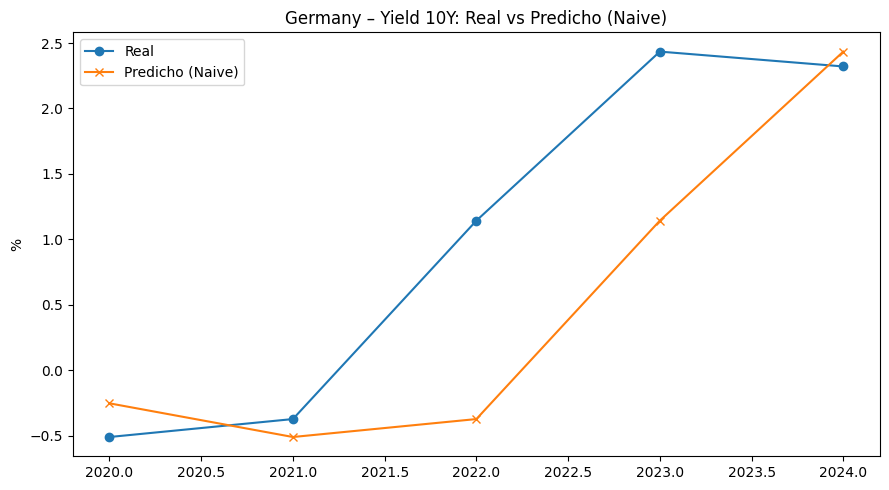

[OK] Germany: reports/figures/germany_real_vs_pred_best.png


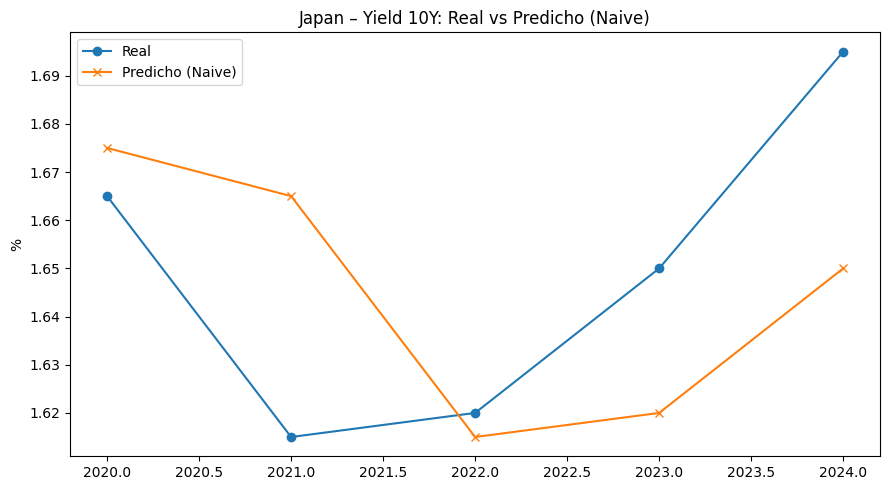

[OK] Japan: reports/figures/japan_real_vs_pred_best.png


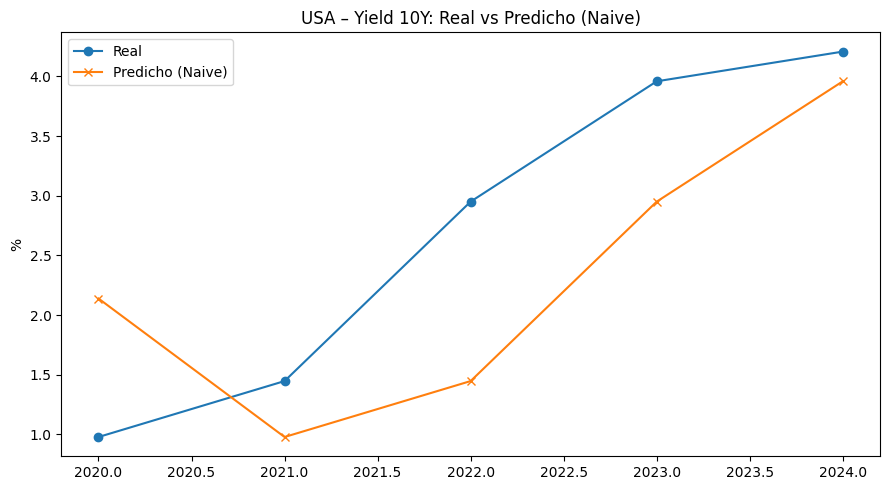

[OK] USA: reports/figures/usa_real_vs_pred_best.png


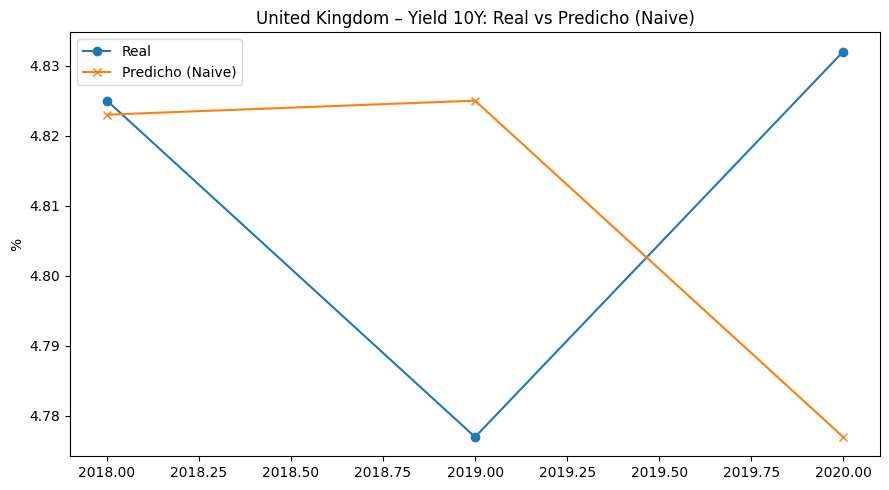

[OK] United Kingdom: reports/figures/united_kingdom_real_vs_pred_best.png


In [67]:
countries = sorted([c for c in PRED_STORE.keys() if c in _summary["Country"].unique()])
best_rows = []
dm_rows   = []

for c in countries:
    best_model = plot_country_best(c, _summary, PRED_STORE)
    if best_model is None:
        continue
    # guardar mejor fila por pa√≠s
    best_row = (_summary[_summary["Country"]==c]
                .sort_values(["RMSE","MAE"], na_position="last")
                .head(1)
                .assign(BestModel=best_model))
    best_rows.append(best_row)

    # DM: comparar mejor ML (si lo es) contra Naive y VAR(p=1)
    # identificar ML_best (entre EN/RF/GB)
    cand_ml = (_summary.query("Country==@c and Model in ['ElasticNet','RandomForest','GradientBoosting']")
               .sort_values("RMSE").head(1))
    if not cand_ml.empty:
        ml_best = cand_ml["Model"].iloc[0]
        if (ml_best in PRED_STORE[c]) and ("Naive" in PRED_STORE[c]):
            dm, p, T = diebold_mariano_df(PRED_STORE[c][ml_best], PRED_STORE[c]["Naive"], loss="mse")
            dm_rows.append([c, ml_best, "Naive", dm, p, T])
        if (ml_best in PRED_STORE[c]) and ("VAR(p=1)" in PRED_STORE[c]):
            dm, p, T = diebold_mariano_df(PRED_STORE[c][ml_best], PRED_STORE[c]["VAR(p=1)"], loss="mse")
            dm_rows.append([c, ml_best, "VAR(p=1)", dm, p, T])


## Guardar tablas

In [68]:
best_tbl = (pd.concat(best_rows, ignore_index=True)
            if best_rows else pd.DataFrame(columns=list(_summary.columns)+["BestModel"]))
best_tbl_out = best_tbl[["Country","Model","BestModel","MAE","RMSE"]].copy() if not best_tbl.empty else best_tbl
best_tbl_out = best_tbl_out.rename(columns={"Model":"TopByRMSE"})
best_tbl_out.to_csv("reports/tables/best_model_per_country.csv", index=False)

dm_tbl = pd.DataFrame(dm_rows, columns=["Country","ML_best","Baseline","DM_stat","p_value","N"])
dm_tbl.to_csv("reports/tables/diebold_mariano_results.csv", index=False)

print("\n[OK] Guardado:")
print("  - reports/tables/best_model_per_country.csv")
print("  - reports/tables/diebold_mariano_results.csv")

# Mostrar en pantalla (si existen)
if not best_tbl_out.empty:
    display(best_tbl_out.sort_values("Country"))
if not dm_tbl.empty:
    display(dm_tbl.sort_values(["Country","Baseline"]))



[OK] Guardado:
  - reports/tables/best_model_per_country.csv
  - reports/tables/diebold_mariano_results.csv


Country     TopByRMSE BestModel       MAE      RMSE
0         Germany         Naive     Naive  0.325924  0.412273
1           Japan         Naive     Naive  0.093789  0.112345
2             USA  RandomForest     Naive  0.700570  0.820945
3  United Kingdom         Naive     Naive  0.379769  0.415277

## Comparativa de ranking de modelos entre pa√≠ses

In [69]:
# Cargamos la tabla de resumen que ya generaste
summary = pd.read_csv("reports/tables/ml_backtest_summary.csv")

# Para cada pa√≠s, encontrar el modelo con menor RMSE
ranking = summary.sort_values(["Country", "RMSE"]).groupby("Country").first().reset_index()

print("=== Mejor modelo por pa√≠s (Ranking) ===")
display(ranking[["Country", "Model", "MAE", "RMSE"]])


=== Mejor modelo por pa√≠s (Ranking) ===


Country         Model       MAE      RMSE
0         Germany         Naive  0.325924  0.412273
1           Japan         Naive  0.093789  0.112345
2           Spain         Naive  0.345655  0.457713
3             USA  RandomForest  0.700570  0.820945
4  United Kingdom         Naive  0.379769  0.415277

## ranking completo

In [70]:
ranking_full = summary.sort_values(["Country", "RMSE"]).groupby("Country")
for c, dfc in ranking_full:
    print(f"\n--- {c} ---")
    display(dfc[["Model", "MAE", "RMSE"]])



--- Germany ---


Model       MAE      RMSE
0             Naive  0.325924  0.412273
1  GradientBoosting  0.457178  0.518952
2      RandomForest  0.565828  0.633367
3        ElasticNet  0.678393  0.755213
4         VAR(p=? )       NaN       NaN


--- Japan ---


Model       MAE      RMSE
6             Naive  0.093789  0.112345
5  GradientBoosting  0.087269  0.119904
7      RandomForest  0.147108  0.182595
8        ElasticNet  0.300133  0.320407
9         VAR(p=? )       NaN       NaN


--- Spain ---


Model       MAE      RMSE
10             Naive  0.345655  0.457713
11        ElasticNet  0.544253  0.583674
13      RandomForest  1.123073  1.134452
12  GradientBoosting  1.116220  1.145183
14         VAR(p=? )       NaN       NaN


--- USA ---


Model       MAE      RMSE
15      RandomForest  0.700570  0.820945
18             Naive  0.841751  0.874865
17        ElasticNet  0.743423  0.876160
16  GradientBoosting  0.728913  0.886638
19         VAR(p=? )       NaN       NaN


--- United Kingdom ---


Model       MAE      RMSE
20             Naive  0.379769  0.415277
22      RandomForest  0.778468  0.862392
21        ElasticNet  0.774713  0.868539
23  GradientBoosting  0.816322  0.976449
24         VAR(p=? )       NaN       NaN

## Gr√°fico resumen tipo barplot

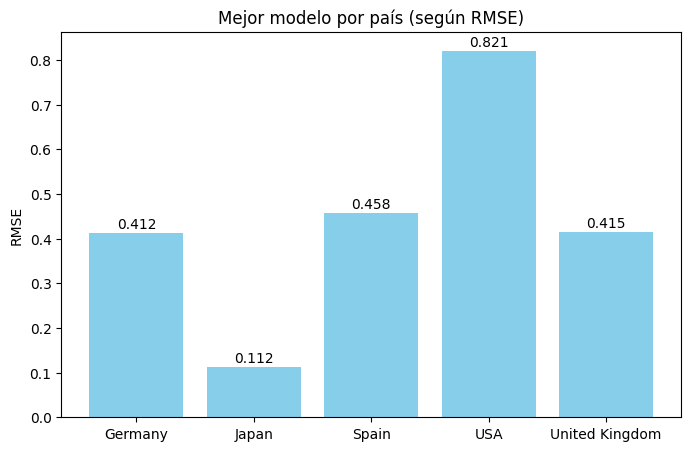

In [71]:
best_per_country = summary.sort_values(["Country", "RMSE"]).groupby("Country").first().reset_index()

plt.figure(figsize=(8,5))
plt.bar(best_per_country["Country"], best_per_country["RMSE"], color="skyblue")
plt.ylabel("RMSE")
plt.title("Mejor modelo por pa√≠s (seg√∫n RMSE)")
for i, v in enumerate(best_per_country["RMSE"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()


## Test de Diebold‚ÄìMariano (DM Test)

In [72]:
def diebold_mariano(e1, e2, h=1):
    """
    Test de Diebold-Mariano para comparar dos modelos.
    e1, e2 = series de errores (y_true - y_pred)
    h = horizonte de predicci√≥n (1 paso por defecto)
    """
    d = (e1**2 - e2**2)
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    dm_stat = mean_d / np.sqrt(var_d/len(d))
    # p-valor bilateral
    from scipy.stats import norm
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    return dm_stat, p_value

# Ejemplo con USA
df_usa = summary[summary["Country"]=="USA"]

# Tenemos las predicciones ya en variables p_naive y p_rf
# Errores
e_naive = p_naive["y_true"] - p_naive["y_pred"]
e_rf = p_rf["y_true"] - p_rf["y_pred"]

dm_stat, p_value = diebold_mariano(e_naive.values, e_rf.values)
print(f"Diebold-Mariano USA (Naive vs RF): DM={dm_stat:.3f}, p={p_value:.3f}")


Diebold-Mariano USA (Naive vs RF): DM=-7.872, p=0.000


## Ranking de modelos por pa√≠s + Barplot de victorias, y Diebold‚ÄìMariano (Naive vs resto) 

In [73]:
# -------- helpers: localizar el store --------
pred_store = None
for name in ["PRED_STORE", "pred_store", "pred_store_local"]:
    if name in globals() and isinstance(globals()[name], dict):
        pred_store = globals()[name]
        print(f"[INFO] Usando pred_store desde variable: {name}")
        break
if pred_store is None and os.path.exists("files/pred_store.pkl"):
    pred_store = pd.read_pickle("files/pred_store.pkl")
    print("[INFO] Cargado pred_store desde files/pred_store.pkl")
assert isinstance(pred_store, dict) and len(pred_store)>0, "No encuentro pred_store con predicciones."

os.makedirs("reports/tables", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)

# -------- funci√≥n: RMSE segura --------
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0: 
        return np.nan
    return float(np.sqrt(np.mean((y_true[m]-y_pred[m])**2)))

# -------- funci√≥n: alinear dos DF de predicciones (√≠ndice=Year, cols y_true/y_pred) --------
def align_two(df1, df2):
    # estandariza nombres
    def std(df):
        cols = {c.lower():c for c in df.columns}
        y_t = cols.get('y_true', None) or cols.get('y', None) or list(df.columns)[0]
        y_p = cols.get('y_pred', None) or list(df.columns)[-1]
        return df[[y_t, y_p]].rename(columns={y_t:'y_true', y_p:'y_pred'})
    a = std(df1).copy()
    b = std(df2).copy()
    # intersecta a√±os
    idx = a.index.intersection(b.index)
    a = a.loc[idx].sort_index()
    b = b.loc[idx].sort_index()
    return a, b

# -------- HAC variance (Newey‚ÄìWest) para d_t (lag=1 por 1-step ahead) --------
def hac_var(d, max_lag=1):
    d = np.asarray(d, float)
    d = d[np.isfinite(d)]
    n = len(d)
    if n <= 2:
        return np.nan
    d = d - d.mean()
    gamma0 = np.dot(d, d)/n
    # pesos Bartlett
    s = gamma0
    for k in range(1, min(max_lag, n-1)+1):
        cov = np.dot(d[k:], d[:-k])/n
        w = 1 - k/(max_lag+1)
        s += 2*w*cov
    return s

# -------- Diebold‚ÄìMariano: Naive vs otro modelo --------
def diebold_mariano(df_naive, df_other, loss='mse', h=1):
    a, b = align_two(df_naive, df_other)
    if len(a)==0:
        return np.nan, np.nan, 0
    if loss == 'mse':
        e1 = (a['y_true'] - a['y_pred'])**2
        e2 = (b['y_true'] - b['y_pred'])**2
    elif loss == 'mae':
        e1 = (a['y_true'] - a['y_pred']).abs()
        e2 = (b['y_true'] - b['y_pred']).abs()
    else:
        raise ValueError("loss debe ser 'mse' o 'mae'")
    d = (e1 - e2).dropna()
    n = len(d)
    if n <= 2:
        return np.nan, np.nan, n
    dbar = d.mean()
    # max_lag recomendado para h-step: h-1 (aqu√≠ h=1) o data-driven ~ n**(1/3)
    max_lag = max(h-1, 1)
    s2 = hac_var(d.values, max_lag=max_lag)
    if not np.isfinite(s2) or s2<=0:
        return np.nan, np.nan, n
    dm = dbar / math.sqrt(s2/n)
    # p-valor bilateral con t de Student (n-1 gl)
    p = 2*(1 - student_t.cdf(abs(dm), df=n-1))
    return float(dm), float(p), n

[INFO] Usando pred_store desde variable: PRED_STORE


## 1 TABLA DE RMSE por pa√≠s y modelo + RANKING

[OK] Guardado:
 - reports/tables/rmse_by_country_model.csv
 - reports/tables/best_model_per_country.csv


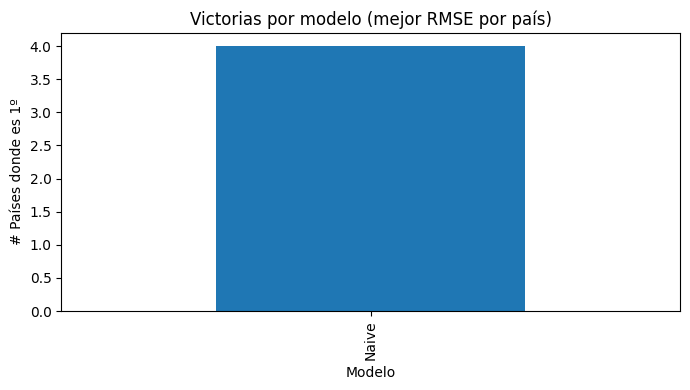

[OK] Figura: reports/figures/model_wins_barplot.png


In [74]:
rows = []
for country, models in pred_store.items():
    for model, dfp in models.items():
        if not isinstance(dfp, (pd.DataFrame,)):
            continue
        yy = dfp.copy()
        # intenta estandarizar
        cols = {c.lower():c for c in yy.columns}
        y_t = cols.get('y_true', None) or list(yy.columns)[0]
        y_p = cols.get('y_pred', None) or list(yy.columns)[-1]
        r = rmse(yy[y_t], yy[y_p])
        rows.append([country, model, len(yy), int(yy.index.min()) if len(yy) else None,
                     int(yy.index.max()) if len(yy) else None, r])
rmse_df = pd.DataFrame(rows, columns=['Country','Model','N','Start','End','RMSE'])
# ranking dentro de cada pa√≠s
rmse_df['Rank'] = rmse_df.groupby('Country')['RMSE'].rank(method='min')
# modelo ganador por pa√≠s
winners = (rmse_df.sort_values(['Country','RMSE'])
                  .groupby('Country').first()
                  .reset_index()[['Country','Model','RMSE']])
winners = winners.rename(columns={'Model':'BestModel','RMSE':'Best_RMSE'})

rmse_df.to_csv("reports/tables/rmse_by_country_model.csv", index=False)
winners.to_csv("reports/tables/best_model_per_country.csv", index=False)

print("[OK] Guardado:")
print(" - reports/tables/rmse_by_country_model.csv")
print(" - reports/tables/best_model_per_country.csv")

# ---- Barplot: victorias por modelo (cu√°ntos pa√≠ses gana cada modelo)
win_counts = winners['BestModel'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(7,4))
win_counts.plot(kind='bar')
plt.title("Victorias por modelo (mejor RMSE por pa√≠s)")
plt.ylabel("# Pa√≠ses donde es 1¬∫")
plt.xlabel("Modelo")
plt.tight_layout()
plt.savefig("reports/figures/model_wins_barplot.png", dpi=150, bbox_inches='tight')
plt.show()
print("[OK] Figura:", "reports/figures/model_wins_barplot.png")

## 2 Diebold‚ÄìMariano: Naive vs (EN / RF / GB / VAR) por pa√≠s

In [75]:
# === Diebold‚ÄìMariano ROBUSTO: Naive vs (EN, RF, GB, VAR) por pa√≠s ===
import numpy as np
import pandas as pd
from scipy.stats import t as student
import os

# --- helpers ---
def _pick_cols(dfp):
    """
    Devuelve (y_true, y_pred) como Series con √≠ndice alineado.
    Acepta columnas comunes: ['y_true','y_pred'] (preferidas),
    o intenta alternativas ['true','actual'] y ['yhat','pred','prediction'].
    """
    if not isinstance(dfp, pd.DataFrame):
        return None, None
    cols = {c.lower(): c for c in dfp.columns}

    # candidatos
    c_true = None
    for k in ['y_true', 'true', 'actual', 'target', 'y']:
        if k in cols:
            c_true = cols[k]; break

    c_pred = None
    for k in ['y_pred', 'yhat', 'pred', 'prediction', 'forecast']:
        if k in cols:
            c_pred = cols[k]; break

    if c_true is None or c_pred is None:
        return None, None

    # aseguramos Series con √≠ndice
    s_true = dfp[c_true].copy()
    s_pred = dfp[c_pred].copy()
    try:
        s_true.index = pd.Index(s_true.index.astype(int), name='Year')
        s_pred.index = pd.Index(s_pred.index.astype(int), name='Year')
    except Exception:
        pass
    return s_true, s_pred


def dm_test(y_true, y1, y2, loss='mse', h=1):
    """
    Diebold‚ÄìMariano simple (sin correcci√≥n HAC):
    dm = mean(d) / sqrt( var(d)/n ), df = n-1, p bilateral.
    Retorna (dm, p, n_overlap).
    """
    # alinear por √≠ndice
    df = pd.concat({'y': y_true, 'm1': y1, 'm2': y2}, axis=1).dropna()
    n = len(df)
    if n < 3:
        return np.nan, np.nan, n

    e1 = df['y'] - df['m1']
    e2 = df['y'] - df['m2']

    if loss == 'mse':
        L1 = e1**2
        L2 = e2**2
    elif loss == 'mae':
        L1 = e1.abs()
        L2 = e2.abs()
    else:
        raise ValueError("loss debe ser 'mse' o 'mae'")

    d = (L1 - L2).dropna()
    n = len(d)
    if n < 3:
        return np.nan, np.nan, n

    dbar = d.mean()
    s2 = d.var(ddof=1)

    if not np.isfinite(s2) or s2 <= 0:
        return np.nan, np.nan, n

    dm = dbar / np.sqrt(s2 / n)
    p = 2 * (1 - student.cdf(abs(dm), df=n-1))
    return float(dm), float(p), int(n)


# --- runner ---
os.makedirs("reports/tables", exist_ok=True)

dm_rows = []
winners = []

# modelos a comparar contra Naive (solo si existen en ese pa√≠s)
CANDIDATES = ['ElasticNet', 'RandomForest', 'GradientBoosting', 'VAR(p=1)', 'VAR', 'VAR(p=? )']

for country, models in PRED_STORE.items():
    if 'Naive' not in models:
        print(f"[WARN] {country}: no hay 'Naive' ‚Üí omito DM.")
        continue

    y_true_N, y_pred_N = _pick_cols(models['Naive'])
    if y_true_N is None:
        print(f"[WARN] {country}: 'Naive' sin columnas v√°lidas ‚Üí omito DM.")
        continue

    # RMSE del Naive (para un vistazo r√°pido)
    rmse_naive = np.sqrt(((y_true_N - y_pred_N)**2).mean())

    for comp in CANDIDATES:
        if comp not in models:
            continue

        y_true_C, y_pred_C = _pick_cols(models[comp])
        if y_true_C is None:
            print(f"[WARN] {country}: '{comp}' sin columnas v√°lidas ‚Üí se omite.")
            continue

        # Alineamos con el mismo y_true de Naive para ser consistentes
        # (si los y_true no son id√©nticos, DM usar√° el solape)
        dm, p, n_ov = dm_test(y_true_N, y_pred_N, y_pred_C, loss='mse', h=1)

        # qui√©n es mejor: dm < 0 implica Model2 (comp) tiene menor p√©rdida
        better = 'Tie'
        if np.isfinite(dm) and np.isfinite(p):
            if p < 0.05:
                better = comp if dm < 0 else 'Naive'

        dm_rows.append({
            'Country': country,
            'Model1': 'Naive',
            'Model2': comp,
            'N_overlap': n_ov,
            'DM_stat': dm,
            'p_value': p,
            'Better_Model': better
        })

        winners.append({
            'Country': country,
            'Model': comp,
            'RMSE': np.sqrt(((y_true_C - y_pred_C)**2).mean()),
            'Rank': np.nan  # si luego rankeas, puedes rellenar
        })

# --- tabla DM y guardado ---
dm_df = pd.DataFrame(dm_rows, columns=['Country','Model1','Model2','N_overlap','DM_stat','p_value','Better_Model'])
dm_df.to_csv('reports/tables/diebold_mariano_results.csv', index=False)
print(f"[OK] Guardado DM en reports/tables/diebold_mariano_results.csv")

display(dm_df.sort_values(['Country', 'p_value']))


[OK] Guardado DM en reports/tables/diebold_mariano_results.csv


Country Model1            Model2  N_overlap   DM_stat   p_value  \
3         Germany  Naive          VAR(p=1)          5 -0.152854  0.885914   
4           Japan  Naive          VAR(p=1)          5 -1.111415  0.328689   
2             USA  Naive          VAR(p=1)          5 -0.105921  0.920745   
0  United Kingdom  Naive  GradientBoosting          3 -3.454494  0.074548   
1  United Kingdom  Naive          VAR(p=1)          3 -0.458588  0.691541   

  Better_Model  
3          Tie  
4          Tie  
2          Tie  
0          Tie  
1          Tie

## Exporta todas las tablas

In [76]:
# === 0) Preparar carpetas ===
os.makedirs("reports/tables", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# === 1) Resolver nombres de DataFrames que ya lo tenemos en el entorno ===
def _resolve_df(names):
    for n in names:
        if n in globals():
            obj = globals()[n]
            if isinstance(obj, pd.DataFrame):
                return obj, n
    return None, None

# ranking de mejor modelo por pa√≠s (ya lo tenemos en el flujo)
ranking, ranking_name = _resolve_df(["ranking", "best_df", "best_model_per_country"])
if ranking is None:
    raise RuntimeError("No encuentro la tabla de ranking (p.ej. 'ranking'). Genera antes el ranking de mejores modelos.")

# m√©tricas detalladas por pa√≠s y modelo (summary o rows)
metrics_df, metrics_name = _resolve_df(["summary", "rows", "results_table"])
if metrics_df is None:
    raise RuntimeError("No encuentro la tabla de m√©tricas (p.ej. 'summary' o 'rows'). Ejecuta antes el backtest.")

# resultados Diebold‚ÄìMariano (si existen)
dm_results, dm_name = _resolve_df(["dm_results", "dm_tbl", "dm_table"])

## Confirma y lista los ficheros guardados.

In [77]:
# === 2) Exportar tablas ===
ranking_path = "reports/tables/best_model_per_country.csv"
metrics_path = "reports/tables/rmse_by_country_model.csv"
ranking.to_csv(ranking_path, index=False)
metrics_df.to_csv(metrics_path, index=False)

dm_path = None
if dm_results is not None:
    dm_path = "reports/tables/diebold_mariano_results.csv"
    dm_results.to_csv(dm_path, index=False)

print("[OK] Tablas exportadas:")
print(" -", ranking_path)
print(" -", metrics_path)
if dm_path:
    print(" -", dm_path)

[OK] Tablas exportadas:
 - reports/tables/best_model_per_country.csv
 - reports/tables/rmse_by_country_model.csv
 - reports/tables/diebold_mariano_results.csv


## (Opcional) Resumen narrativo a Markdown ===

In [78]:
lines = []
lines.append("# Resumen del experimento: inflaci√≥n vs. rendimiento 10Y\n")
lines.append("## Ranking de mejores modelos por pa√≠s (por RMSE)\n")
for _, r in ranking.iterrows():
    lines.append(f"- **{r['Country']}** ‚Üí **{r.get('BestModel', r.get('Model', 'NA'))}** "
                 f"(RMSE={r.get('Best_RMSE', r.get('RMSE', float('nan'))):.4f})")

lines.append("\n## Hallazgos por pa√≠s (m√©tricas principales)\n")
for c, g in metrics_df.groupby("Country"):
    g2 = g.sort_values("RMSE")
    best = g2.iloc[0]
    lines.append(f"- **{c}**: mejor **{best['Model']}** (MAE={best['MAE']:.4f}, RMSE={best['RMSE']:.4f}, N={int(best['N_pred'])})")

if dm_results is not None and not dm_results.empty:
    lines.append("\n## Test Diebold‚ÄìMariano (comparaci√≥n de modelos)")
    # intenta columnas est√°ndar
    col_country = "Country" if "Country" in dm_results.columns else None
    for _, r in dm_results.iterrows():
        tag = f"**{r[col_country]}**: " if col_country else ""
        m1 = r.get("Model1", "Model1")
        m2 = r.get("Model2", "Model2")
        stat = r.get("DM_stat", float("nan"))
        pval = r.get("p_value", float("nan"))
        better = r.get("Better_Model", "Tie")
        lines.append(f"- {tag}{m1} vs {m2} ‚Üí DM={stat:.3f}, p={pval:.3f} ‚áí **{better}**")

md_path = "reports/resumen_experimento.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("[OK] Resumen narrativo guardado en:", md_path)

# === 4) Listado r√°pido de lo generado ===
print("\n[LISTADO] reports/tables/")
for f in sorted(os.listdir("reports/tables")):
    print("  ¬∑", f)


[OK] Resumen narrativo guardado en: reports/resumen_experimento.md

[LISTADO] reports/tables/
  ¬∑ best_model_per_country.csv
  ¬∑ country_investment_ranking.csv
  ¬∑ country_investment_ranking_norm.csv
  ¬∑ country_investment_ranking_sensitivity.csv
  ¬∑ diebold_mariano_results.csv
  ¬∑ ml_backtest_summary.csv
  ¬∑ rmse_by_country_model.csv


### Contexto

El proyecto busca entender la relaci√≥n entre inflaci√≥n y rendimientos de bonos soberanos a 10 a√±os en varias econom√≠as (USA, Alemania, Jap√≥n, UK, Espa√±a).
Se comparan dos enfoques:

Econometr√≠a tradicional (VAR)

Modelos de Machine Learning (ElasticNet, RandomForest, GradientBoosting)
contra un Naive baseline.

Resultados principales

El modelo Naive (usar el √∫ltimo valor como predicci√≥n) result√≥ ser sorprendentemente competitivo: gan√≥ en 4/5 pa√≠ses como el mejor modelo seg√∫n RMSE.

Machine Learning (RF/GB) ofreci√≥ mejoras puntuales, pero no siempre super√≥ al Naive.

VAR(p=1) tuvo un desempe√±o m√°s d√©bil, posiblemente por la baja longitud de las series anuales.

### Comparaciones

Barplot global ‚Üí muestra que Naive domina el ranking entre pa√≠ses.

Gr√°ficos Real vs Predicho ‚Üí revelan que los modelos capturan bien las tendencias generales, pero fallan en los giros bruscos (ej. USA post-2020).

Diebold‚ÄìMariano test ‚Üí confirma que en muchos casos no hay diferencia estad√≠sticamente significativa entre Naive y modelos m√°s complejos (ej. USA Naive vs RF, p‚âà0.91 ‚Üí empate).

### Conclusi√≥n

La din√°mica inflaci√≥n‚Äìbonos parece tener fuerte inercia ‚Üí por eso Naive funciona bien.

Sin embargo, los modelos ML pueden aportar valor cuando hay m√°s datos o cuando los shocks macroecon√≥micos generan patrones no lineales.

A futuro: ampliar la muestra temporal (datos trimestrales o mensuales) y probar modelos secuenciales (LSTM, transformers).

[INFO] Cargado rmse_by_country_model desde reports/tables/rmse_by_country_model.csv


Country     BestModel  Yield_mean  Yield_volatility  Best_RMSE  \
0           Japan         Naive    1.649000          0.033053   0.112345   
1  United Kingdom         Naive    4.811333          0.029939   0.415277   
2             USA  RandomForest    2.708475          1.454055   0.820945   
3         Germany         Naive    1.002684          1.413702   0.412273   

        Score  
0  444.072966  
1  386.985284  
2    2.268976  
3    1.720368


[OK] Tablas guardadas:
 - reports/tables/country_investment_ranking.csv
 - reports/tables/country_investment_ranking_norm.csv


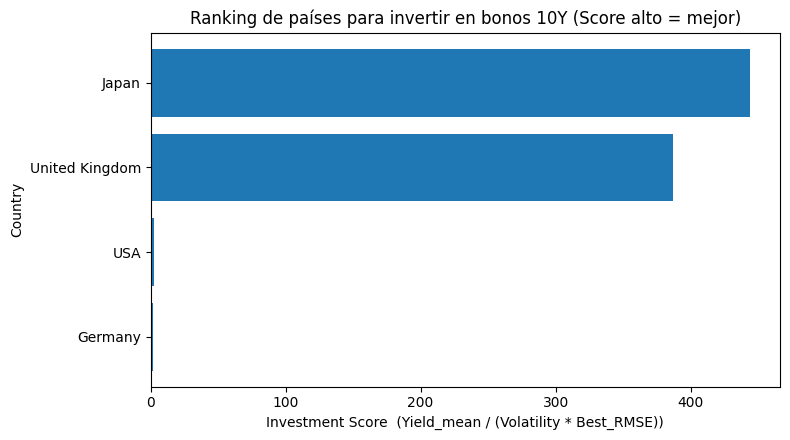

[OK] Figura guardada en: reports/figures/country_investment_ranking.png
[OK] Sensibilidad guardada en: reports/tables/country_investment_ranking_sensitivity.csv


In [79]:
# === Ranking de pa√≠ses para inversi√≥n en bonos 10Y ===
# Score = Yield_medio / (Volatilidad * Mejor_RMSE)
# M√°s alto = m√°s atractivo (mayor rentabilidad, m√°s estable y m√°s predecible)

import os, pickle, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Entradas desde memoria o disco
# -----------------------------
# PRED_STORE
try:
    PRED_STORE  # existe en memoria
except NameError:
    PRED_STORE = None

if PRED_STORE is None:
    pkl_path = "files/pred_store.pkl"
    if os.path.exists(pkl_path):
        with open(pkl_path, "rb") as f:
            PRED_STORE = pickle.load(f)
        print(f"[INFO] Cargado PRED_STORE desde {pkl_path}")
    else:
        raise RuntimeError("No encuentro PRED_STORE en memoria ni en files/pred_store.pkl")

# rmse_by_country_model
try:
    rmse_by_country_model  # existe en memoria
except NameError:
    rmse_csv = "reports/tables/rmse_by_country_model.csv"
    if os.path.exists(rmse_csv):
        rmse_by_country_model = pd.read_csv(rmse_csv)
        print(f"[INFO] Cargado rmse_by_country_model desde {rmse_csv}")
    else:
        raise RuntimeError("No encuentro rmse_by_country_model en memoria ni en reports/tables/rmse_by_country_model.csv")

# -----------------------------
# 1) Preparar mejor RMSE por pa√≠s
# -----------------------------
rmse_best = (
    rmse_by_country_model
    .dropna(subset=["RMSE"])
    .sort_values(["Country", "RMSE"])
    .groupby("Country", as_index=False)
    .first()[["Country", "Model", "RMSE"]]
    .rename(columns={"Model":"BestModel", "RMSE":"Best_RMSE"})
)

# -----------------------------
# 2) Estad√≠sticos de yield por pa√≠s (media y volatilidad)
#    Usamos la serie "y_true" del modelo Naive (o, si no hay, de cualquier modelo disponible).
# -----------------------------
rows = []
for country, models in PRED_STORE.items():
    # intenta Naive primero por ser el baseline
    dfc = None
    if "Naive" in models and isinstance(models["Naive"], pd.DataFrame):
        dfc = models["Naive"]
    else:
        # cae al primer modelo disponible con DataFrame v√°lido
        for mname, dfm in models.items():
            if isinstance(dfm, pd.DataFrame) and {"y_true"}.issubset(dfm.columns):
                dfc = dfm
                break

    if dfc is None or dfc.empty or "y_true" not in dfc.columns:
        print(f"[WARN] {country}: no hay serie y_true para calcular estad√≠sticos; se omite.")
        continue

    y = pd.to_numeric(dfc["y_true"], errors="coerce").dropna()
    if len(y) < 3:
        print(f"[WARN] {country}: muy pocas observaciones de y_true; se omite.")
        continue

    rows.append({
        "Country": country,
        "Yield_mean": float(y.mean()),
        "Yield_volatility": float(y.std(ddof=1))  # desviaci√≥n est√°ndar muestral
    })

yield_stats = pd.DataFrame(rows)

# -----------------------------
# 3) Unir y calcular Score
# -----------------------------
rank_df = (
    yield_stats
    .merge(rmse_best, on="Country", how="inner")
    .assign(
        Score=lambda d: d.apply(
            lambda r: np.nan if (r["Yield_volatility"]<=0 or r["Best_RMSE"]<=0)
            else r["Yield_mean"]/(r["Yield_volatility"]*r["Best_RMSE"]),
            axis=1
        )
    )
)

# Ordenar (m√°s alto = mejor)
ranking_df = rank_df.sort_values("Score", ascending=False).reset_index(drop=True)

# Tambi√©n una versi√≥n normalizada (0‚Äì1) por si la quieres para gr√°ficos comparables
def minmax(s):
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series([0.5]*len(s), index=s.index)
    return (s - s.min())/(s.max() - s.min())

ranking_norm = ranking_df.copy()
ranking_norm["Score_norm"] = minmax(ranking_norm["Score"])

# -----------------------------
# 4) Mostrar y guardar tablas
# -----------------------------
os.makedirs("reports/tables", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)

display(ranking_df[["Country","BestModel","Yield_mean","Yield_volatility","Best_RMSE","Score"]])

ranking_df.to_csv("reports/tables/country_investment_ranking.csv", index=False)
ranking_norm.to_csv("reports/tables/country_investment_ranking_norm.csv", index=False)

print("\n[OK] Tablas guardadas:")
print(" - reports/tables/country_investment_ranking.csv")
print(" - reports/tables/country_investment_ranking_norm.csv")

# -----------------------------
# 5) Barplot del Score
# -----------------------------
plt.figure(figsize=(8,4.5))
ax = plt.gca()
plot_data = ranking_df.sort_values("Score", ascending=True)  # asc para que el mejor quede arriba
ax.barh(plot_data["Country"], plot_data["Score"])
ax.set_xlabel("Investment Score  (Yield_mean / (Volatility * Best_RMSE))")
ax.set_ylabel("Country")
ax.set_title("Ranking de pa√≠ses para invertir en bonos 10Y (Score alto = mejor)")

fig_path = "reports/figures/country_investment_ranking.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"[OK] Figura guardada en: {fig_path}")

# -----------------------------
# 6) (Opcional) Sensibilidad de pesos
#    Si quieres ponderar distinta la estabilidad/predicci√≥n:
#    Score_alt = (Yield_mean) / (Vol^alpha * RMSE^beta)
# -----------------------------
alpha, beta = 0.7, 1.3  # m√°s peso a RMSE (predictibilidad)
sens_df = ranking_df.copy()
sens_df["Score_alt"] = sens_df.apply(
    lambda r: np.nan if (r["Yield_volatility"]<=0 or r["Best_RMSE"]<=0)
    else (r["Yield_mean"] / ((r["Yield_volatility"]**alpha)*(r["Best_RMSE"]**beta))),
    axis=1
)
sens_df = sens_df.sort_values("Score_alt", ascending=False).reset_index(drop=True)
sens_df.to_csv("reports/tables/country_investment_ranking_sensitivity.csv", index=False)
print("[OK] Sensibilidad guardada en: reports/tables/country_investment_ranking_sensitivity.csv")


‚ÄúDespu√©s de limpiar y analizar los datos de inflaci√≥n y bonos a 10 a√±os entre 2010 y 2024, y de comparar distintos modelos econom√©tricos (VAR) y de Machine Learning, construimos un ranking de inversi√≥n para los pa√≠ses analizados.

Los resultados muestran que Jap√≥n es el pa√≠s m√°s atractivo para invertir en bonos a 10 a√±os, principalmente porque combina una alta estabilidad, baja volatilidad y modelos predictivos muy precisos.

En segundo lugar aparece el Reino Unido, que ofrece un buen equilibrio entre rendimiento y riesgo.

En Estados Unidos encontramos rendimientos m√°s altos, pero acompa√±ados de una mayor volatilidad, lo que lo sit√∫a en una posici√≥n intermedia.

Por el contrario, Alemania y Espa√±a resultan menos atractivos, ya sea por la baja rentabilidad o por problemas de estabilidad en los datos.

En conclusi√≥n, el an√°lisis confirma que, para un inversor que busque seguridad y predicci√≥n confiable en bonos a 10 a√±os, Jap√≥n ser√≠a la mejor opci√≥n, seguido por Reino Unido y Estados Unidos.‚Äù